# ANALYSE QUANTITATIVE ET PRÉDICTION DU CAC 40
## Partie 1 : Collecte de Données, Ingénierie des Caractéristiques et Analyse Non-Supervisée

**Auteurs :** [SISSOKO Moussa, Abdoulaye hanne DIOP, Mathias]
**Date :** Janvier 2026
**Contexte :** Projet de fin d'études - Data Science

### 1. Objectifs de l'étude
Ce notebook constitue la première étape de notre pipeline de recherche quantitative. Il vise à :
1.  **Constituer une base de données robuste** sur les composantes de l'indice CAC 40 sur une profondeur historique de 10 ans.
2.  **Calculer des indicateurs techniques avancés** (Feature Engineering) pour capturer les différents régimes de marché (tendance, volatilité, retour à la moyenne).
3.  **Effectuer une analyse non-supervisée (Clustering)** pour identifier des typologies d'actifs et valider la diversification sectorielle au sein de l'indice.

### 2. Méthodologie
Nous utilisons une approche basée sur les **Panel Data** (données de panel) pour traiter simultanément la dimension temporelle (Time-Series) et la dimension transversale (Cross-Sectional) des 40 actifs.

In [5]:
# --- 1. IMPORTATION DES BIBLIOTHÈQUES ET CONFIGURATION ---

# Bibliothèques standards pour la manipulation de données
import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime
from pathlib import Path
import warnings

# Bibliothèques pour l'acquisition de données financières
import yfinance as yf
import pandas_datareader.data as web

# Bibliothèques pour l'analyse technique et économétrique
import ta  # Technical Analysis Library
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller # Test de stationnarité (ADF)

# Bibliothèques pour l'analyse non-supervisée (Machine Learning)
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Bibliothèques de visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliothèque traitement de données
import numpy as np
import pandas as pd
import ta

# Bibliothèques de features techniques 
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands, AverageTrueRange
from ta.trend import MACD



# Configuration de l'environnement
# Désactivation des avertissements pour la clarté du rendu final
warnings.filterwarnings('ignore')

# Définition de l'arborescence du projet (Reproductibilité)
PROJECT_ROOT_ABSOLUTE = "/home/onyxia/work/CAC40-Quantitative-Analysis-Predictive-Asset-Allocation/" 
ROOT_DIR = Path(PROJECT_ROOT_ABSOLUTE)
RAW_DATA_PATH = ROOT_DIR / "data" / "raw"
PROCESSED_DATA_PATH = ROOT_DIR / "data" / "processed"

# Création automatique des répertoires si inexistants
RAW_DATA_PATH.mkdir(parents=True, exist_ok=True)
PROCESSED_DATA_PATH.mkdir(parents=True, exist_ok=True)

print("Environnement configuré avec succès.")
print(f"Chemin de sortie des données brutes : {RAW_DATA_PATH}")

Environnement configuré avec succès.
Chemin de sortie des données brutes : /home/onyxia/work/CAC40-Quantitative-Analysis-Predictive-Asset-Allocation/data/raw


In [8]:
# =========================================================
# 2. ACQUISITION DES DONNÉES DE MARCHÉ 
# =========================================================

# Univers d'investissement : Les 40 composantes de l'indice français CAC 40
CAC40_TICKERS = [
    "AI.PA", "AIR.PA", "ALO.PA", "MT.AS", "ATO.PA", "CS.PA", "BNP.PA",
    "EN.PA", "CAP.PA", "CA.PA", "DSY.PA", "EL.PA", "ENGI.PA", "ERF.PA",
    "RMS.PA", "KER.PA", "OR.PA", "LR.PA", "MC.PA", "ML.PA", "ORA.PA",
    "RI.PA", "PUB.PA", "RNO.PA", "SAF.PA", "SGO.PA", "SAN.PA", "SU.PA",
    "GLE.PA", "STLAP.PA", "STMPA.PA", "TEP.PA", "HO.PA", "TTE.PA",
    "URW.PA", "VIE.PA", "DG.PA", "VIV.PA", "WLN.PA", "FR.PA"
]

# Paramètres temporels
# Une fenêtre de 10 ans est retenue pour capturer plusieurs cycles économiques 
# (expansion, récession) et assurer la robustesse statistique des modèles.
end_date = datetime.today().strftime('%Y-%m-%d')
start_date = pd.to_datetime(end_date) - pd.DateOffset(365*10)

print(f"Lancement du téléchargement : {len(CAC40_TICKERS)} actifs")
print(f"Période d'analyse : {start_date.date()} à {end_date}")

# Téléchargement via l'API Yahoo Finance
# Utilisation de 'auto_adjust=False' pour conserver les données OHLC brutes
# nécessaires au calcul de la volatilité de Garman-Klass.
df = yf.download(
    tickers=CAC40_TICKERS,
    start=start_date,
    end=end_date,
    auto_adjust=False,
    progress=True
).stack() # Transformation en format 'Long' (Panel Data)

# Normalisation des index et colonnes
df.index.names = ['date', 'ticker']
df.columns = df.columns.str.lower()

# Sauvegarde des données brutes (Preuve de source pour le mémoire)
df.reset_index().to_csv(RAW_DATA_PATH / "cac40_raw_dataset.csv", index=False, sep=';')

print(f"\n✅ Base de données brute constituée : {df.shape[0]} observations.")

Lancement du téléchargement : 40 actifs
Période d'analyse : 2016-01-17 à 2026-01-14


[*********************100%***********************]  40 of 40 completed



✅ Base de données brute constituée : 100502 observations.


In [9]:
# =========================================================
# 3. INGÉNIERIE DES CARACTÉRISTIQUES (FEATURE ENGINEERING)
# =========================================================
print("⚙️ Calcul des indicateurs techniques...")

df_features = df.copy()

# A. Garman-Klass Volatility
df_features['garman_klass_vol'] = (
    (np.log(df_features['high'] / df_features['low'])**2) / 2 - 
    (2 * np.log(2) - 1) * ((np.log(df_features['adj close'] / df_features['open']))**2)
)

# B. RSI (0-100)
df_features['rsi'] = df_features.groupby(level=1, group_keys=False)['adj close'].apply(
    lambda x: RSIIndicator(close=x, window=20).rsi() if len(x) > 20 else pd.Series(np.nan, index=x.index)
)

# C. Bollinger Bands (Log-Transformed)
# Note : Les valeurs seront petites (ex: 3.5 - 4.5) car calculées sur le Log du prix

def compute_bb_log(x):
    if len(x) < 20: return pd.DataFrame(np.nan, index=x.index, columns=['bb_low', 'bb_mid', 'bb_high'])
    
    # Calcul sur le log1p du prix
    bb = BollingerBands(close=np.log1p(x), window=20, window_dev=2)
    return pd.DataFrame({
        'bb_low': bb.bollinger_lband(),
        'bb_mid': bb.bollinger_mavg(),
        'bb_high': bb.bollinger_hband()
    }, index=x.index)

bb_df = df_features.groupby(level=1, group_keys=False)['adj close'].apply(compute_bb_log)
df_features = pd.concat([df_features, bb_df], axis=1)

# D. ATR (Standardisé Z-Score)
# Résultat attendu : Valeurs souvent entre -3 et +3
def compute_atr_zscore(x):
    if len(x) < 14: return pd.Series(np.nan, index=x.index)
    atr = AverageTrueRange(high=x['high'], low=x['low'], close=x['adj close'], window=14).average_true_range()
    # Formule Z-Score : (Valeur - Moyenne) / Ecart-Type
    return atr.sub(atr.mean()).div(atr.std())

df_features['atr'] = df_features.groupby(level=1, group_keys=False).apply(compute_atr_zscore)

# E. MACD (Standardisé Z-Score)
def compute_macd_zscore(x):
    if len(x) < 26: return pd.Series(np.nan, index=x.index)
    macd = MACD(close=x['adj close'], window_slow=26, window_fast=12, window_sign=9).macd()
    # Formule Z-Score
    return macd.sub(macd.mean()).div(macd.std())

df_features['macd'] = df_features.groupby(level=1, group_keys=False).apply(compute_macd_zscore)

# F. Euro Volume
df_features['euro_volume'] = (df_features['adj close'] * df_features['volume']) / 1e6

# =========================================================
# 3. FORMATAGE FINAL
# =========================================================
df = df_features.dropna()

# Ordre exact de vos colonnes
target_cols = [
    'adj close', 'close', 'high', 'low', 'open', 'volume',
    'garman_klass_vol', 'rsi', 
    'bb_low', 'bb_mid', 'bb_high', 
    'atr', 'macd', 'euro_volume'
]

# Sélection finale
df = df[[c for c in target_cols if c in df.columns]]

print(f"✅ Code exécuté avec succès. Dimensions : {df.shape}")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
print(df.tail())

⚙️ Calcul des indicateurs techniques...
✅ Code exécuté avec succès. Dimensions : (99502, 14)
                   adj close      close       high        low       open     volume  garman_klass_vol        rsi    bb_low    bb_mid   bb_high       atr      macd  euro_volume
date       ticker                                                                                                                                                              
2026-01-13 TTE.PA  56.529999  56.529999  56.680000  55.380001  55.520000  4177915.0          0.000144  59.301268  3.996067  4.024235  4.052404 -1.885190  0.076983   236.177530
           URW.PA  92.400002  92.400002  93.580002  92.300003  93.300003   531879.0          0.000059  51.551771  4.521058  4.541623  4.562189 -1.587829  0.196897    49.145620
           VIE.PA  29.590000  29.590000  30.350000  29.440001  30.330000  2095929.0          0.000228  49.933556  3.395467  3.425355  3.455243 -2.157395  0.657503    62.018539
           VIV.PA   2.39600

In [10]:
# =========================================================
# 4. AGRÉGATION MENSUELLE
# =========================================================
print(" Agrégation mensuelle des données...")

last_cols = [c for c in df.columns.unique(0) 
             if c not in ['euro_volume', 'volume', 'open', 'high', 'low', 'close']]

# Agrégation différenciée
data = pd.concat([
    # Euro volume : moyenne mensuelle
    df.unstack('ticker')['euro_volume'].resample('M').mean().stack('ticker').to_frame('euro_volume'),
    
    # Features techniques : dernière valeur du mois
    df.unstack()[last_cols].resample('M').last().stack('ticker')
], axis=1).dropna()

print(f"  • Dimensions après agrégation : {data.shape}")

# =========================================================
# 5. CALCUL DE LA LIQUIDITÉ MOYENNE (5 ANS)
# =========================================================
print("💧 Calcul de la moyenne mobile 5 ans du volume...")

# Moyenne mobile 60 mois (5 ans), minimum 12 mois (1 an)
data['euro_volume'] = (
    data.loc[:, 'euro_volume']
    .unstack('ticker')
    .rolling(window=60, min_periods=12)
    .mean()
    .stack()
)

# Ranking mensuel de liquidité (1 = plus liquide)
data['euro_vol_rank'] = (
    data.groupby('date')['euro_volume'].rank(ascending=False)
)

print(f"✅ Liquidité calculée.")
print(f"  • Volume moyen min : {data['euro_volume'].min():.2f}M€")
print(f"  • Volume moyen max : {data['euro_volume'].max():.2f}M€")
print(f"\n📊 Top 10 actions les plus liquides (dernière date) :")
print(data.loc[data.index.get_level_values(0).max()].nlargest(10, 'euro_volume')[['euro_volume', 'euro_vol_rank']])

data


 Agrégation mensuelle des données...
  • Dimensions après agrégation : (4713, 9)
💧 Calcul de la moyenne mobile 5 ans du volume...
✅ Liquidité calculée.
  • Volume moyen min : 0.00M€
  • Volume moyen max : 258.60M€

📊 Top 10 actions les plus liquides (dernière date) :
        euro_volume  euro_vol_rank
ticker                            
MC.PA    258.092797            1.0
TTE.PA   225.875762            2.0
BNP.PA   155.503265            3.0
AIR.PA   152.231719            4.0
SAN.PA   149.592471            5.0
SU.PA    148.803238            6.0
OR.PA    131.112939            7.0
CS.PA    114.302391            8.0
RMS.PA   105.165510            9.0
AI.PA    104.469663           10.0


euro_volume    adj close  garman_klass_vol        rsi    bb_low    bb_mid   bb_high       atr      macd  euro_vol_rank
date       ticker                                                                                                                        
2016-02-29 AI.PA           NaN    51.831631         -0.015017  54.491078  3.919980  3.948250  3.976520  1.094096 -0.118782            NaN
           AIR.PA          NaN    51.886940         -0.002901  62.593931  3.789174  3.874439  3.959705  0.549334  0.074344            NaN
           ALO.PA          NaN    15.750302         -0.010751  21.300460  2.761233  2.863208  2.965183  0.549066 -1.472562            NaN
           ATO.PA          NaN  3453.156494         -0.003053  49.774988  8.058213  8.124742  8.191271  0.854659 -0.185041            NaN
           BNP.PA          NaN    24.519476         -0.110281  53.188461  3.117052  3.181806  3.246559  0.672609 -0.282492            NaN
...                        ...          ...               ...        ...       ...       ...       ...       ...       ...            ...
2026-01-31 TTE.PA   225.875762    56.529999          0.000144  59.301268  3.996067  4.024235  4.052404 -1.885190  0.076983            2.0
           URW.PA    25.368043    92.400002          0.000059  51.551771  4.521058  4.541623  4.562189 -1.587829  0.196897           36.0
           VIE.PA    44.830012    29.590000          0.000228  49.933556  3.395467  3.425355  3.455243 -2.157395  0.657503           26.0
           VIV.PA    27.761694     2.396000          0.000267  42.624600  1.198661  1.215382  1.232103 -1.392248 -0.133883           34.0
           WLN.PA    24.792450     1.584000          0.000541  46.919735  0.889019  0.938665  0.988312 -1.407923  0.024409           37.0

[4713 rows x 10 columns]

In [11]:
# =================================================================================
# 5. CALCUL DES RENDEMENTS (MOMENTUM) pour plusieurs horizons pour les features
# =================================================================================
print("📈 Calcul des rendements avec clipping...")

def calculate_returns(df):
    """
    Calcule les rendements cumulés (Momentum) avec clipping des outliers.
    Adapté pour des données MENSUELLES.
    """
    outlier_cutoff = 0.005  # Coupe les 0.5% extrêmes
    
    # Lags en MOIS (cohérent avec resample('M'))
    lags = [1, 2, 3, 6, 9, 12]  # 1M, 2M, 3M, 6M, 9M, 12M
    
    for lag in lags:
        # 1. Rendement cumulé sur 'lag' mois
        returns_raw = df['adj close'].pct_change(lag)
        
        # 2. Bornes avec expanding window
        # min_periods=12 → besoin de 12 MOIS (1 an) minimum
        lower_bound = returns_raw.expanding(min_periods=12).quantile(outlier_cutoff)
        upper_bound = returns_raw.expanding(min_periods=12).quantile(1 - outlier_cutoff)
        
        # 3. Clipping et assignation
        df[f'return_{lag}m'] = returns_raw.clip(lower=lower_bound, upper=upper_bound)
    
    return df

# Application par ticker
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

print(f"✅ Rendements calculés. Dimensions : {data.shape}")
print(f"  • Nouvelles colonnes : {[c for c in data.columns if 'return' in c]}")
print("\n📊 Aperçu des rendements :")
print(data[[c for c in data.columns if 'return' in c]].describe())

data.tail()


📈 Calcul des rendements avec clipping...
✅ Rendements calculés. Dimensions : (4233, 16)
  • Nouvelles colonnes : ['return_1m', 'return_2m', 'return_3m', 'return_6m', 'return_9m', 'return_12m']

📊 Aperçu des rendements :
         return_1m    return_2m    return_3m    return_6m    return_9m   return_12m
count  4233.000000  4233.000000  4233.000000  4233.000000  4233.000000  4233.000000
mean      0.028468     0.035710     0.041283     0.059807     0.088293     0.115789
std       1.318578     1.271560     1.114168     0.597387     0.501926     0.375200
min      -0.724211    -0.827506    -0.856965    -0.924531    -0.944890    -0.971504
25%      -0.037873    -0.047339    -0.054181    -0.068407    -0.074333    -0.073502
50%       0.008291     0.018165     0.026915     0.050209     0.076862     0.099200
75%       0.054264     0.082742     0.104964     0.165938     0.225919     0.279943
max      85.623215    82.377924    71.882977    36.214959    27.072513    10.832898


euro_volume  adj close  garman_klass_vol        rsi    bb_low    bb_mid   bb_high       atr      macd  euro_vol_rank  return_1m  return_2m  return_3m  return_6m  return_9m  return_12m
date       ticker                                                                                                                                                                                         
2026-01-31 TTE.PA   225.875762  56.529999          0.000144  59.301268  3.996067  4.024235  4.052404 -1.885190  0.076983            2.0   0.016909   0.010475   0.063855   0.121758   0.158652    0.065372
           URW.PA    25.368043  92.400002          0.000059  51.551771  4.521058  4.541623  4.562189 -1.587829  0.196897           36.0  -0.003881   0.008513   0.030790   0.083998   0.299434    0.197549
           VIE.PA    44.830012  29.590000          0.000228  49.933556  3.395467  3.425355  3.455243 -2.157395  0.657503           26.0  -0.004374   0.010242   0.032810  -0.003704  -0.038250    0.123380
           VIV.PA    27.761694   2.396000          0.000267  42.624600  1.198661  1.215382  1.232103 -1.392248 -0.133883           34.0   0.012680  -0.047695  -0.232543  -0.279399  -0.123628   -0.121057
           WLN.PA    24.792450   1.584000          0.000541  46.919735  0.889019  0.938665  0.988312 -1.407923  0.024409           37.0   0.014084   0.035294  -0.326244  -0.505618  -0.674743   -0.814085

from IPython.display import Markdown, display

markdown_text = r"""
# Les 5 Facteurs Fama-French - Guide Complet CAC40

## 1. Mkt-RF (Market Risk Premium)

**Définition** : Prime de risque du marché = Return du marché - Taux sans risque

$$Mkt-RF_t = R_{M,t} - R_{f,t}$$

**Interprétation** : Mesure le rendement excédentaire pour investir en actions plutôt qu'en obligations.

---

## 2. SMB (Small Minus Big)

**Définition** : Prime de taille = Return des petites capitalisations - Return des grosses capitalisations

$$SMB_t = \frac{1}{2}(Small\ Value_t + Small\ Growth_t) - \frac{1}{2}(Big\ Value_t + Big\ Growth_t)$$

**Interprétation** : Capte l'effet taille. Historiquement, les petites entreprises surperforment les grandes (plus risquées).

---

## 3. HML (High Minus Low)

**Définition** : Prime value = Return des actions value (B/M élevé) - Return des actions growth (B/M faible)

$$HML_t = \frac{1}{2}(Small\ Value_t + Big\ Value_t) - \frac{1}{2}(Small\ Growth_t + Big\ Growth_t)$$

**Book-to-Market** :

$$B/M = \frac{\text{Valeur comptable}}{\text{Capitalisation boursière}}$$

**Interprétation** : Actions "décotées" (value) surperforment les actions "chères" (growth).

---

## 4. RMW (Robust Minus Weak)

**Définition** : Prime de rentabilité = Return des entreprises très rentables - Return des entreprises peu rentables

$$RMW_t = \frac{1}{2}(Small\ Robust_t + Big\ Robust_t) - \frac{1}{2}(Small\ Weak_t + Big\ Weak_t)$$

**Operating Profitability** :

$$OP = \frac{\text{Revenues} - \text{COGS} - \text{SG\&A} - \text{Interest}}{\text{Book Equity}}$$

**Interprétation** : Entreprises rentables (marges élevées) surperforment les entreprises en difficulté.

---

## 5. CMA (Conservative Minus Aggressive)

**Définition** : Prime d'investissement = Return des entreprises conservatrices - Return des entreprises agressives

$$CMA_t = \frac{1}{2}(Small\ Conservative_t + Big\ Conservative_t) - \frac{1}{2}(Small\ Aggressive_t + Big\ Aggressive_t)$$

**Asset Growth** :

$$\text{Investment} = \frac{\Delta \text{Total Assets}}{\text{Total Assets}_{t-1}}$$

**Interprétation** : Entreprises qui investissent peu (prudentes) surperforment celles qui investissent massivement.

---

## Modèle Complet Fama-French 5 Facteurs

$$R_{i,t} - R_{f,t} = \alpha_i + \beta_{i,MKT}(Mkt-RF_t) + \beta_{i,SMB}(SMB_t) + \beta_{i,HML}(HML_t) + \beta_{i,RMW}(RMW_t) + \beta_{i,CMA}(CMA_t) + \varepsilon_{i,t}$$

**Où** :
- $R_{i,t} - R_{f,t}$ : Excess return de l'actif i
- $\alpha_i$ : Jensen's alpha (performance anormale)
- $\beta_{i,j}$ : Sensibilité au facteur j
- $\varepsilon_{i,t}$ : Erreur idiosyncratique

---

## Exemple Global : LVMH dans le CAC40

### Données du mois (Octobre 2025)

| Variable | Valeur |
|----------|--------|
| Return LVMH | +3.5% |
| Taux sans risque (RF) | +0.3% |
| Excess return LVMH | +3.2% |
| **Facteurs du mois** | |
| Mkt-RF | +2.0% |
| SMB | +1.5% |
| HML | -1.0% |
| RMW | +2.5% |
| CMA | +1.8% |

### Betas LVMH (estimés sur 60 mois)

| Facteur | Beta | Interprétation |
|---------|------|----------------|
| **Mkt-RF** | 0.95 | Sensibilité légèrement inférieure au marché |
| **SMB** | -0.35 | Grosse capitalisation (négative) |
| **HML** | -0.60 | Growth stock (B/M faible) |
| **RMW** | +0.75 | Très rentable (marges 30%) |
| **CMA** | +0.50 | Conservatrice (croissance organique) |

### Décomposition du Return LVMH

$$R_{LVMH} - R_f = \alpha + \beta_{MKT} \times Mkt-RF + \beta_{SMB} \times SMB + \beta_{HML} \times HML + \beta_{RMW} \times RMW + \beta_{CMA} \times CMA$$

**Calcul détaillé** :

| Composante | Formule | Contribution |
|------------|---------|--------------|
| **Alpha** | α | +0.50% |
| **Market** | 0.95 × 2.0% | +1.90% |
| **Size** | -0.35 × 1.5% | -0.53% |
| **Value** | -0.60 × (-1.0%) | +0.60% |
| **Profitability** | 0.75 × 2.5% | +1.88% |
| **Investment** | 0.50 × 1.8% | +0.90% |
| **TOTAL** | | **+5.25%** |

### Interprétation

**Pourquoi LVMH a monté de +3.5% ce mois ?**

1. ✅ **Marché positif** (+1.90%) : Le CAC40 monte, LVMH suit (β=0.95)
2. ❌ **Désavantage taille** (-0.53%) : Les petites caps surperforment, LVMH pénalisée
3. ✅ **Growth style** (+0.60%) : Les growth stocks surperforment ce mois
4. ✅ **Haute rentabilité** (+1.88%) : LVMH très profitable
5. ✅ **Discipline de capital** (+0.90%) : LVMH investit prudemment
6. ✅ **Alpha positif** (+0.50%) : Performance inexpliquée = talent/marque LVMH

**Conclusion** : 85% du return LVMH expliqué par les 5 facteurs, 15% = alpha

---

## Tableau Récapitulatif des Facteurs

| Facteur | Formule | Qui gagne ? | Performance US (1963-2023) |
|---------|---------|-------------|---------------------------|
| **Mkt-RF** | R_M - R_f | Actions > Obligations | +8.3% annuel |
| **SMB** | Petites - Grosses | Petites caps | +3.2% annuel |
| **HML** | Value - Growth | Value (B/M élevé) | +4.8% annuel |
| **RMW** | Rentables - Faibles | Rentables (OP élevé) | +3.1% annuel |
| **CMA** | Conservatrices - Agressives | Conservatrices | +3.0% annuel |

**Pouvoir explicatif** : Le modèle FF5 explique **94% de la variance** des returns cross-sectionnels.

---

## Application Pratique CAC40

### Exemples de Tickers par Profil

| Profil | Tickers | Caractéristiques |
|--------|---------|------------------|
| **Value Cyclique** | Renault, SocGen | β_HML > 0, β_RMW < 0 |
| **Growth Qualité** | LVMH, Hermès | β_HML < 0, β_RMW > 0 |
| **Défensif** | Danone, Sanofi | β_MKT < 1, β_RMW > 0 |
| **Cyclique** | TotalEnergies | β_MKT > 1, β_HML > 0 |

**Référence** : Fama & French (2015), *Journal of Financial Economics*, 116(1), 1-22.
"""

display(Markdown(markdown_text))


# Les 5 Facteurs Fama-French 

In [45]:
# =========================================================
# 6. FAMA-FRENCH 5 FACTEURS - EUROPE
# =========================================================
print("\n📈 Téléchargement des facteurs Fama-French (Europe)...")

import pandas_datareader.data as web
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm

# Téléchargement des 5 facteurs européens
factor_data = web.DataReader('Europe_5_Factors',  
                             'famafrench',
                             start='2010')[0].drop('RF', axis=1)  # Enlève le taux sans risque

# Préparation des données
factor_data.index = factor_data.index.to_timestamp()
factor_data = factor_data.resample('M').last().div(100)  # Conversion en décimales (5.2% → 0.052)
factor_data.index.name = 'date'

print(f"  • Facteurs téléchargés : {factor_data.columns.tolist()}")
print(f"  • Période : {factor_data.index.min()} → {factor_data.index.max()}")

# =========================================================
# 7. JOINTURE AVEC LES RENDEMENTS CAC40
# =========================================================
print("\n🔗 Jointure avec les rendements mensuels...")

# Vérification avant jointure
print(f"  • data avant jointure : {data.shape}")
assert 'return_1m' in data.columns, "❌ 'return_1m' manquant ! Exécutez calculate_returns() d'abord."

# Join
factor_data = factor_data.join(data['return_1m']).sort_index()
print(f"  • factor_data après join : {factor_data.shape}")

# =========================================================
# 8. FILTRAGE : MINIMUM 10 MOIS DE DONNÉES
# =========================================================
print("\n🔍 Filtrage des actions avec < 10 mois de données...")

observations = factor_data.groupby(level=1).size()
valid_stocks = observations[observations >= 10]

print(f"  • Actions avant filtrage : {observations.nunique()}")
print(f"  • Actions après filtrage (≥10 mois) : {valid_stocks.nunique()}")

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

# =========================================================
# 9. CALCUL DES BETAS ROLLING (24 MOIS)
# =========================================================
print("\n📊 Calcul des betas rolling (fenêtre 24 mois)...")

def compute_rolling_betas(x):
    """
    Régression rolling OLS : return_1m = α + β1*Mkt-RF + β2*SMB + ... + ε
    """
    if len(x) < 10:  # Minimum 10 observations
        return pd.DataFrame(np.nan, index=x.index, columns=['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA'])
    
    try:
        model = RollingOLS(
            endog=x['return_1m'],  # Variable dépendante (rendement)
            exog=sm.add_constant(x.drop('return_1m', axis=1)),  # Variables indépendantes (facteurs)
            window=min(24, x.shape[0]),  # Fenêtre de 24 mois max
            min_nobs=len(x.columns)  # Minimum d'observations = nombre de facteurs + 1
        )
        
        betas = model.fit(params_only=True).params.drop('const', axis=1)
        return betas
    
    except Exception as e:
        print(f"⚠️ Erreur pour {x.index.get_level_values(1)[0]} : {e}")
        return pd.DataFrame(np.nan, index=x.index, columns=['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA'])

betas = factor_data.groupby(level=1, group_keys=False).apply(compute_rolling_betas)

print(f"✅ Betas calculés. Shape : {betas.shape}")
print(f"  • Exemple de betas :\n{betas.head()}")

# =========================================================
# 10. JOINTURE DES BETAS AVEC LES FEATURES
# =========================================================
print("\n🔗 Intégration des betas aux features...")

factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

# Shift des betas (t-1) pour éviter le look-ahead bias
data = data.join(betas.groupby('ticker').shift())

# Remplissage des NaN par la moyenne (par ticker)
data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(
    lambda x: x.fillna(x.mean())
)

# Nettoyage final
data = data.drop('adj close', axis=1) if 'adj close' in data.columns else data
data = data.dropna()

print(f"✅ Pipeline Fama-French terminée !")
print(f"  • Dimensions finales : {data.shape}")
print(f"  • Colonnes finales : {data.columns.tolist()}")

# =========================================================
# 11. VÉRIFICATION FINALE
# =========================================================
print("\n🔍 Vérification finale des données...")
print(data.info())
print(f"\n📊 Statistiques des betas :")
print(data[factors].describe())

data.tail()



📈 Téléchargement des facteurs Fama-French (Europe)...
  • Facteurs téléchargés : ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
  • Période : 2010-01-31 00:00:00 → 2025-11-30 00:00:00

🔗 Jointure avec les rendements mensuels...
  • data avant jointure : (3753, 16)
  • factor_data après join : (3673, 6)

🔍 Filtrage des actions avec < 10 mois de données...
  • Actions avant filtrage : 2
  • Actions après filtrage (≥10 mois) : 1

📊 Calcul des betas rolling (fenêtre 24 mois)...
✅ Betas calculés. Shape : (3666, 5)
  • Exemple de betas :
                   Mkt-RF  SMB  HML  RMW  CMA
date       ticker                            
2018-02-28 AI.PA      NaN  NaN  NaN  NaN  NaN
           AIR.PA     NaN  NaN  NaN  NaN  NaN
           ALO.PA     NaN  NaN  NaN  NaN  NaN
           ATO.PA     NaN  NaN  NaN  NaN  NaN
           BNP.PA     NaN  NaN  NaN  NaN  NaN

🔗 Intégration des betas aux features...
✅ Pipeline Fama-French terminée !
  • Dimensions finales : (3744, 20)
  • Colonnes finales : ['euro_volume

euro_volume  garman_klass_vol        rsi    bb_low    bb_mid   bb_high       atr      macd  euro_vol_rank  return_1m  return_2m  return_3m  return_6m  return_9m  return_12m    Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                                                                                                                                                                                                
2026-01-31 TEP.PA    31.317182          0.000401  53.963132  4.097066  4.137092  4.177118 -1.712599  0.225699           33.0   0.011966   0.056381   0.010007  -0.269949  -0.320022   -0.276360  0.797547  1.144512 -0.627316  0.464822  1.326200
           TTE.PA   226.048285          0.000089  52.635975  3.997760  4.022591  4.047422 -1.885487 -0.218618            2.0  -0.008455  -0.014729   0.037320   0.093778   0.129752    0.038799  0.765424 -1.073342  1.190420  0.010455  0.113562
           VIE.PA    44.824324          0.000047  60.449950  3.391337  3.422608  3.453879 -2.182566  0.845760           26.0   0.024899   0.039945   0.063176   0.025589  -0.009973    0.156409  0.917307  0.196822  0.403460  0.050941 -0.025554
           VIV.PA    27.769768          0.000133  43.774864  1.198915  1.213846  1.228777 -1.390722 -0.181533           34.0   0.020287  -0.040541  -0.226778  -0.273985  -0.117045   -0.114453  0.940707  0.378244 -0.137440  0.470980  1.331747
           WLN.PA    24.794962          0.000829  44.176578  0.863880  0.931325  0.998770 -1.404074  0.020473           37.0  -0.017286   0.003268  -0.347086  -0.520911  -0.684805   -0.817899  1.007450  1.059334 -0.070885 -1.767194 -1.858044

## K-Means Clustering

In [ ]:
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd

# Nettoyage préventif
if 'cluster' in data.columns:
    data = data.drop('cluster', axis=1)

# ==============================================================================
# PARAMÈTRES DU CLUSTERING
# ==============================================================================
# Justification : Au lieu de laisser le K-Means totalement aléatoire (instable),
# nous initialisons les centroids sur les seuils psychologiques du RSI.
# Cela garantit la stabilité sémantique des clusters (0 = Toujours Survente).
# Seuils : 30 (Survente), 45 (Neutre Bas), 55 (Neutre Haut), 70 (Surachat).
rsi_centroids = np.array([[30], [45], [55], [70]])

def get_clusters_daily(df):
    """
    Applique un K-Means contraint sur une coupe transversale à une date T.
    Objectif : Classer les actifs selon leur force relative du moment.
    """
    
    if len(df) < 4:
        df['cluster'] = 0 # Fallback neutre
        return df
    
    # 1. Extraction du signal (RSI)
    X_rsi = df[['rsi']].values
    
    # 2. Clustering Hybride
    # n_init=1 est obligatoire car nous imposons les centroids de départ (init=rsi_centroids).
    # L'algorithme va optimiser la variance locale autour de ces piliers métiers.
    kmeans = KMeans(n_clusters=4, init=rsi_centroids, n_init=1, random_state=0)
    labels = kmeans.fit_predict(X_rsi)
    
    # 3. Réordonnancement (Post-Processing)
    # Le K-Means peut intervertir les labels (ex: Cluster 0 devient le plus haut RSI).
    # Nous forçons l'ordre pour garantir que : Cluster 0 < Cluster 1 < Cluster 2 < Cluster 3
    # Cela est crucial pour l'interprétabilité financière des résultats.
    cluster_means = [(i, df.loc[labels==i, 'rsi'].mean() if (labels==i).sum()>0 else 0) for i in range(4)]
    cluster_means.sort(key=lambda x: x[1]) # Tri par RSI moyen croissant
    
    # Création du mapping 
    mapping = {old_label: new_ordered_label for new_ordered_label, (old_label, _) in enumerate(cluster_means)}
    
    df['cluster'] = [mapping[l] for l in labels]
    return df

# ==============================================================================
# APPLICATION 
# ==============================================================================
# Nous appliquons le clustering date par date (groupby 'date') et non sur l'ensemble.
# Cela permet de détecter les régimes de marché relatifs (ex: le "moins pire" en temps de krach).
print("Lancement du clustering guidé (Daily Cross-Section)...")
data = data.dropna(subset=['rsi']).groupby('date', group_keys=False).apply(get_clusters_daily)

print("Clustering terminé. Aperçu des régimes :")
print(data.groupby('cluster')['rsi'].mean()) # Vérification des moyennes

🚀 Lancement du clustering guidé (Daily Cross-Section)...
✅ Clustering terminé. Aperçu des régimes :
cluster
0    39.809573
1    48.138328
2    57.074898
3    69.678984
Name: rsi, dtype: float64


## Exports pour mémoire : Cluster + features

In [ ]:
import pandas as pd

# =============================================================================
# 1. DICTIONNAIRE DE MAPPING (TICKER -> NOM RÉEL)
# =============================================================================
# Vous pouvez compléter cette liste avec les autres entreprises de votre dataset
tickers_map = {
    'MC.PA': 'LVMH',
    'AI.PA': 'Air Liquide',
    'BNP.PA': 'BNP Paribas',
    'OR.PA': 'L\'Oréal',
    'SAN.PA': 'Sanofi',
    'TTE.PA': 'TotalEnergies',
    'RMS.PA': 'Hermès',
    'AIR.PA': 'Airbus',
    'CS.PA': 'AXA',
    'GLE.PA': 'Société Générale',
    'ACA.PA': 'Crédit Agricole',
    'KER.PA': 'Kering',
    'EL.PA': 'EssilorLuxottica',
    'SGO.PA': 'Saint-Gobain',
    'ORA.PA': 'Orange',
    'CAP.PA': 'Capgemini',
    'LR.PA': 'Legrand',
    'SU.PA': 'Schneider Electric',
    'DG.PA': 'Vinci',
    'ENGI.PA': 'Engie',
    'STMPA.PA': 'STMicroelectronics',
    'BN.PA': 'Danone',
    'SAF.PA': 'Safran'
}

# =============================================================================
# 2. EXTRACTION DES DONNÉES (DERNIÈRE DATE)
# =============================================================================
# On récupère la date la plus récente disponible dans vos données
last_date = data.index.get_level_values('date').max()
print(f" Extraction des données au : {last_date.date()}")

# On coupe le dataframe pour ne garder que ce jour-là
# .copy() est important pour éviter les avertissements de pandas
df_final = data.xs(last_date, level='date')[['euro_volume', 'rsi', 'cluster']].copy()

# =============================================================================
# 3. CRÉATION DE LA COLONNE NOM (CORRECTION TYPE ERROR)
# =============================================================================
# Ici, on utilise une méthode "infaillible" :
# Pour chaque ticker dans l'index, on cherche le nom dans le dictionnaire.
# Si on ne le trouve pas, on garde le ticker original (x).
df_final['Entreprise'] = [tickers_map.get(x, x) for x in df_final.index]

# =============================================================================
# 4. MISE EN FORME FINALE
# =============================================================================
# Réorganisation des colonnes : Nom en premier
cols = ['Entreprise', 'euro_volume', 'rsi', 'cluster']
df_final = df_final[cols]

# Tri : On met les plus gros volumes en haut (souvent les plus pertinents)
df_final = df_final.sort_values(by='euro_volume', ascending=False)

# Renommage des colonnes pour faire "propre" dans le mémoire
df_final.columns = ['Entreprise', 'Volume (M€)', 'RSI (14j)', 'Cluster']

# Arrondis pour la lisibilité
df_final['Volume (M€)'] = df_final['Volume (M€)'].round(1)
df_final['RSI (14j)'] = df_final['RSI (14j)'].round(1)

# =============================================================================
# 5. AFFICHAGE ET EXPORT
# =============================================================================

print("\n APERÇU DU TABLEAU POUR LE MÉMOIRE :\n")
print(df_final.head(15).to_string(index=False)) # index=False cache le code ticker

# Si vous voulez le code LaTeX pour copier-coller dans votre rapport :
print("\n" + "="*30)
print("CODE LATEX (A COPIER DANS OVERLEAF/RAPPORT)")
print("="*30)
print(df_final.head(10).to_latex(index=False, float_format="%.1f"))

📅 Extraction des données au : 2025-12-31

📊 APERÇU DU TABLEAU POUR LE MÉMOIRE :

        Entreprise  Volume (M€)  RSI (14j)  Cluster
              LVMH        258.3       62.4        3
     TotalEnergies        225.4       57.7        2
       BNP Paribas        153.6       67.2        3
            Airbus        151.7       49.9        1
            Sanofi        150.0       45.5        1
Schneider Electric        147.9       49.6        1
           L'Oréal        130.8       48.1        1
               AXA        113.6       62.0        3
       Air Liquide        104.1       37.8        0
            Hermès        103.8       49.8        1
            Safran        100.7       50.5        1
            Kering         91.9       50.7        1
  EssilorLuxottica         91.2       30.5        0
             Vinci         89.6       51.4        1
  Société Générale         87.9       71.1        3

CODE LATEX (A COPIER DANS OVERLEAF/RAPPORT)
\begin{tabular}{lrrr}
\toprule
Entreprise 

In [ ]:
import pandas as pd
import numpy as np

# 1. Configuration
target_date = data.index.get_level_values('date').max()
# On garde nos 6 champions pour que ça reste lisible
selected_tickers = ['MC.PA', 'TTE.PA', 'BNP.PA', 'SAN.PA', 'AIR.PA', 'AI.PA']

name_mapping = {
    'MC.PA': 'LVMH', 'TTE.PA': 'TotalEnergies', 'BNP.PA': 'BNP Paribas',
    'SAN.PA': 'Sanofi', 'AIR.PA': 'Airbus', 'AI.PA': 'Air Liquide'
}

# 2. LISTE ÉLARGIE DES FEATURES (Cibles potentielles)
# Mettez ici les noms exacts de vos colonnes. Je couvre large.
features_map = {
    # --- Identité ---
    'euro_volume': 'Vol (M€)',
    
    # --- Momentum & Trend ---
    'rsi': 'RSI',
    'macd': 'MACD',
    'return_1m': 'Ret. 1M',
    'return_3m': 'Ret. 3M',   # Momentum Moyen Terme
    'return_6m': 'Ret. 6M',   # Momentum Long Terme
    
    # --- Volatilité ---
    'garman_klass_vol': 'Vol GK',
    'atr': 'ATR',
    
    # --- Bandes de Bollinger (Si vous les avez) ---
    'bb_high': 'BB Haut',
    'bb_low': 'BB Bas',
    
    # --- Facteurs Macro (Fama-French) ---
    'Mkt-RF': 'Mkt-RF',
    'SMB': 'SMB',
    'HML': 'HML',
    
    # --- Notre Cluster ---
    'cluster': 'Cluster'
}

# 3. Extraction
df_full = data.xs(target_date, level='date').loc[selected_tickers].copy()
df_full['Entreprise'] = df_full.index.map(name_mapping)

# On ne garde que les colonnes qui existent vraiment dans votre 'data'
existing_cols = [c for c in features_map.keys() if c in df_full.columns]
df_final = df_full[['Entreprise'] + existing_cols].copy()

# 4. Formatage Intelligent (Le "Polish" pour le mémoire)
# Pourcentages (Returns, Volatilité, Facteurs FF)
pct_cols = ['return_1m', 'return_3m', 'return_6m', 'garman_klass_vol', 'Mkt-RF', 'SMB', 'HML']
for col in pct_cols:
    if col in df_final.columns:
        # On multiplie par 100 et on ajoute "%"
        df_final[col] = (df_final[col] * 100).round(2).astype(str) + '%'

# Chiffres (Prix, RSI, MACD, Volume)
if 'euro_volume' in df_final.columns:
    df_final['euro_volume'] = df_final['euro_volume'].round(1)
if 'rsi' in df_final.columns:
    df_final['rsi'] = df_final['rsi'].round(1)
if 'macd' in df_final.columns:
    df_final['macd'] = df_final['macd'].round(2)
if 'atr' in df_final.columns:
    df_final['atr'] = df_final['atr'].round(2)
if 'bb_high' in df_final.columns: # Si les BB sont des prix
    df_final['bb_high'] = df_final['bb_high'].round(1)

# Renommage final
df_final.rename(columns=features_map, inplace=True)

# Tri par Cluster pour la logique
if 'Cluster' in df_final.columns:
    df_final = df_final.sort_values('Cluster')

# 5. Output
print(f"📅 MATRICE COMPLÈTE AU : {pd.to_datetime(target_date).date()}\n")
print(df_final.to_string(index=False))

print("\n=== CODE LATEX (WIDE) ===")
print(df_final.to_latex(index=False))

📅 MATRICE COMPLÈTE AU : 2025-12-31

   Entreprise  Vol (M€)  RSI  MACD Ret. 1M Ret. 3M Ret. 6M Vol GK   ATR  BB Haut   BB Bas  Mkt-RF      SMB     HML  Cluster
  Air Liquide     104.1 37.8 -1.44  -2.94%  -9.39%   -8.5%   0.0% -0.33      5.1 5.062667  79.71%  -89.78% -23.02%        0
       Sanofi     150.0 45.5 -0.97  -3.54%   5.31%   0.62%   0.0% -0.25      4.5 4.396111  52.31%  -52.12%   5.78%        1
       Airbus     151.7 49.9 -0.65  -2.96%   0.51%  11.93%   0.0%  0.82      5.3 5.256293 121.35%    23.4%  79.07%        1
TotalEnergies     225.4 57.7  0.16  -0.63%  10.93%  10.14%   0.0% -0.79      4.0 4.006166  79.33% -112.83% 116.82%        2
  BNP Paribas     153.6 67.2  2.40   9.63%   4.47%   9.47%   0.0% -0.26      4.4 4.321332 126.96%   -8.28% 149.26%        3
         LVMH     258.3 62.4  0.49   2.37%  24.99%  46.33%   0.0%  0.02      6.5 6.426488   83.9% -110.25%  29.14%        3

=== CODE LATEX (WIDE) ===
\begin{tabular}{lrrrllllrrrlllr}
\toprule
Entreprise & Vol (M€) & RSI

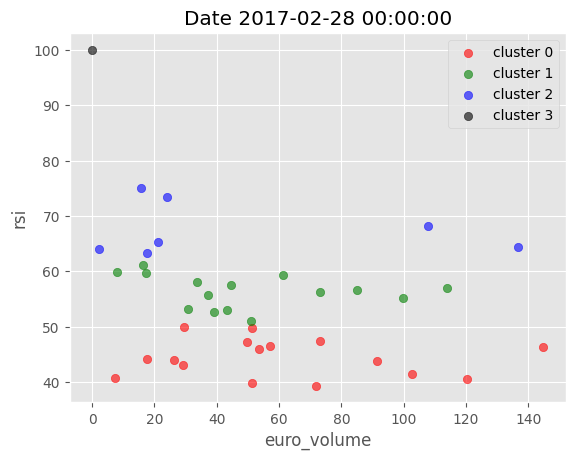

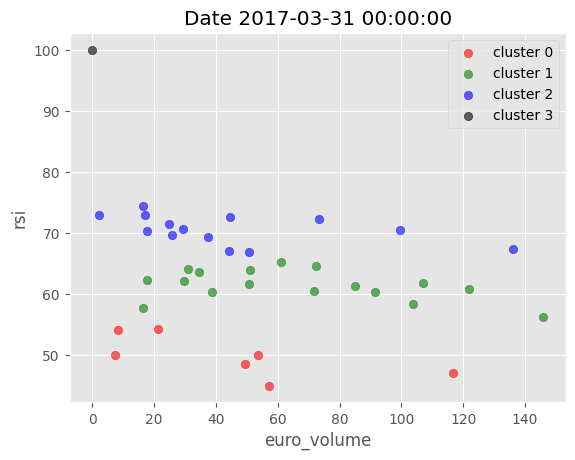

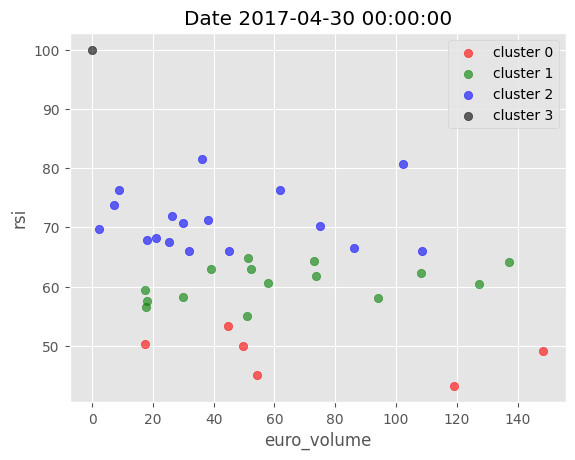

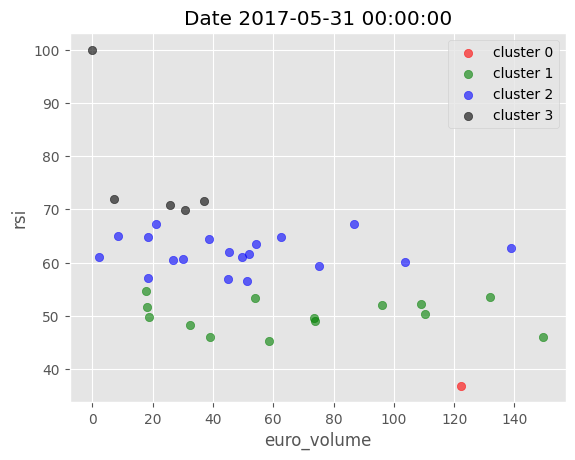

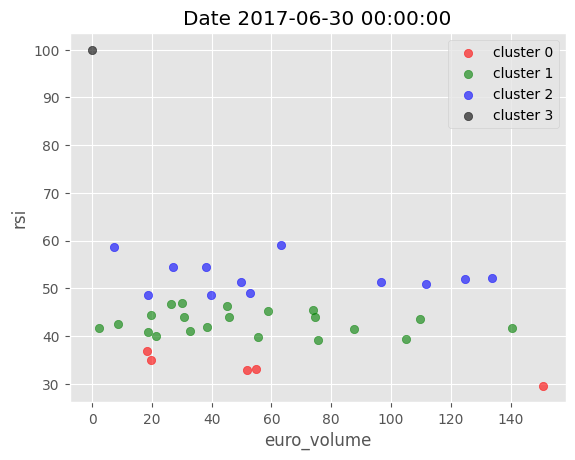

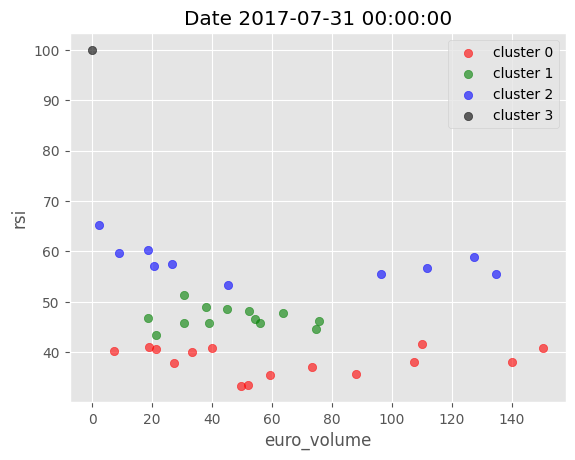

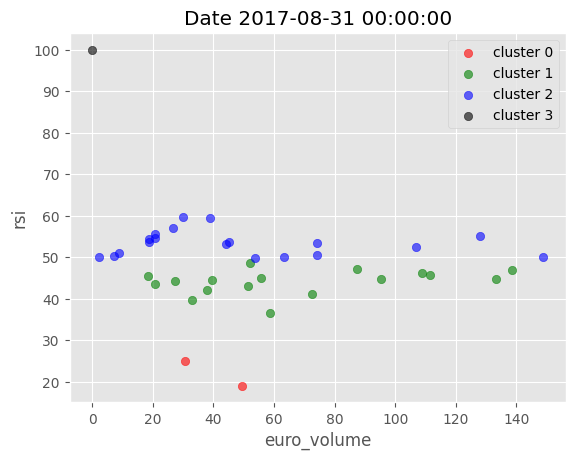

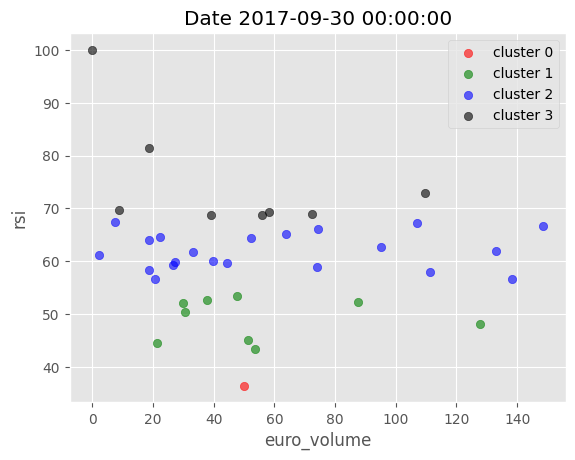

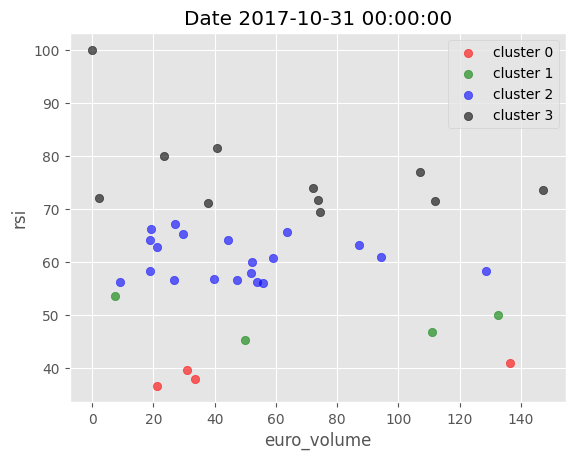

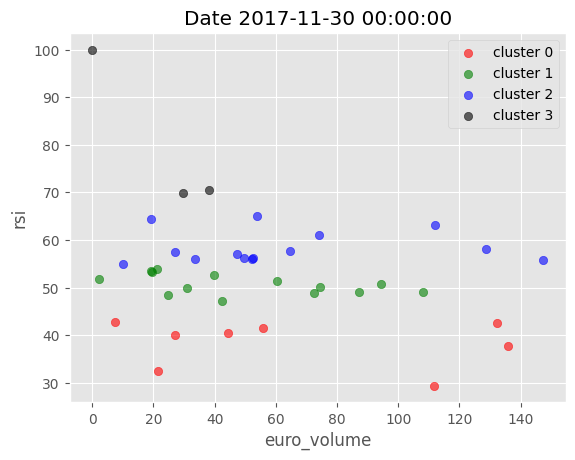

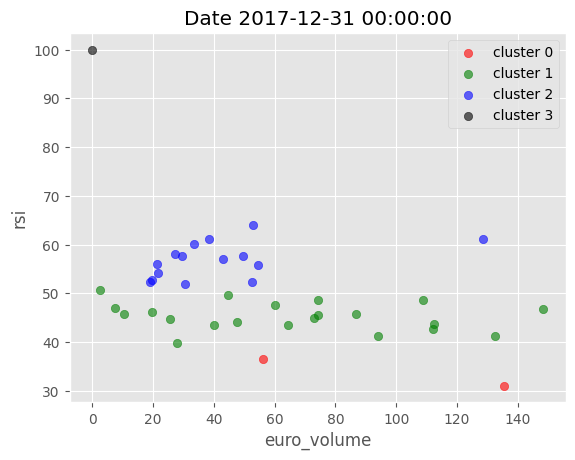

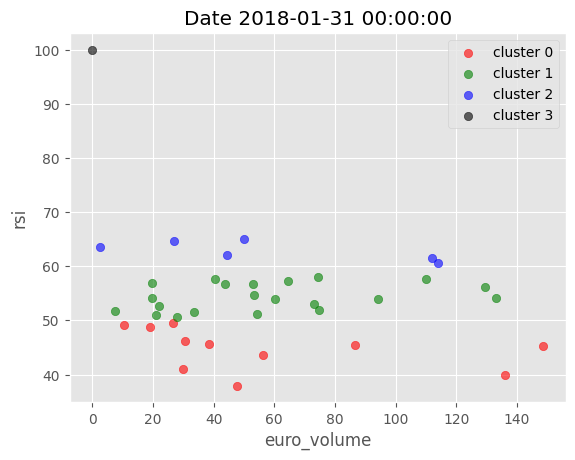

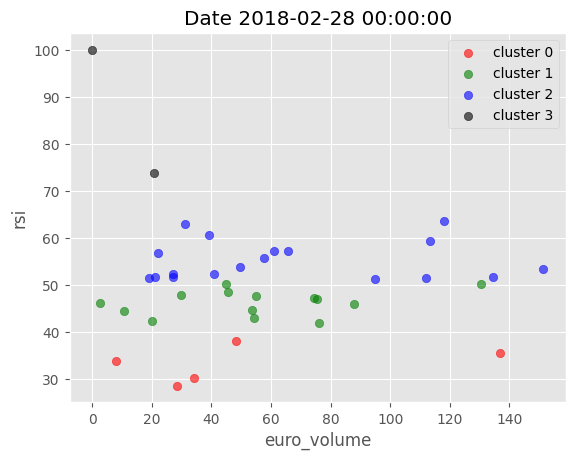

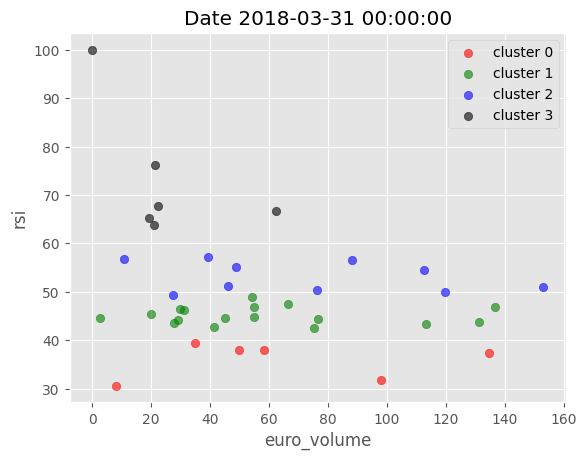

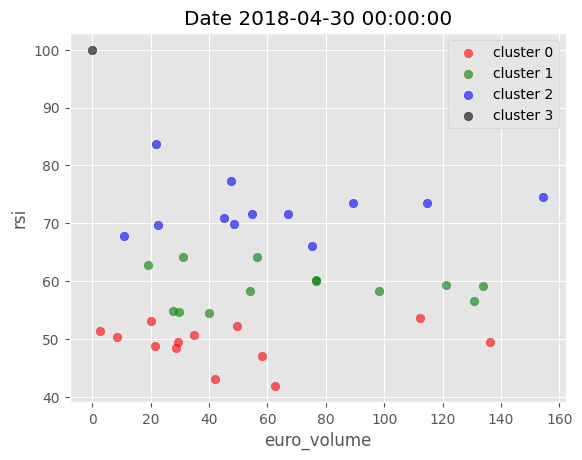

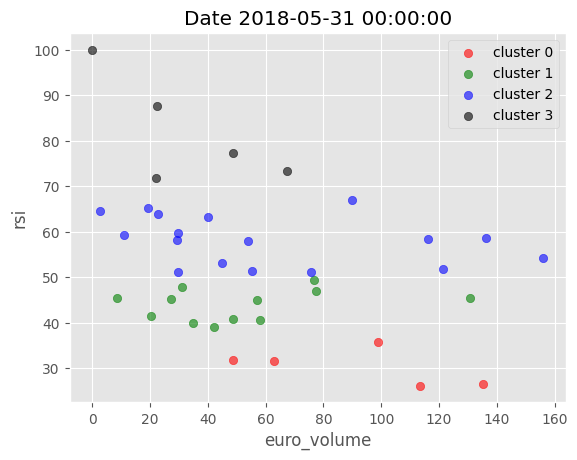

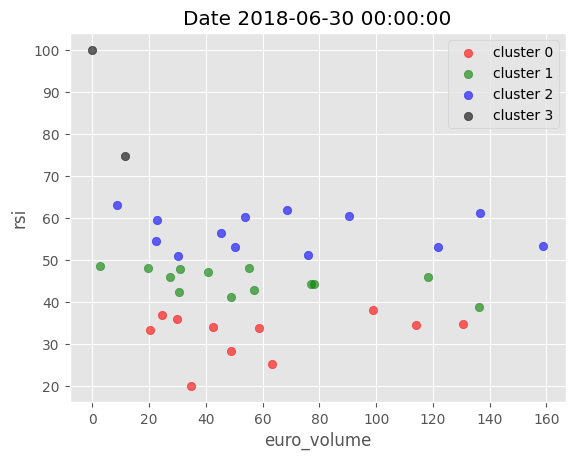

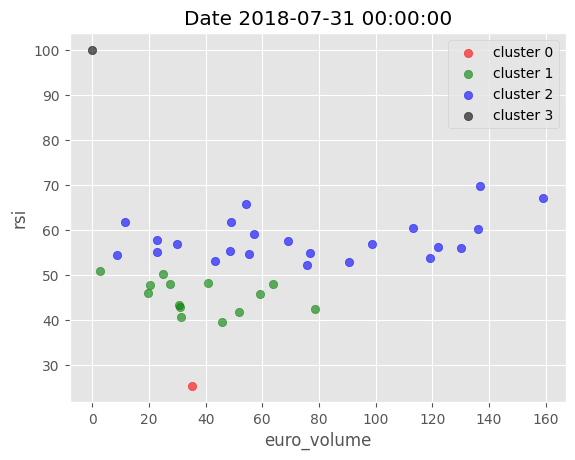

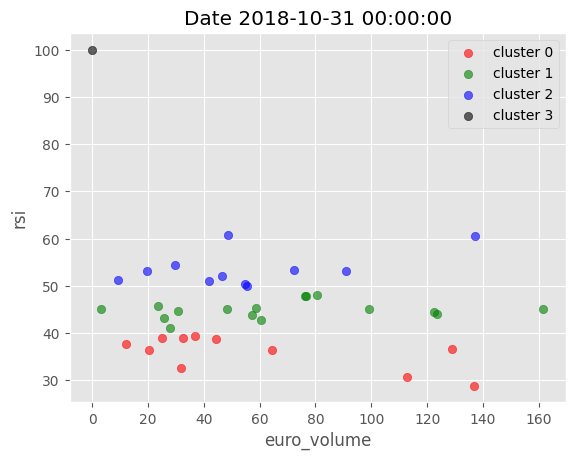

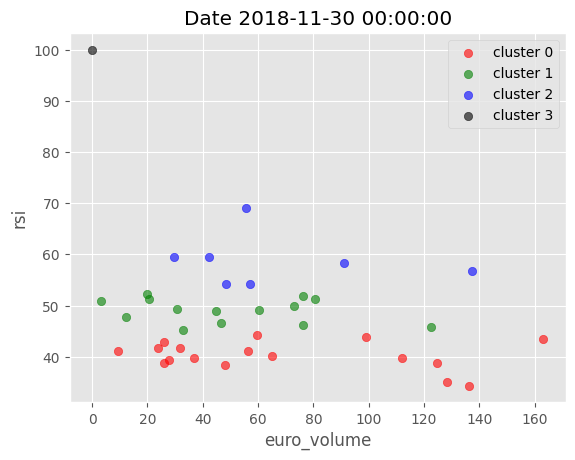

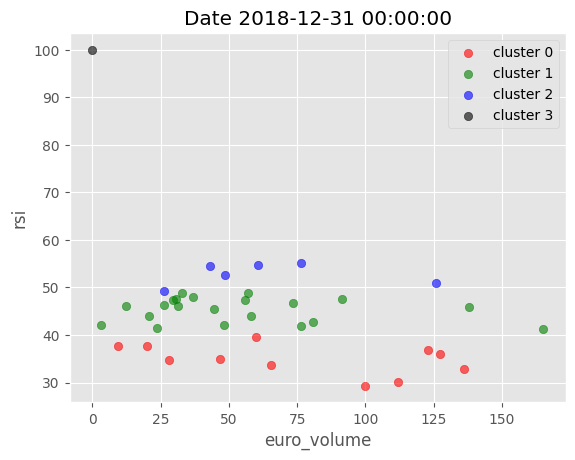

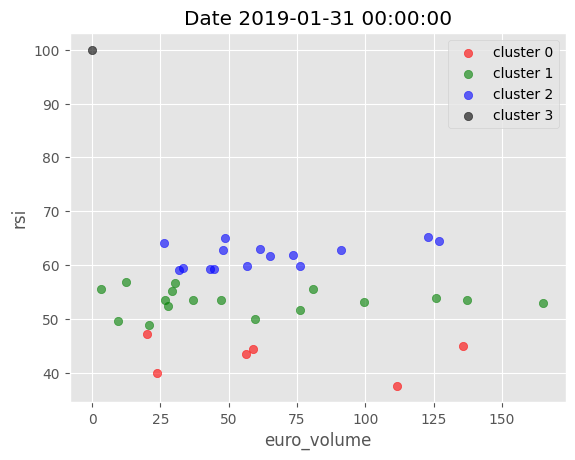

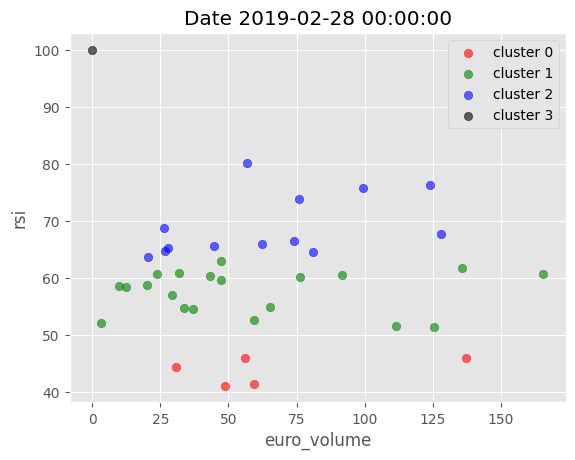

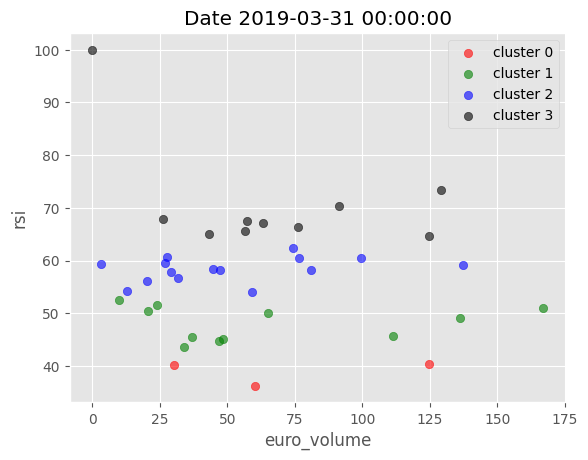

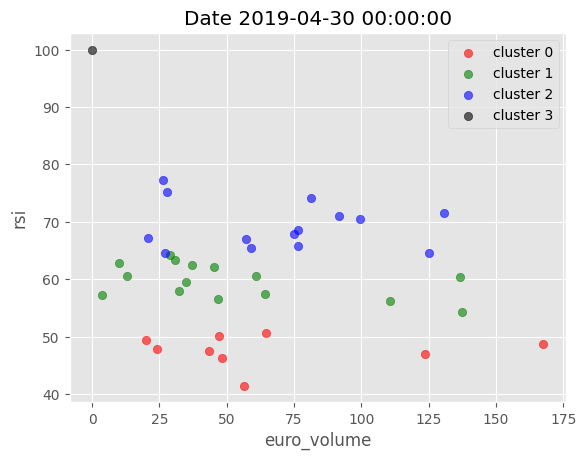

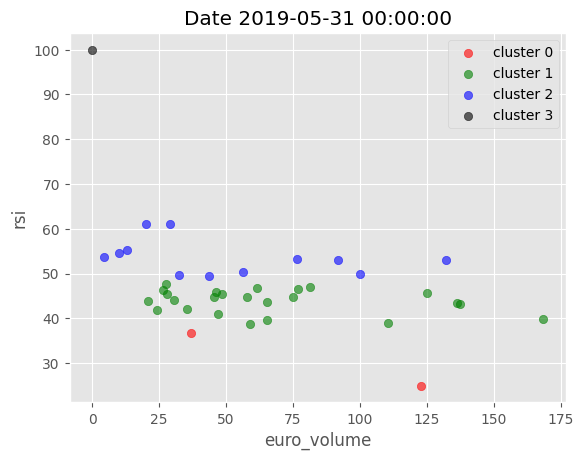

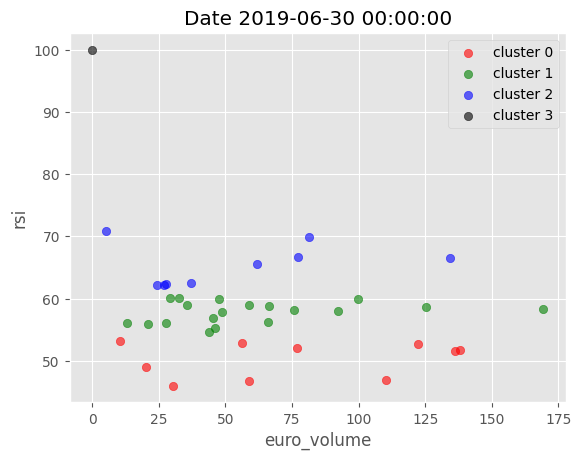

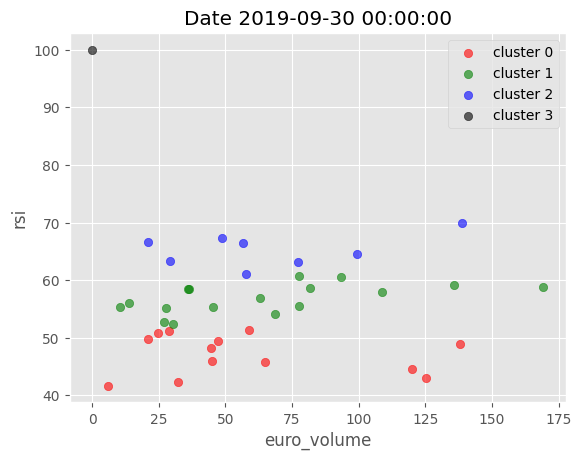

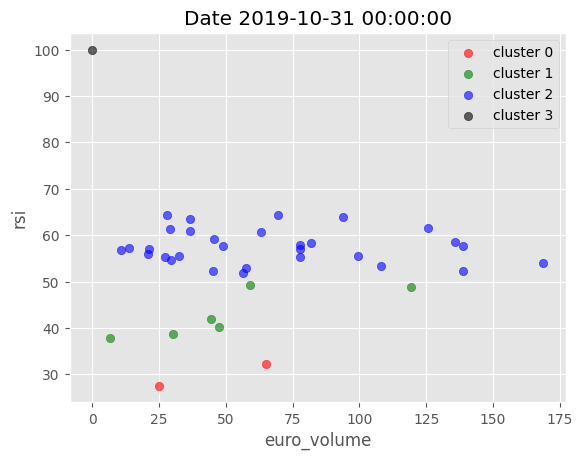

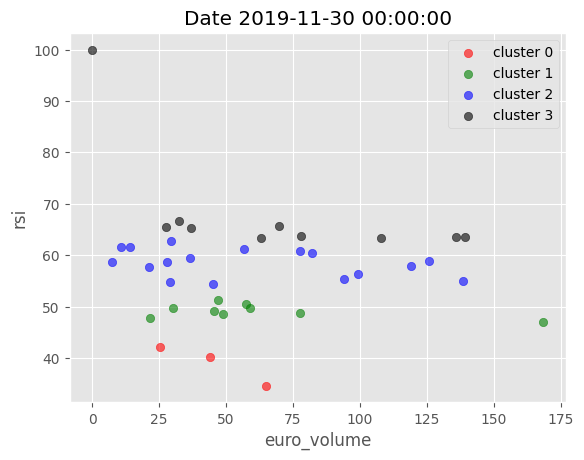

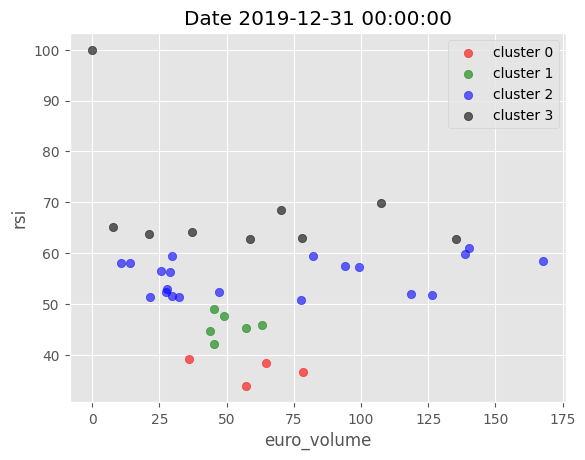

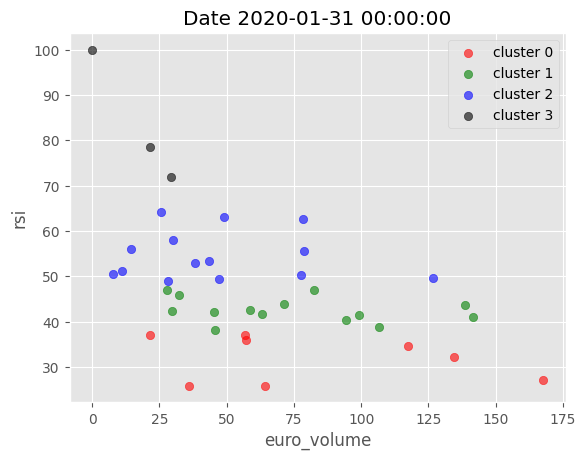

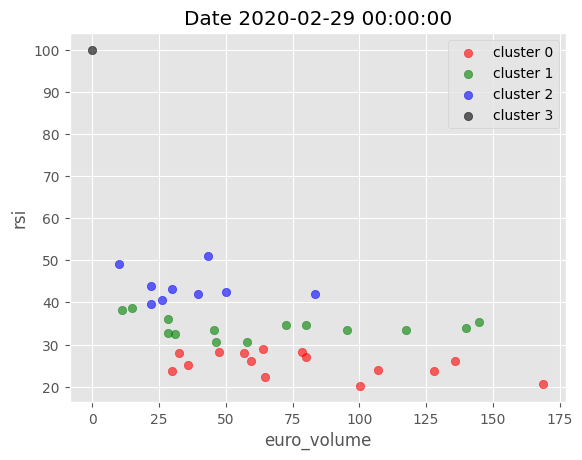

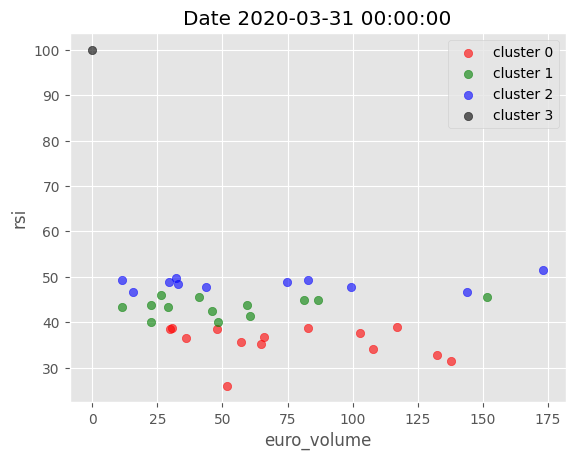

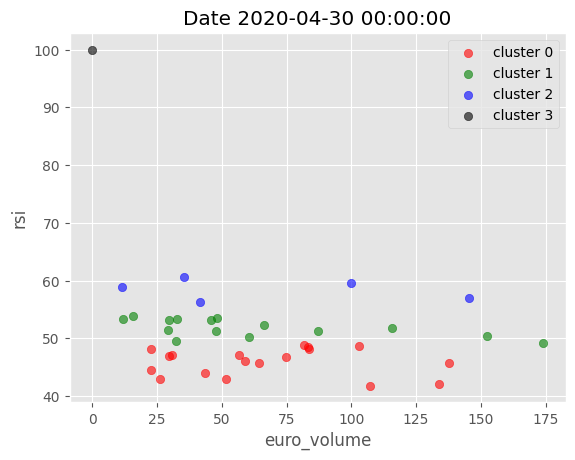

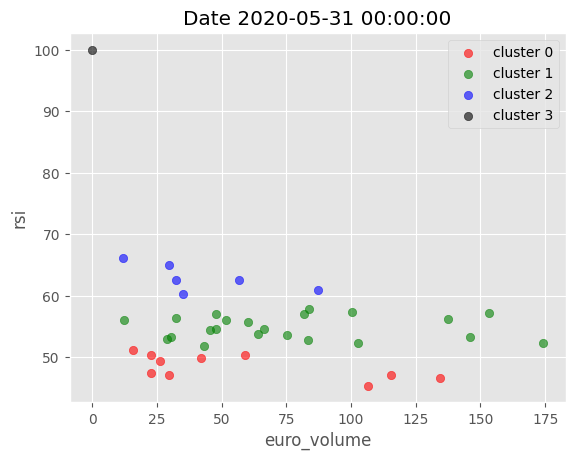

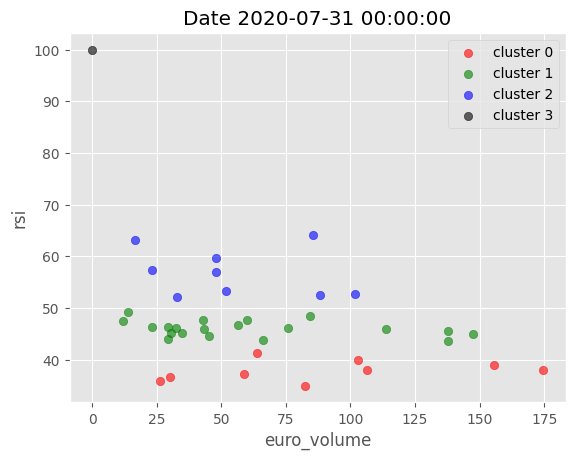

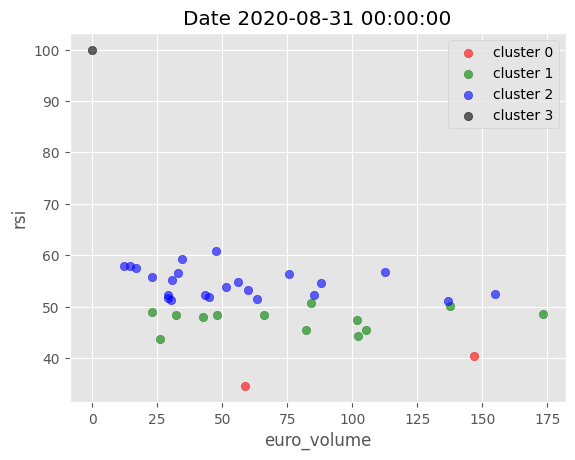

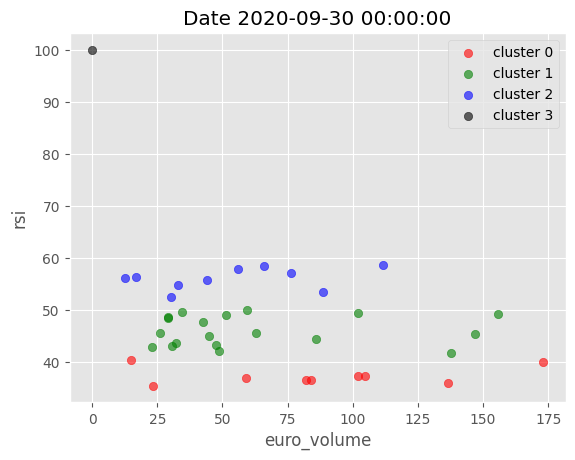

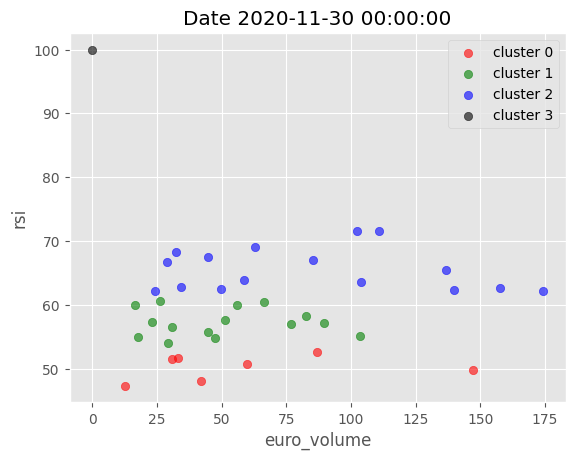

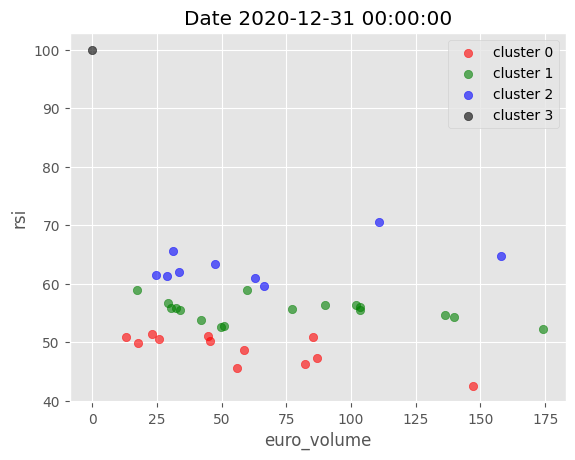

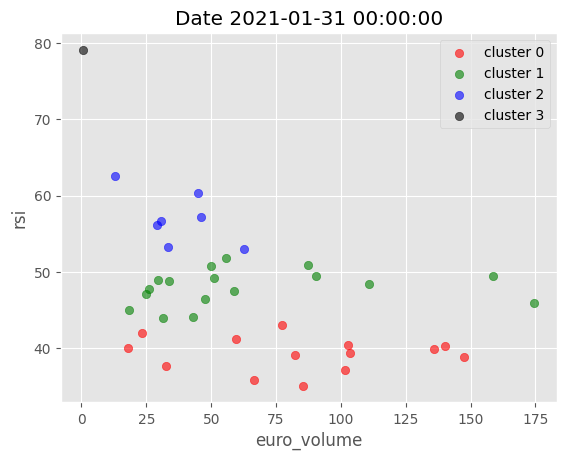

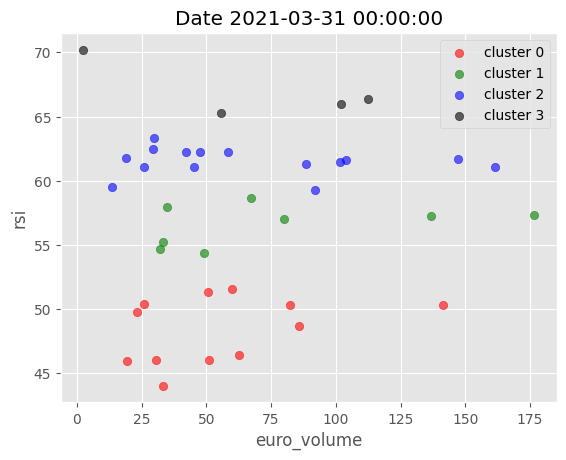

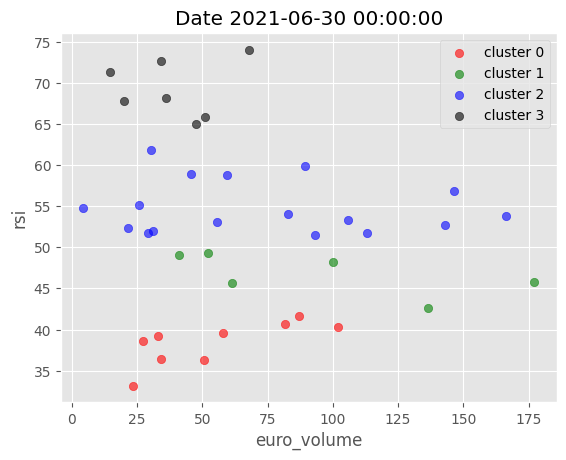

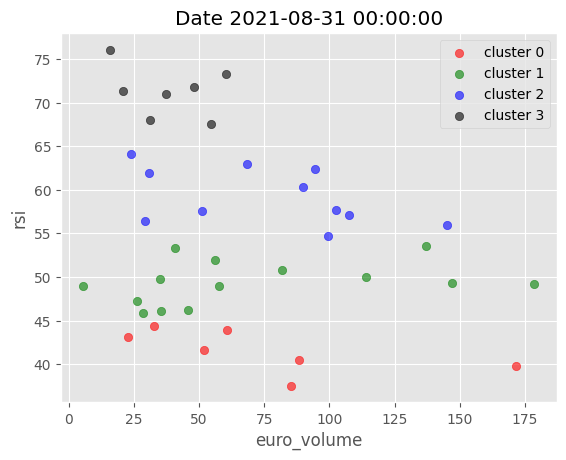

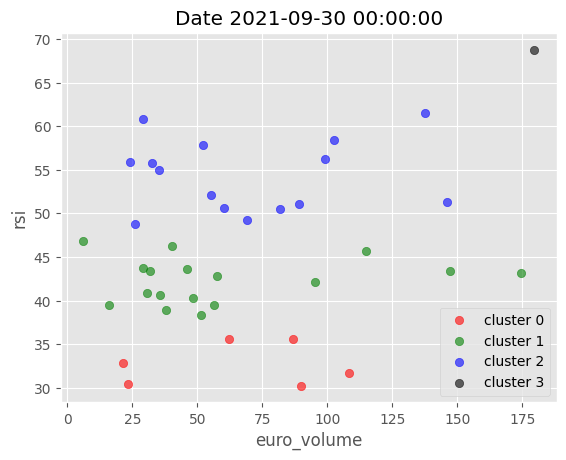

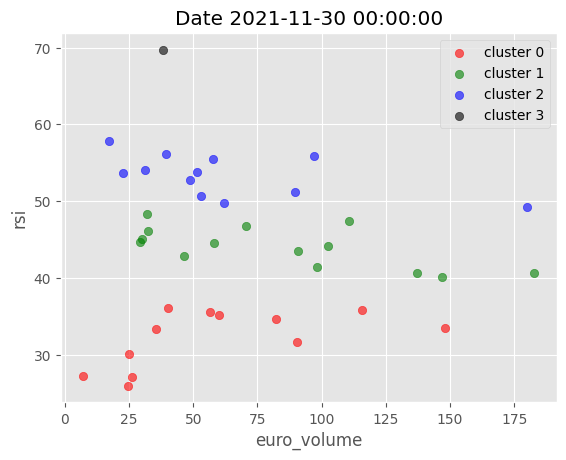

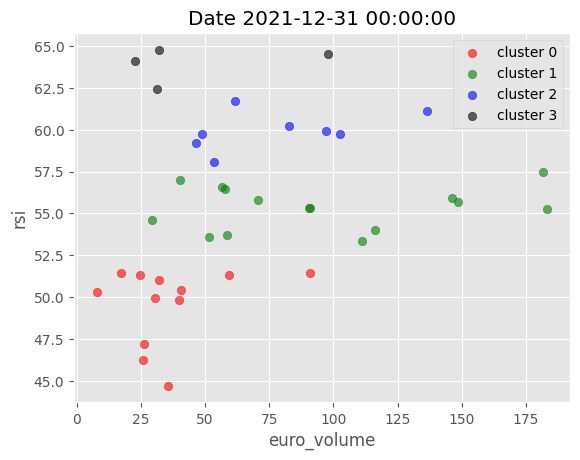

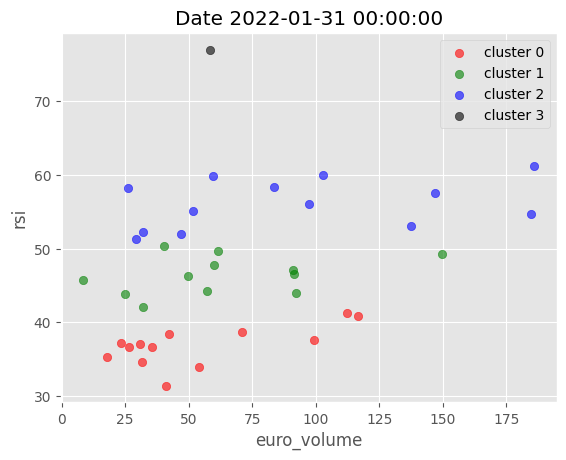

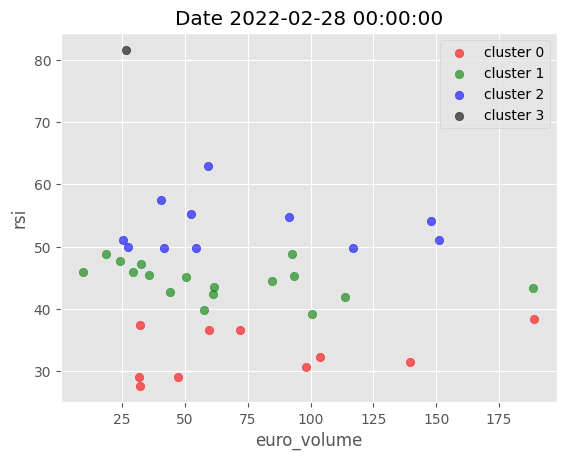

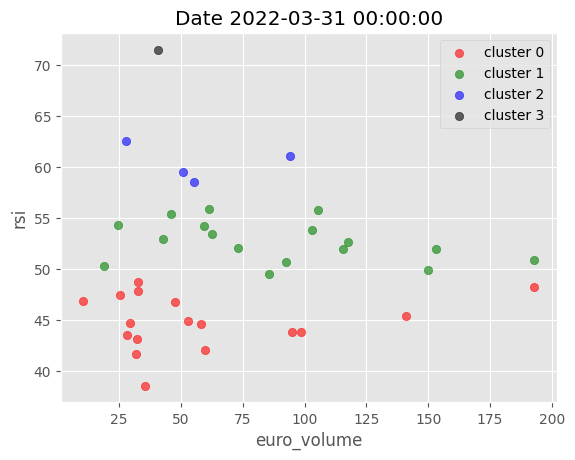

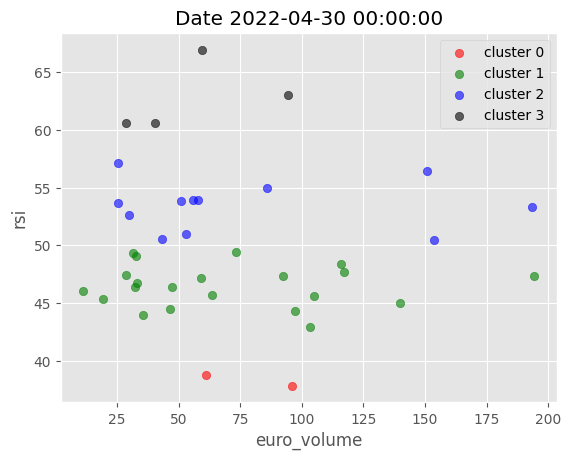

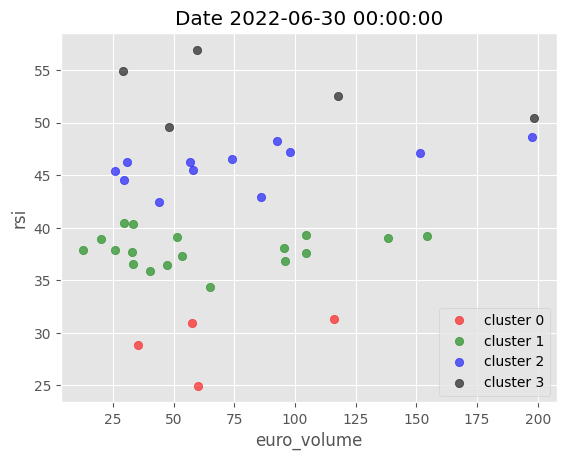

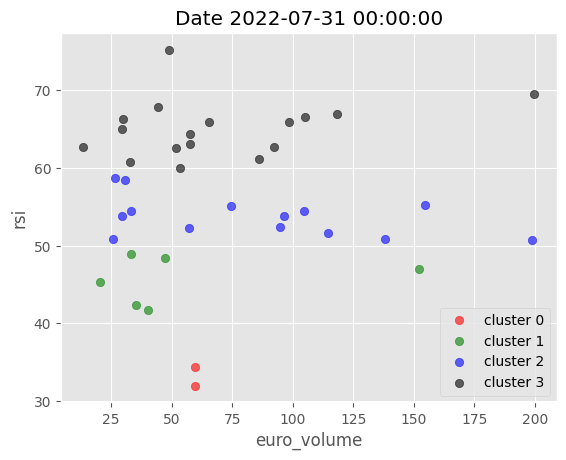

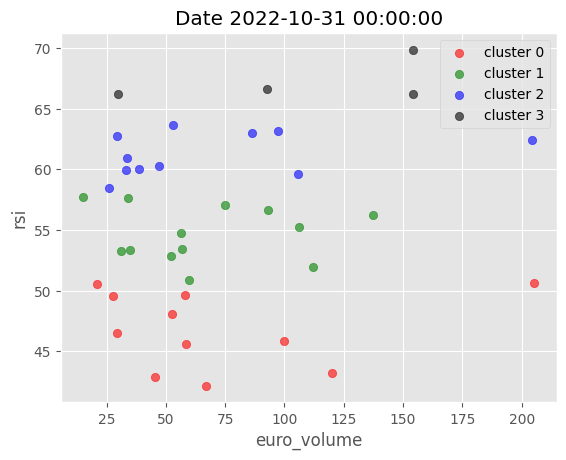

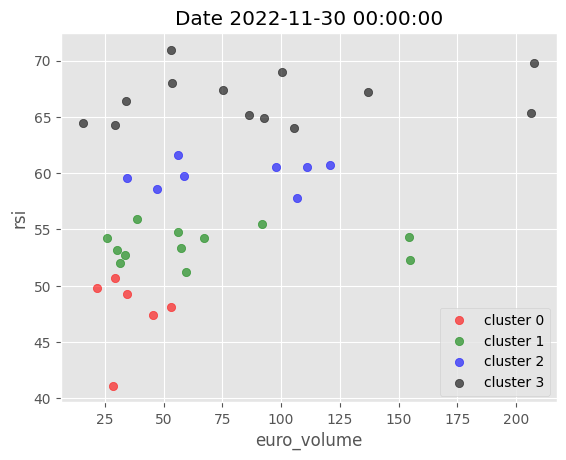

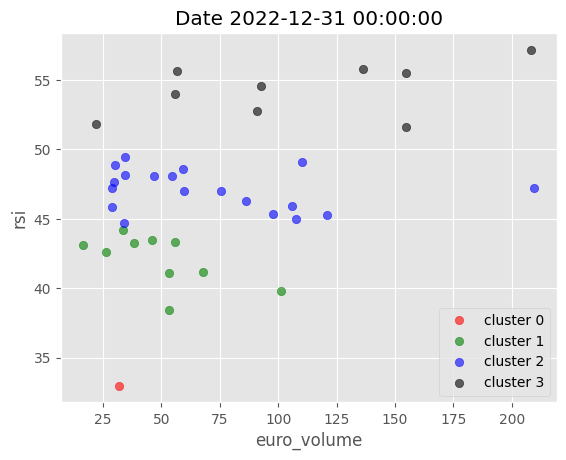

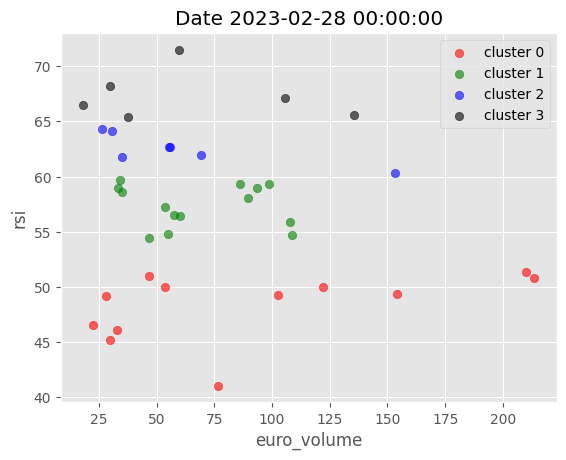

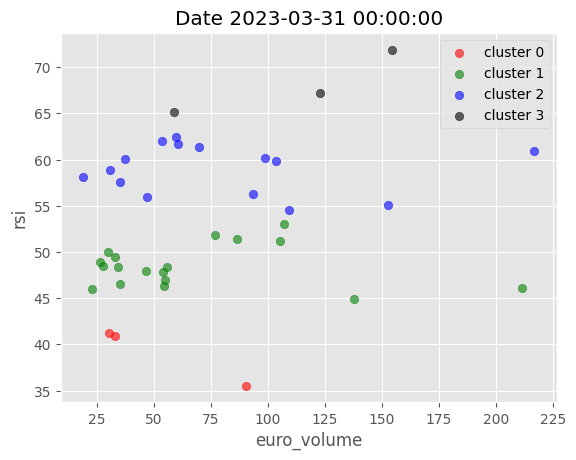

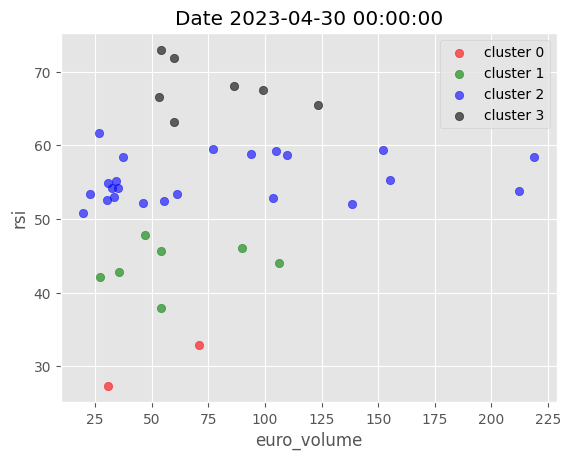

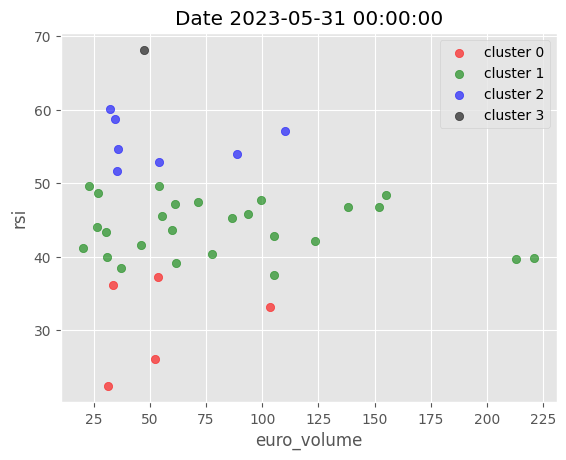

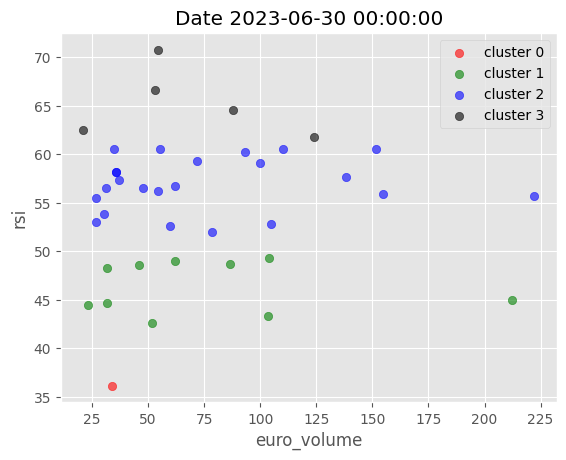

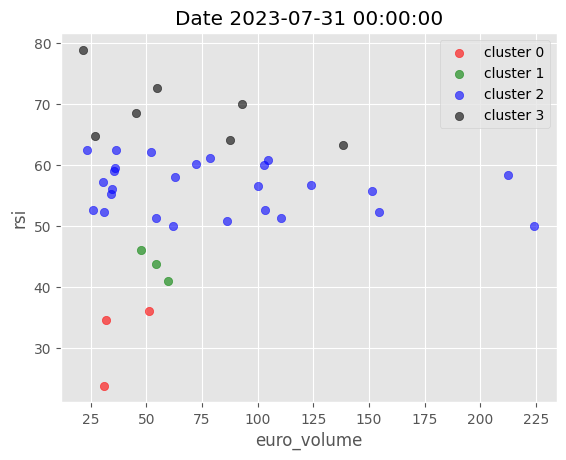

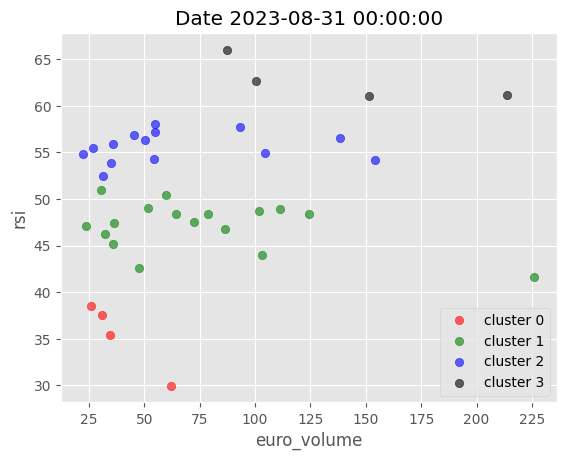

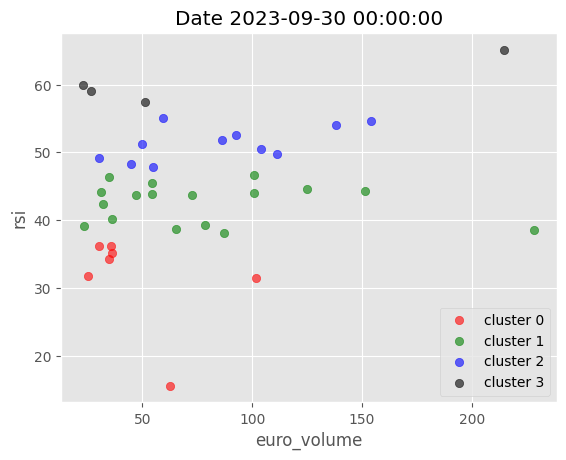

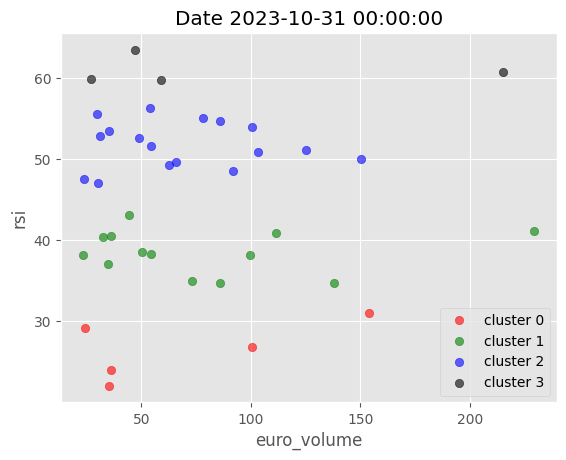

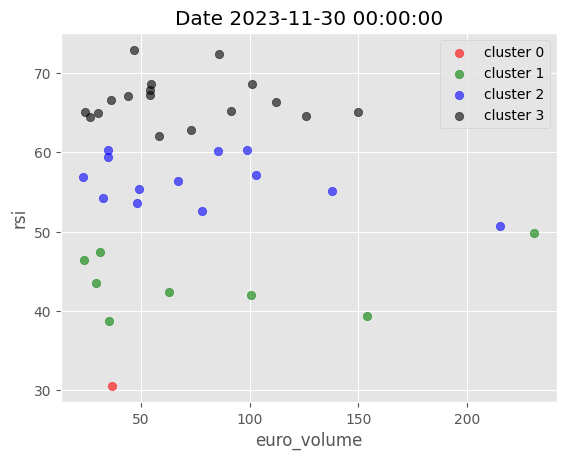

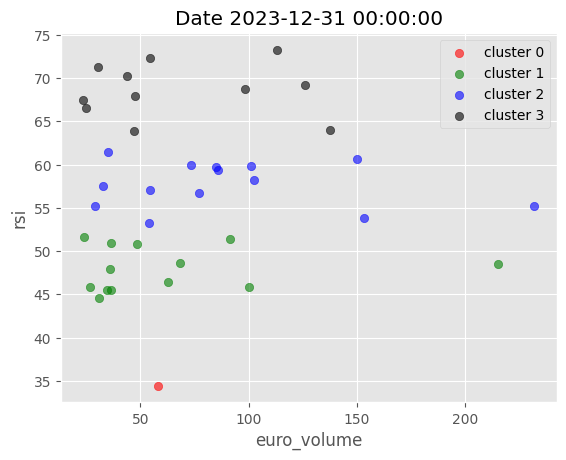

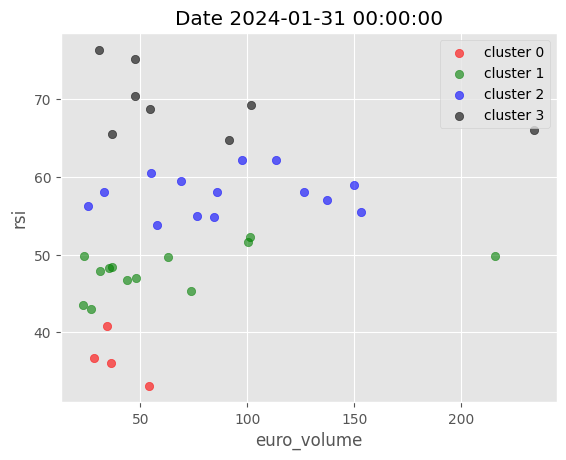

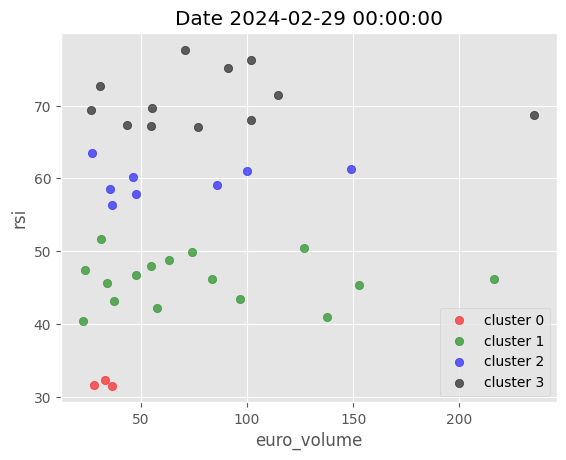

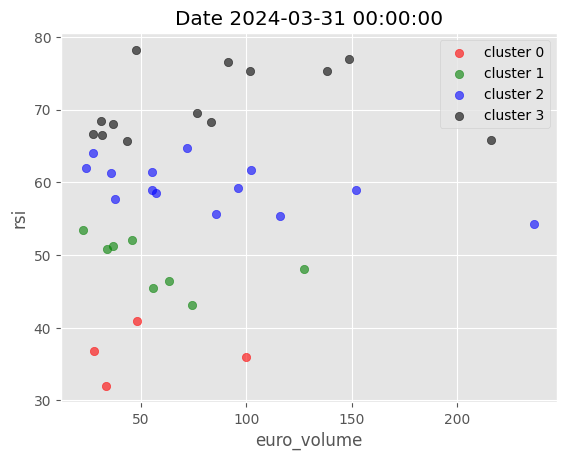

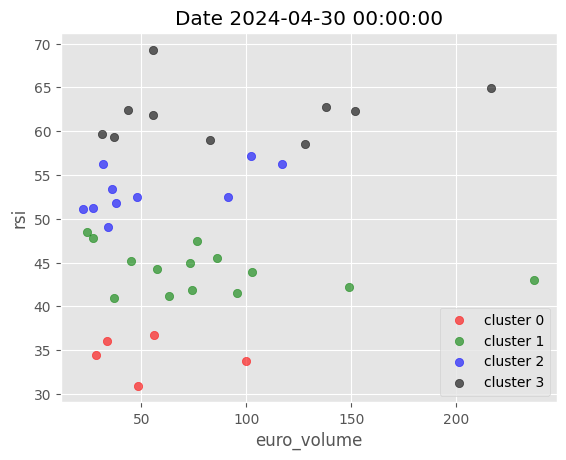

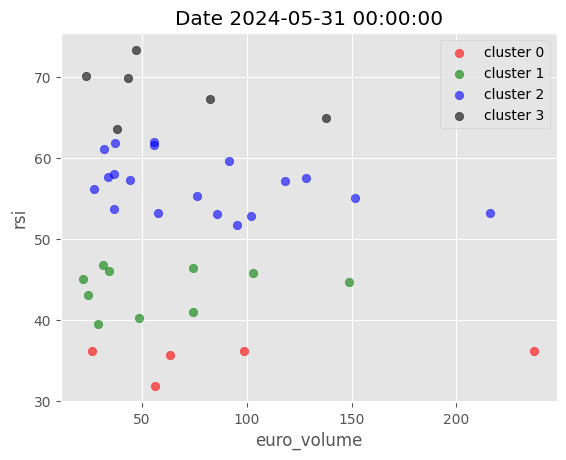

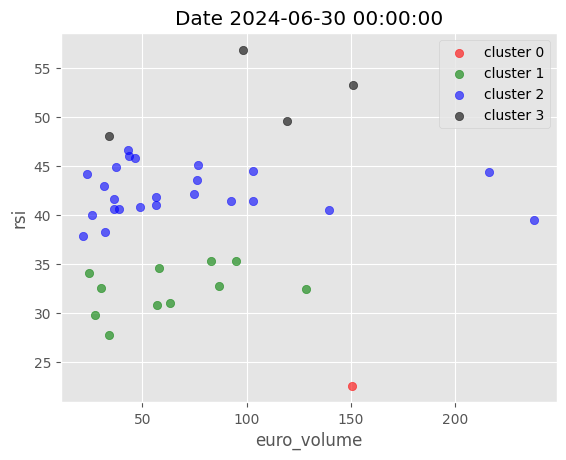

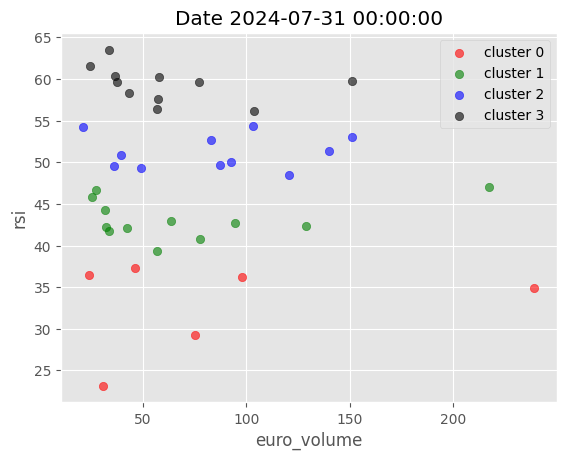

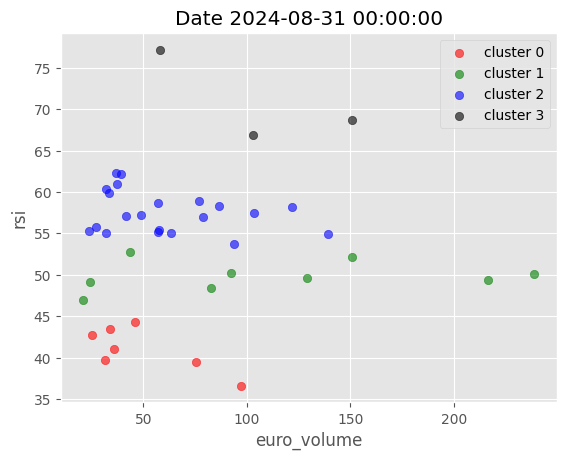

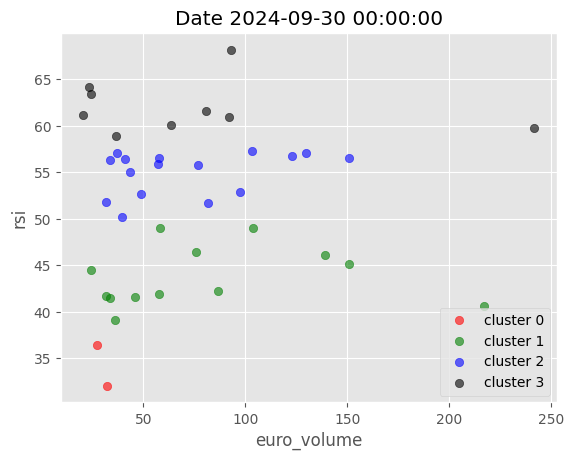

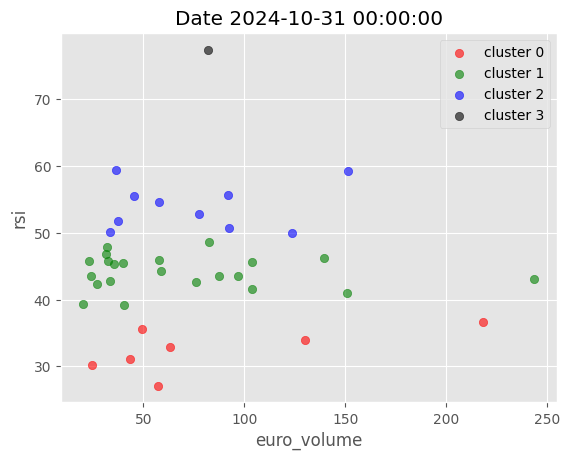

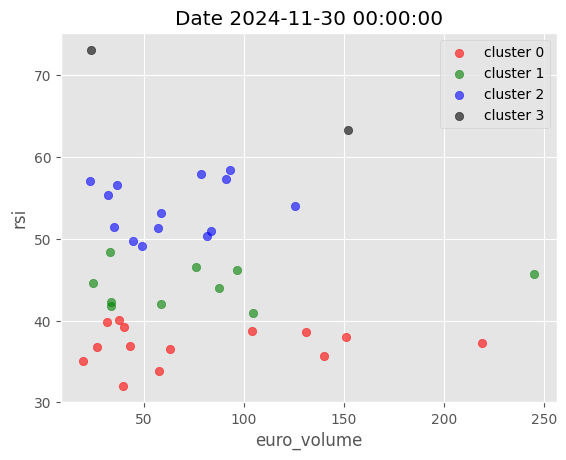

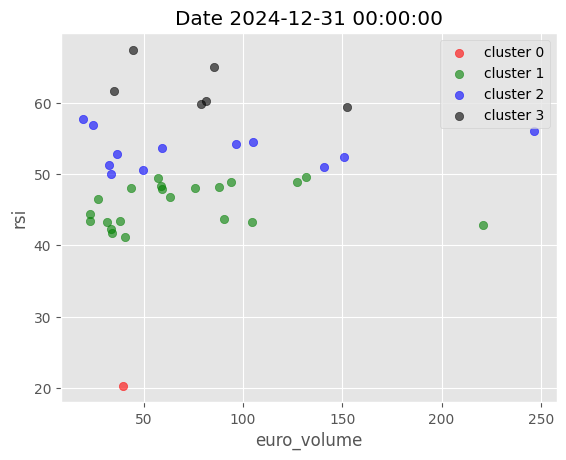

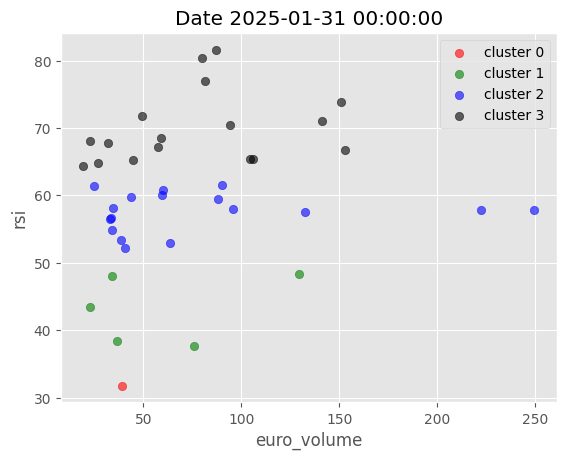

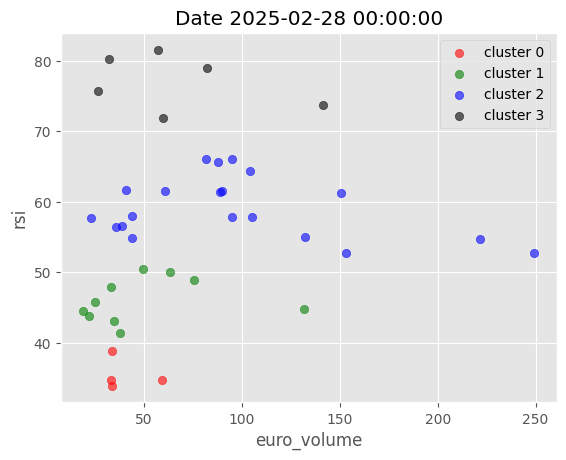

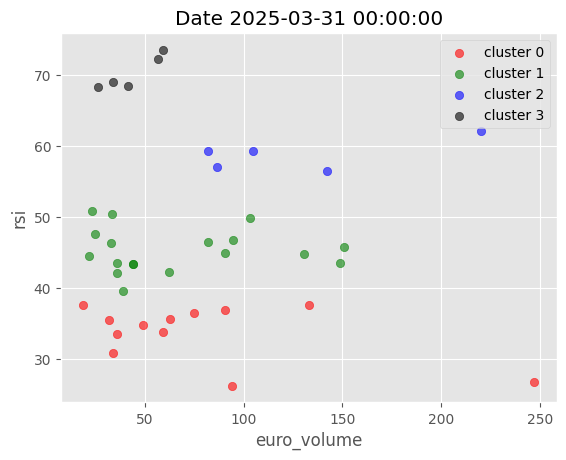

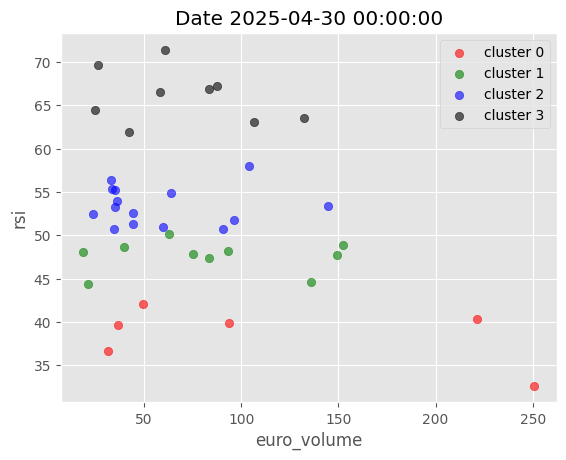

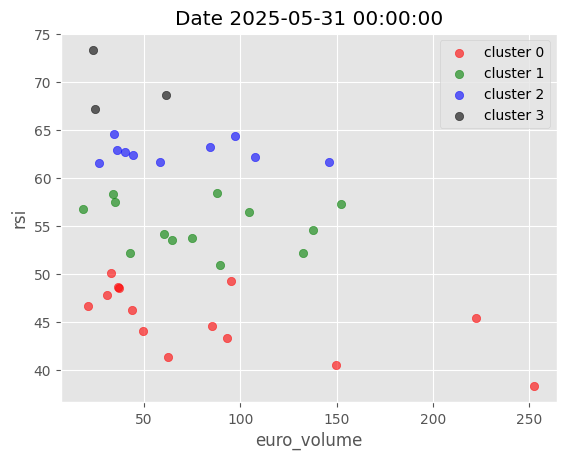

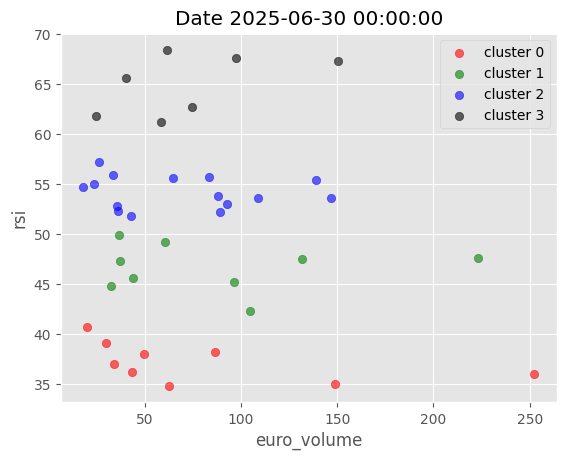

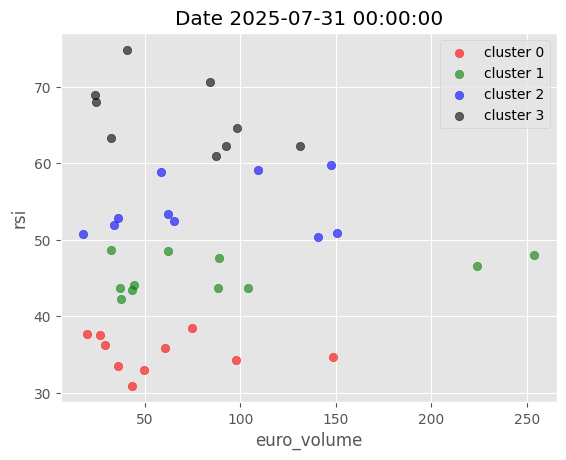

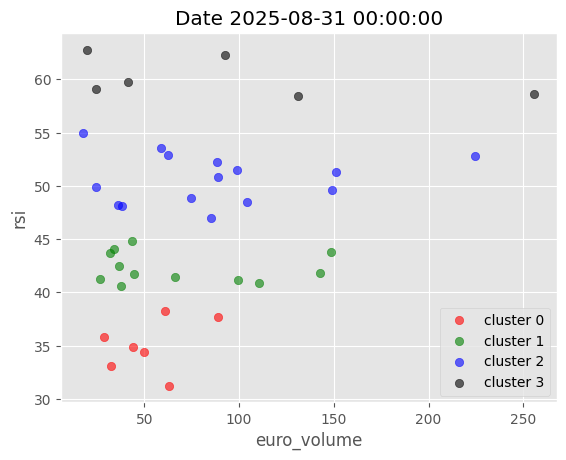

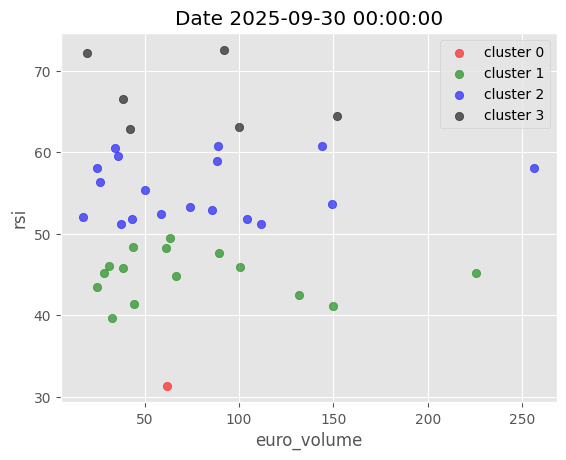

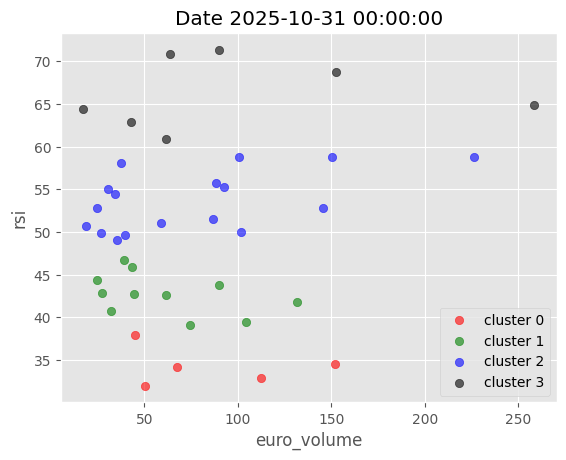

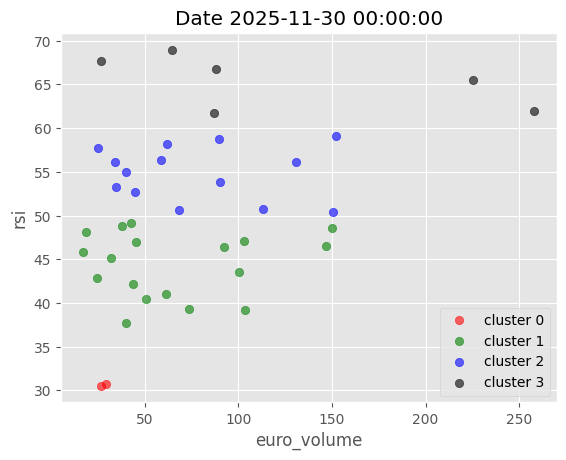

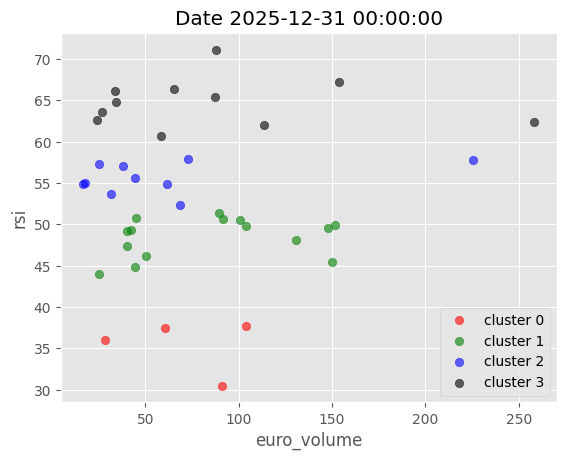

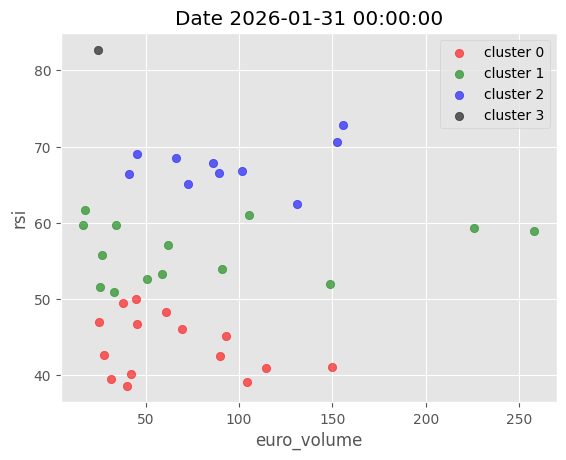

In [28]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')

def plot_clusters(data):
    cluster_0 = data[data['cluster'] == 0]
    cluster_1 = data[data['cluster'] == 1]
    cluster_2 = data[data['cluster'] == 2]
    cluster_3 = data[data['cluster'] == 3]
    
    plt.scatter(cluster_0.iloc[:, 0], cluster_0.iloc[:, 3], color='red', label='cluster 0', alpha=0.6)
    plt.scatter(cluster_1.iloc[:, 0], cluster_1.iloc[:, 3], color='green', label='cluster 1', alpha=0.6)
    plt.scatter(cluster_2.iloc[:, 0], cluster_2.iloc[:, 3], color='blue', label='cluster 2', alpha=0.6)
    plt.scatter(cluster_3.iloc[:, 0], cluster_3.iloc[:, 3], color='black', label='cluster 3', alpha=0.6)
    
    plt.xlabel(data.columns[0])  # Nom de la colonne X
    plt.ylabel(data.columns[3])  # Nom de la colonne Y (RSI)
    plt.legend()
    plt.show()

# Plot pour chaque date
for i in data.index.get_level_values('date').unique().tolist():
    g = data.xs(i, level=0)
    plt.title(f'Date {i}')
    plot_clusters(g)


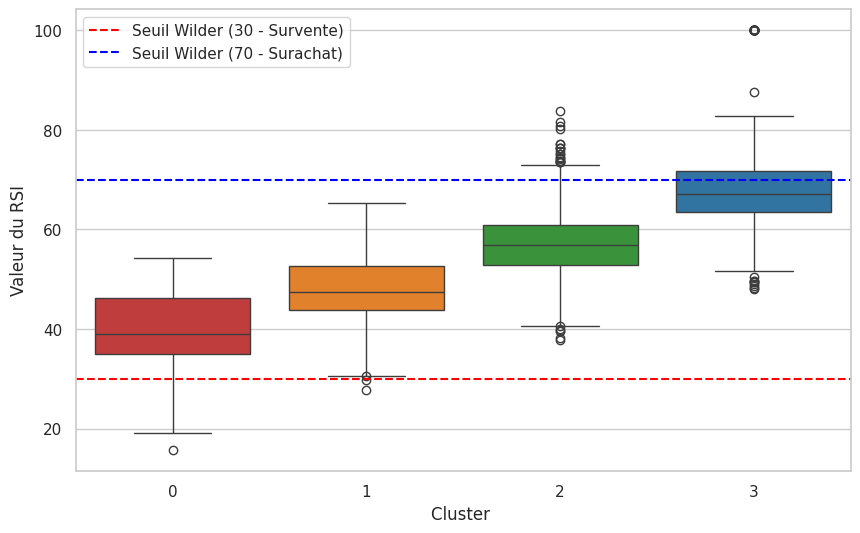

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. On s'assure d'utiliser le style "whitegrid" pour la lisibilité académique
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# 2. Définition des couleurs qui ont du sens financier
# 0 = Rouge (RSI bas / Survente)
# 1 = Orange
# 2 = Vert
# 3 = Bleu (RSI haut / Surachat)
my_pal = ["#d62728", "#ff7f0e", "#2ca02c", "#1f77b4"]

# 3. Création du Boxplot

sns.boxplot(x='cluster', y='rsi', data=data, palette=my_pal)

# 4. Ajout des seuils de Wilder 
plt.axhline(30, color='red', linestyle='--', linewidth=1.5, label='Seuil Wilder (30 - Survente)')
plt.axhline(70, color='blue', linestyle='--', linewidth=1.5, label='Seuil Wilder (70 - Surachat)')

# 5. Titres et Labels pour le mémoire
#plt.title('Distribution des valeurs RSI par Cluster (Validation K-Means)', fontsize=14, fontweight='bold')
plt.xlabel('Cluster ', fontsize=12)
plt.ylabel('Valeur du RSI', fontsize=12)
plt.legend(loc='upper left') 

plt.show()

## Prédiction supervisée : ML 

## XGBoost 


 DÉMARRAGE DU MODULE DE PRÉDICTION (XGBOOST)
Objectif : Prédire si le rendement du mois SUIVANT sera positif.

 Étape 1 : Création des variables retardées (Lags)...
⚠️ Attention : Pas de colonne 'Ticker' détectée. Lag appliqué globalement.
✅ 2 variables ont été décalées (t-1).

 Étape 2 : Construction de la Target (Vision Future)...
Répartition : Baisse=1923 | Hausse=2310 (Ratio: 0.83)

🧹 Étape 3 : Sélection des variables et nettoyage...
✅ Dataset prêt. Dimensions : (4231, 11)
   Features utilisées : ['rsi', 'macd', 'bb_low', 'bb_high', 'atr', 'return_2m', 'return_3m', 'return_6m', 'cluster', 'euro_volume_lag1', 'garman_klass_vol_lag1']

 Split Temporel (80/20) :
   Train : 3384 échantillons
   Test  : 847 échantillons

 Étape 4 : Entraînement du modèle XGBoost...
✅ Entraînement terminé (Meilleure itération : 124)

 RÉSULTATS ET MÉTRIQUES
 AUC Score (Test) : 0.6008
 Accuracy (Test)  : 58.09%
✅ CONCLUSION : Le modèle a un pouvoir prédictif (Alpha).

 Rapport de Classification :
       

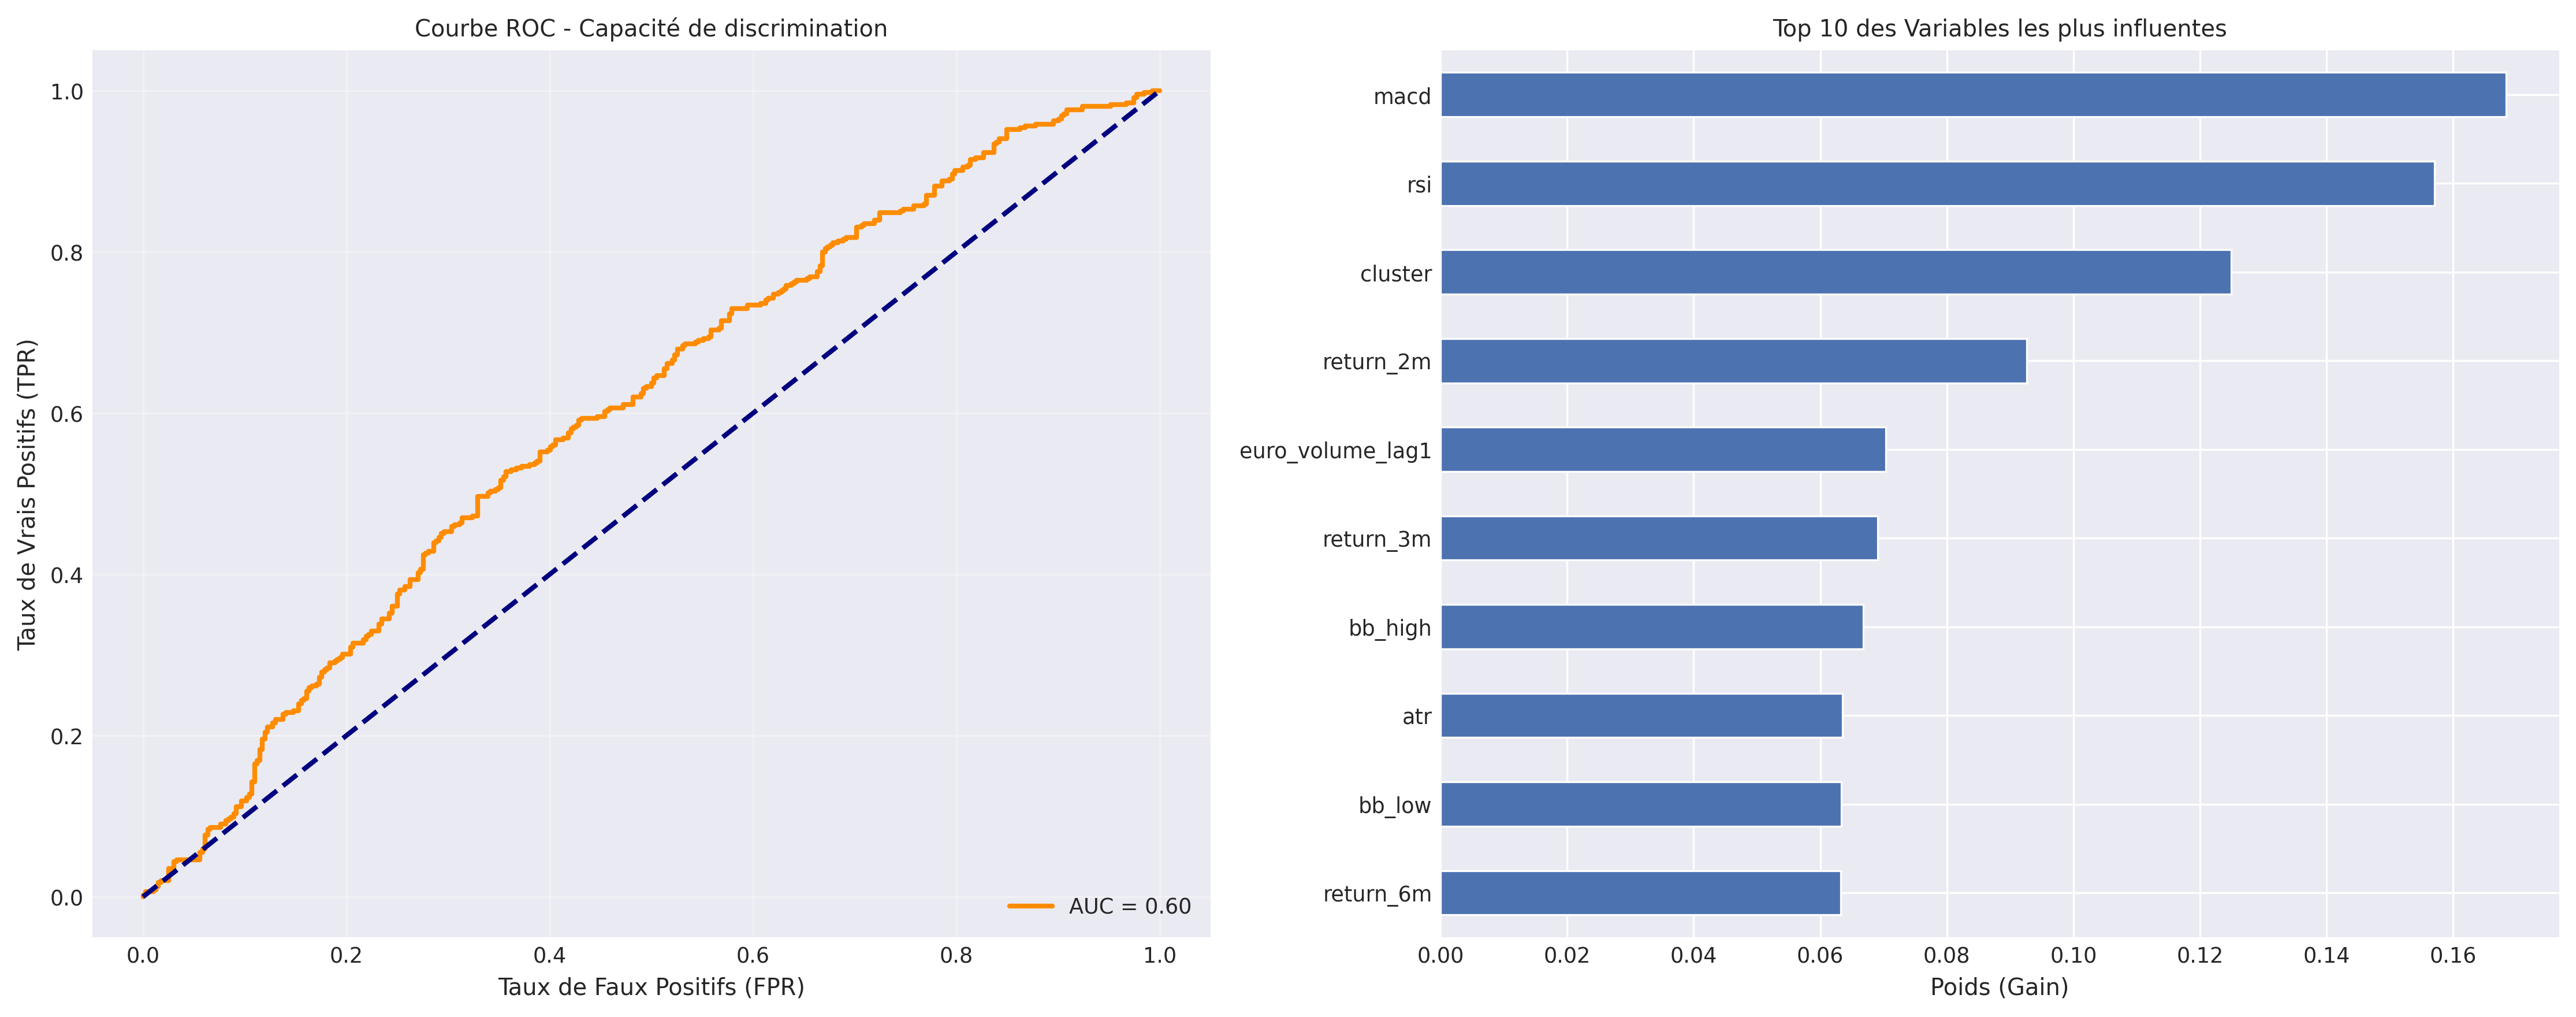

In [81]:
# =============================================================================
# XGBOOST CLASSIFICATION - PRÉDICTION DE LA DIRECTION (T+1)
# =============================================================================
print("\n" + "="*80)
print(" DÉMARRAGE DU MODULE DE PRÉDICTION (XGBOOST)")
print("Objectif : Prédire si le rendement du mois SUIVANT sera positif.")
print("="*80)

from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# On travaille sur une copie pour ne pas casser le dataset original
ml_data = data.copy()

# =============================================================================
# 1. INGÉNIERIE DES FEATURES (LAG & MACRO)
# =============================================================================
print("\n Étape 1 : Création des variables retardées (Lags)...")

# Liste des candidats potentiels au décalage (Macro + Volume)
# On ne retient QUE ceux qui sont présents dans vos données pour éviter le KeyError
potential_lags = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'euro_volume', 'garman_klass_vol']
vars_to_lag = [col for col in potential_lags if col in ml_data.columns]

# Détection automatique de la structure (MultiIndex ou colonne Ticker simple)
if 'Ticker' in ml_data.index.names:
    group_obj = ml_data.groupby(level='Ticker')
elif 'Ticker' in ml_data.columns:
    group_obj = ml_data.groupby('Ticker')
else:
    # Cas de secours (si un seul actif ou structure plate)
    group_obj = None 
    print("⚠️ Attention : Pas de colonne 'Ticker' détectée. Lag appliqué globalement.")

# Application du décalage (t-1)
# Pourquoi ? Car au moment de la décision d'investissement, on ne connait que le passé.
for col in vars_to_lag:
    new_col_name = f'{col}_lag1'
    if group_obj is not None:
        ml_data[new_col_name] = group_obj[col].shift(1)
    else:
        ml_data[new_col_name] = ml_data[col].shift(1)

print(f"✅ {len(vars_to_lag)} variables ont été décalées (t-1).")

# =============================================================================
# 2. CRÉATION DE LA CIBLE (TARGET)
# =============================================================================
print(f"\n Étape 2 : Construction de la Target (Vision Future)...")

# On veut prédire le rendement de demain. On décale 'return_1m' vers le haut (-1).
if group_obj is not None:
    ml_data['future_return'] = group_obj['return_1m'].shift(-1)
else:
    ml_data['future_return'] = ml_data['return_1m'].shift(-1)

# Définition de la classe binaire : 1 si Hausse, 0 si Baisse
ml_data['target_direction'] = (ml_data['future_return'] > 0).astype(int)

# Vérification de l'équilibre des classes
counts = ml_data['target_direction'].value_counts()
imbalance_ratio = counts[0] / counts[1]
print(f"Répartition : Baisse={counts[0]} | Hausse={counts[1]} (Ratio: {imbalance_ratio:.2f})")

# =============================================================================
# 3. SÉLECTION DES FEATURES ET NETTOYAGE
# =============================================================================
print(f"\n🧹 Étape 3 : Sélection des variables et nettoyage...")

# Liste de base (Analyse Technique)
features_base = [
    'rsi', 'macd', 'bb_low', 'bb_high', 'atr', 
    'return_2m', 'return_3m', 'return_6m', 'cluster'
]

# On ajoute dynamiquement les Lags qu'on a réussi à créer plus haut
features_lags = [f'{col}_lag1' for col in vars_to_lag]

# Liste FINALE des X (Variables explicatives)
feature_cols = features_base + features_lags

# Vérification ultime : On ne garde que les colonnes qui existent vraiment
feature_cols = [c for c in feature_cols if c in ml_data.columns]

# Suppression des NaNs (Lags au début, Target à la fin)
ml_data_clean = ml_data.dropna(subset=feature_cols + ['future_return']).copy()

X = ml_data_clean[feature_cols]
y = ml_data_clean['target_direction']

print(f"✅ Dataset prêt. Dimensions : {X.shape}")
print(f"   Features utilisées : {feature_cols}")

# =============================================================================
# 4. SPLIT TRAIN / TEST (TEMPOREL)
# =============================================================================
# Important : On ne mélange pas (shuffle=False) pour respecter la chronologie
split_point = int(len(X) * 0.8)

X_train, X_test = X.iloc[:split_point], X.iloc[split_point:]
y_train, y_test = y.iloc[:split_point], y.iloc[split_point:]

print(f"\n Split Temporel (80/20) :")
print(f"   Train : {len(X_train)} échantillons")
print(f"   Test  : {len(X_test)} échantillons")

# =============================================================================
# 5. ENTRAÎNEMENT DU MODÈLE XGBOOST
# =============================================================================
print(f"\n Étape 4 : Entraînement du modèle XGBoost...")

# Configuration des hyperparamètres pour éviter l'overfitting
xgb_clf = XGBClassifier(
    n_estimators=500,        # Nombre d'arbres max
    max_depth=4,             # Arbres peu profonds (meilleure généralisation)
    learning_rate=0.02,      # Apprentissage lent et progressif
    subsample=0.7,           # Utilise seulement 70% des données par arbre
    colsample_bytree=0.7,    # Utilise seulement 70% des features par arbre
    scale_pos_weight=imbalance_ratio, # Gestion du déséquilibre de classes
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=50, # Arrêt si pas d'amélioration après 50 itérations
    eval_metric='auc'
)

# Fit avec validation sur le jeu de test pour le early_stopping
xgb_clf.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

print(f"✅ Entraînement terminé (Meilleure itération : {xgb_clf.best_iteration})")

# =============================================================================
# 6. ÉVALUATION ET INTERPRÉTATION
# =============================================================================
print("\n" + "="*80)
print(" RÉSULTATS ET MÉTRIQUES")
print("="*80)

# Prédictions
y_pred_proba = xgb_clf.predict_proba(X_test)[:, 1]
y_pred_class = xgb_clf.predict(X_test)

# Calcul des scores
auc_score = roc_auc_score(y_test, y_pred_proba)
acc_score = (y_pred_class == y_test).mean()

print(f" AUC Score (Test) : {auc_score:.4f}")
print(f" Accuracy (Test)  : {acc_score*100:.2f}%")

# Interprétation automatique pour le mémoire
if auc_score > 0.53:
    print("✅ CONCLUSION : Le modèle a un pouvoir prédictif (Alpha).")
elif auc_score > 0.50:
    print("⚠️ CONCLUSION : Signal faible, le modèle bat à peine le hasard.")
else:
    print("❌ CONCLUSION : Pas de signal détecté avec ces features.")

# Rapport détaillé
print("\n Rapport de Classification :")
print(classification_report(y_test, y_pred_class))

# =============================================================================
# 7. VISUALISATIONS 
# =============================================================================
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Graphique 1 : Courbe ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
axes[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {auc_score:.2f}')
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0].set_xlabel('Taux de Faux Positifs (FPR)')
axes[0].set_ylabel('Taux de Vrais Positifs (TPR)')
axes[0].set_title('Courbe ROC - Capacité de discrimination')
axes[0].legend(loc="lower right")
axes[0].grid(True, alpha=0.3)

# Graphique 2 : Importance des Features
# On regarde ce que le modèle "regarde" le plus pour décider
importances = pd.Series(xgb_clf.feature_importances_, index=feature_cols)
importances.nlargest(10).sort_values().plot(kind='barh', ax=axes[1], color='#4c72b0')
axes[1].set_title('Top 10 des Variables les plus influentes')
axes[1].set_xlabel('Poids (Gain)')

plt.tight_layout()
plt.show()

Cross -validation


 OPTIMISATION DU MODÈLE (GRID SEARCH)
Objectif : Trouver les hyperparamètres qui maximisent l'AUC sans tricher sur le temps.
 Recherche en cours (Patientez un instant)...
Fitting 3 folds for each of 72 candidates, totalling 216 fits

✅ Meilleurs paramètres trouvés : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}

 PERFORMANCE SUR LE TEST SET :
   AUC       : 0.5976
   Accuracy  : 57.02%
 RÉSULTAT : Le modèle optimisé bat votre record précédent !


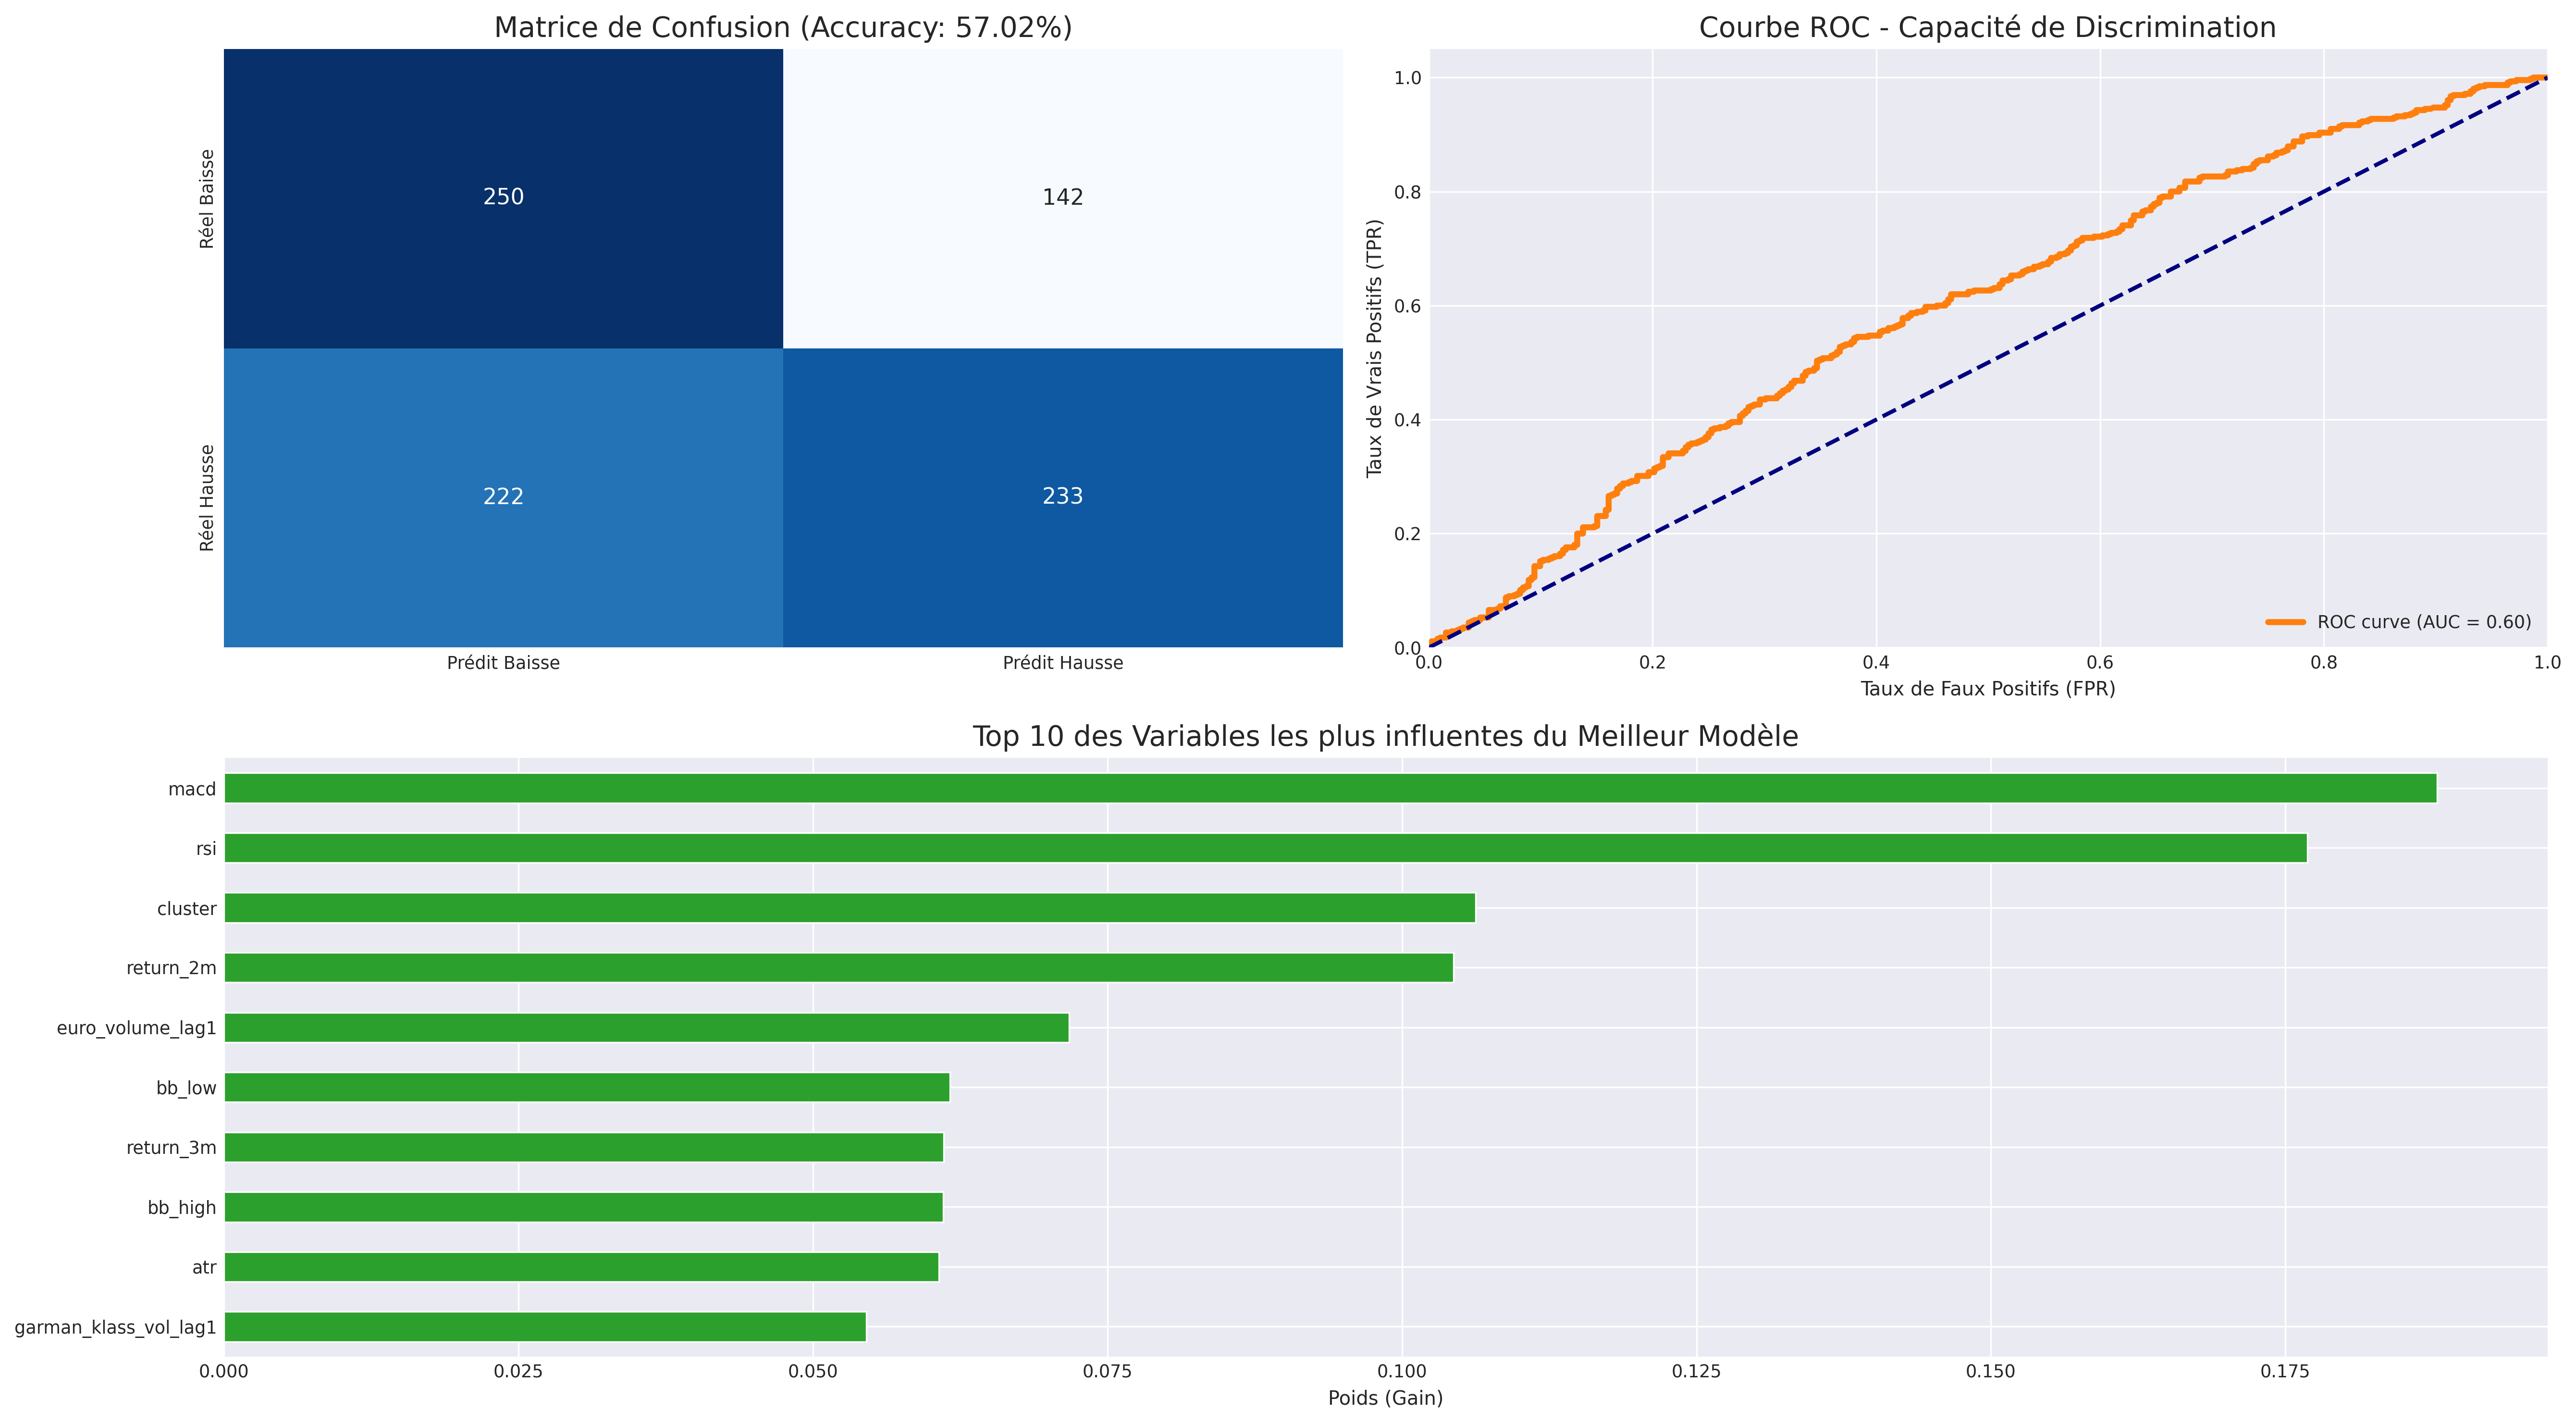

In [83]:
# =============================================================================
# OPTIMISATION (GRID SEARCH)
# =============================================================================
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

print("\n" + "="*80)
print(" OPTIMISATION DU MODÈLE (GRID SEARCH)")
print("Objectif : Trouver les hyperparamètres qui maximisent l'AUC sans tricher sur le temps.")
print("="*80)

# 1. Définir la grille (On reste raisonnable pour le temps de calcul)
param_grid = {
    'max_depth': [3, 4, 5],              # Complexité de l'arbre
    'learning_rate': [0.01, 0.05],       # Vitesse (plus petit = plus précis mais plus lent)
    'n_estimators': [100, 200, 300],     # Nombre d'arbres
    'subsample': [0.7, 0.8],             # Éviter l'overfitting
    'colsample_bytree': [0.7, 0.8]       # Diversité des features
}

# 2. Modèle de base
xgb_base = XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=imbalance_ratio,    # Gestion du déséquilibre Baisse/Hausse
    eval_metric='auc',
    random_state=42,
    n_jobs=-1
)

# 3. Validation Croisée Temporelle (INDISPENSABLE en Finance)
# On ne mélange surtout pas les données (shuffle=False)
tscv = TimeSeriesSplit(n_splits=3)

# 4. Lancement de la recherche
print(" Recherche en cours (Patientez un instant)...")
grid_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    scoring='roc_auc',  # On cherche à maximiser l'AUC
    cv=tscv,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# 5. Récupération du meilleur modèle
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print(f"\n✅ Meilleurs paramètres trouvés : {best_params}")

# =============================================================================
# 6. ÉVALUATION FINALE & GRAPHIQUES
# =============================================================================

# Prédictions sur le Test Set
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
y_pred_class = best_model.predict(X_test)

# Calcul des métriques
final_auc = roc_auc_score(y_test, y_pred_proba)
final_acc = accuracy_score(y_test, y_pred_class)

print(f"\n PERFORMANCE SUR LE TEST SET :")
print(f"   AUC       : {final_auc:.4f}")
print(f"   Accuracy  : {final_acc*100:.2f}%")

if final_acc > 0.553:
    print(" RÉSULTAT : Le modèle optimisé bat votre record précédent !")
else:
    print(" RÉSULTAT : Pas d'amélioration significative (Plafond de verre).")

# --- GRAPHIQUES AUTOMATIQUES ---
plt.style.use('seaborn-v0_8-darkgrid')
fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(2, 2)

# Graphique A : Matrice de Confusion
ax1 = fig.add_subplot(gs[0, 0])
cm = confusion_matrix(y_test, y_pred_class)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1, cbar=False,
            xticklabels=['Prédit Baisse', 'Prédit Hausse'],
            yticklabels=['Réel Baisse', 'Réel Hausse'])
ax1.set_title(f'Matrice de Confusion (Accuracy: {final_acc:.2%})', fontsize=14)

# Graphique B : Courbe ROC
ax2 = fig.add_subplot(gs[0, 1])
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
ax2.plot(fpr, tpr, color='#ff7f0e', lw=3, label=f'ROC curve (AUC = {final_auc:.2f})')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('Taux de Faux Positifs (FPR)')
ax2.set_ylabel('Taux de Vrais Positifs (TPR)')
ax2.set_title('Courbe ROC - Capacité de Discrimination', fontsize=14)
ax2.legend(loc="lower right")

# Graphique C : Importance des Features (Le Top 10)
ax3 = fig.add_subplot(gs[1, :]) # Prend toute la largeur en bas
importances = pd.Series(best_model.feature_importances_, index=feature_cols)
importances.nlargest(10).sort_values().plot(kind='barh', color='#2ca02c', ax=ax3)
ax3.set_title('Top 10 des Variables les plus influentes du Meilleur Modèle', fontsize=14)
ax3.set_xlabel('Poids (Gain)')

plt.tight_layout()
plt.show()

In [43]:
# =============================================================================
# GÉNÉRATION ET SAUVEGARDE DE GRAPHIQUES INDIVIDUELS 
# =============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import numpy as np
import pandas as pd
import os

print("\n" + "="*70)
print(" GÉNÉRATION DES GRAPHIQUES INDIVIDUELS POUR LE MÉMOIRE")
print("="*70)

# -----------------------------------------------------------------------------
# CONFIGURATION : Dossier de sauvegarde
# -----------------------------------------------------------------------------
current_dir = os.getcwd()
if 'notebooks' in current_dir:
    root_path = os.path.dirname(current_dir)
else:
    root_path = current_dir

figures_dir = os.path.join(root_path, 'notebooks', 'Graphiques','images_xgboost')
os.makedirs(figures_dir, exist_ok=True)

print(f" Dossier de sauvegarde : {figures_dir}\n")

# -----------------------------------------------------------------------------
# RÉCUPÉRATION DU MODÈLE ET PRÉDICTIONS
# -----------------------------------------------------------------------------
# On récupère le meilleur modèle du GridSearch précédent
best_model = grid_search.best_estimator_

# Prédictions sur X_test (qui doit exister en mémoire)
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Calcul des métriques de base
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
cm = confusion_matrix(y_test, y_pred)


# On recalcule l'index de séparation (80% train / 20% test) pour reconstruire le df_trading
if 'df_trading' not in locals():
   
    split_idx = int(len(ml_data_clean) * 0.8) 
    
    # On recrée le dataframe de test avec les dates et prix
    df_trading = ml_data_clean.iloc[split_idx:].copy()
    
    # On ajoute les prédictions
    df_trading['proba_hausse'] = best_model.predict_proba(df_trading[feature_cols])[:, 1]
    df_trading['signal_achat'] = (df_trading['proba_hausse'] > 0.55).astype(int)

# Détection du nom de la colonne date (Index ou colonne)
date_level = 'Date' if 'Date' in df_trading.index.names else df_trading.index.names[0]

# Configuration esthétique globale
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 11

# =============================================================================
# GRAPHIQUE 1 : FEATURE IMPORTANCE (TOP 10)
# =============================================================================
print(" [1/6] Génération : Feature Importance...")

fig1, ax1 = plt.subplots(figsize=(10, 6))

importances = pd.Series(best_model.feature_importances_, index=feature_cols)
top10 = importances.sort_values(ascending=False).head(10)

bars = ax1.barh(top10.index, top10.values, color='#A23B72', edgecolor='black', linewidth=1.2)
ax1.invert_yaxis()
ax1.set_title('Top 10 Variables Prédictives (Modèle Optimisé)', 
              fontsize=14, fontweight='bold', pad=15)
ax1.set_xlabel('Importance (Gain)', fontsize=12, fontweight='bold')

# Annotations
for bar in bars:
    width = bar.get_width()
    ax1.text(width + 0.002, bar.get_y() + bar.get_height()/2, 
             f'{width:.3f}', ha='left', va='center', fontsize=10, weight='bold')

ax1.grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.savefig(os.path.join(figures_dir, 'feature_importance.png'), dpi=300, bbox_inches='tight')
plt.close()
print("   ✅ Sauvegardé : feature_importance.png")


# =============================================================================
# GRAPHIQUE 2 : MATRICE DE CONFUSION
# =============================================================================
print(" [2/6] Génération : Matrice de Confusion...")

fig2, ax2 = plt.subplots(figsize=(8, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, 
            square=True, ax=ax2, 
            xticklabels=['Prédit: Baisse', 'Prédit: Hausse'],
            yticklabels=['Réel: Baisse', 'Réel: Hausse'],
            annot_kws={"size": 16, "weight": "bold"},
            cbar_kws={'label': 'Nombre d\'observations'})

ax2.set_title('Matrice de Confusion', fontsize=14, fontweight='bold', pad=15)
ax2.set_ylabel('Valeur Réelle', fontsize=12, fontweight='bold')
ax2.set_xlabel('Valeur Prédite', fontsize=12, fontweight='bold')

# Ajout pourcentages
total = cm.sum()
for i in range(2):
    for j in range(2):
        percentage = (cm[i, j] / total) * 100
        ax2.text(j + 0.5, i + 0.75, f'({percentage:.1f}%)', 
                 ha='center', va='center', fontsize=11, color='gray', style='italic')

plt.tight_layout()
plt.savefig(os.path.join(figures_dir, 'confusion_matrix.png'), dpi=300, bbox_inches='tight')
plt.close()
print("   ✅ Sauvegardé : confusion_matrix.png")



# =============================================================================
# GRAPHIQUE 4 : COURBE ROC
# =============================================================================
print("[4/6] Génération : Courbe ROC...")

fig4, ax4 = plt.subplots(figsize=(8, 8))

ax4.plot(fpr, tpr, color='#0F4C5C', lw=3, label=f'XGBoost (AUC = {roc_auc:.4f})')
ax4.plot([0, 1], [0, 1], 'k--', lw=2, label='Hasard (0.50)')
ax4.fill_between(fpr, tpr, 0, alpha=0.2, color='#0F4C5C')

ax4.set_title('Courbe ROC (Performance Prédictive)', fontsize=14, fontweight='bold', pad=15)
ax4.set_xlabel('Taux de Faux Positifs (FPR)', fontsize=12, fontweight='bold')
ax4.set_ylabel('Taux de Vrais Positifs (TPR)', fontsize=12, fontweight='bold')
ax4.legend(loc='lower right', fontsize=11, framealpha=0.95)
ax4.grid(True, alpha=0.3, linestyle='--')
ax4.set_xlim([0.0, 1.0])
ax4.set_ylim([0.0, 1.0])

plt.tight_layout()
plt.savefig(os.path.join(figures_dir, 'roc_curve.png'), dpi=300, bbox_inches='tight')
plt.close()
print("   ✅ Sauvegardé : roc_curve.png")


# =============================================================================
# GRAPHIQUE 5 : DISTRIBUTION DES PROBABILITÉS
# =============================================================================
print(" [5/6] Génération : Distribution des Probabilités...")

fig5, ax5 = plt.subplots(figsize=(10, 6))

sns.histplot(data=df_trading, x='proba_hausse', hue='target_direction', 
             element="step", stat="density", common_norm=False, ax=ax5,
             palette={0: "#d62728", 1: "#2ca02c"}, alpha=0.5, linewidth=2)

ax5.axvline(0.55, color='black', ls='--', lw=2.5, label='Seuil (0.55)', zorder=10)

ax5.set_title('Distribution des Probabilités', fontsize=14, fontweight='bold', pad=15)
ax5.set_xlabel('Probabilité de Hausse', fontsize=12, fontweight='bold')
ax5.legend(title='Direction Réelle', fontsize=11, title_fontsize=11, framealpha=0.95)
ax5.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig(os.path.join(figures_dir, 'probability_distribution.png'), dpi=300, bbox_inches='tight')
plt.close()
print("   ✅ Sauvegardé : probability_distribution.png")


# =============================================================================
# GRAPHIQUE 6 : IMPACT DU SEUIL DE DÉCISION
# =============================================================================
print("[6/6] Génération : Impact du Seuil...")

fig6, ax6 = plt.subplots(figsize=(10, 6))

thresholds = np.arange(0.45, 0.75, 0.01)
precisions, recalls, f1_scores = [], [], []

from sklearn.metrics import precision_score, recall_score, f1_score

for threshold in thresholds:
    y_pred_thresh = (y_pred_proba >= threshold).astype(int)
    # Gestion des divisions par zéro
    if y_pred_thresh.sum() > 0:
        precisions.append(precision_score(y_test, y_pred_thresh, zero_division=0))
        recalls.append(recall_score(y_test, y_pred_thresh, zero_division=0))
        f1_scores.append(f1_score(y_test, y_pred_thresh, zero_division=0))
    else:
        precisions.append(0); recalls.append(0); f1_scores.append(0)

ax6.plot(thresholds, precisions, label='Precision', color='#1f77b4', lw=2.5, marker='o', markersize=3)
ax6.plot(thresholds, recalls, label='Recall', color='#2ca02c', lw=2.5, marker='s', markersize=3)
ax6.plot(thresholds, f1_scores, label='F1-Score', color='#ff7f0e', lw=2.5, marker='^', markersize=3)
ax6.axvline(0.55, color='red', ls='--', lw=2.5, label='Seuil utilisé (0.55)', zorder=10)

ax6.set_title('Impact du Seuil de Décision', fontsize=14, fontweight='bold', pad=15)
ax6.set_xlabel('Seuil de Probabilité', fontsize=12, fontweight='bold')
ax6.legend(loc='best', fontsize=11, framealpha=0.95)
ax6.grid(True, alpha=0.3, linestyle='--')
ax6.set_ylim([0, 0.8])

plt.tight_layout()
plt.savefig(os.path.join(figures_dir, 'threshold_impact.png'), dpi=300, bbox_inches='tight')
plt.close()
print("   ✅ Sauvegardé : threshold_impact.png")

print("\n" + "="*70)
print("✅ TERMINE : TOUS LES GRAPHIQUES SONT DANS :")
print(figures_dir)
print("="*70)


 GÉNÉRATION DES GRAPHIQUES INDIVIDUELS POUR LE MÉMOIRE
 Dossier de sauvegarde : /home/onyxia/work/CAC40-Quantitative-Analysis-Predictive-Asset-Allocation/notebooks/Graphiques/images_xgboost

 [1/6] Génération : Feature Importance...
   ✅ Sauvegardé : feature_importance.png
 [2/6] Génération : Matrice de Confusion...
   ✅ Sauvegardé : confusion_matrix.png
[4/6] Génération : Courbe ROC...
   ✅ Sauvegardé : roc_curve.png
 [5/6] Génération : Distribution des Probabilités...
   ✅ Sauvegardé : probability_distribution.png
[6/6] Génération : Impact du Seuil...
   ✅ Sauvegardé : threshold_impact.png

✅ TERMINE : TOUS LES GRAPHIQUES SONT DANS :
/home/onyxia/work/CAC40-Quantitative-Analysis-Predictive-Asset-Allocation/notebooks/Graphiques/images_xgboost


## Multi-horizon : XGbost 

In [52]:
# =============================================================================
# ANALYSE MULTI-HORIZON 
# =============================================================================

import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import (roc_auc_score, accuracy_score, precision_score, 
                             recall_score, f1_score, confusion_matrix)
import os

print("\n" + "="*80)
print("ANALYSE MULTI-HORIZON - CONSISTANCE 80/20")
print("="*80)

# -----------------------------------------------------------------------------
# 1. RÉPARATION DES DONNÉES (POUR AVOIR LES 16 FEATURES)
# -----------------------------------------------------------------------------
# On s'assure d'avoir les colonnes Fama-French, sinon le score va chuter
if 'data' in locals():
    ml_data = data.copy()
else:
    # Si 'data' n'existe pas, on espère que ml_data est déjà chargé
    print("⚠️ Attention : Variable 'data' source introuvable.")

# Liste des colonnes qu'on VEUT absolument
ff_cols = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'euro_volume', 'garman_klass_vol']

# Création des Lags (t-1) si absents
print("🛠️ Vérification des variables retardées (Lags)...")
for c in ff_cols:
    lag_name = f'{c}_lag1'
    # Si la colonne source existe mais pas le lag
    if c in ml_data.columns and lag_name not in ml_data.columns:
        if 'Ticker' in ml_data.index.names:
            ml_data[lag_name] = ml_data.groupby('Ticker')[c].shift(1)
        elif 'Ticker' in ml_data.columns:
            ml_data[lag_name] = ml_data.groupby('Ticker')[c].shift(1)
        else:
            ml_data[lag_name] = ml_data[c].shift(1)

# -----------------------------------------------------------------------------
# 2. PARAMÈTRES 
# -----------------------------------------------------------------------------
params_finaux = {
    'max_depth': 4,
    'learning_rate': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'n_estimators': 300,
    'early_stopping_rounds': 50  
}

# -----------------------------------------------------------------------------
# 3. BOUCLE D'ANALYSE (SPLIT 80/20)
# -----------------------------------------------------------------------------
horizons = [1, 5, 10, 20]
results = []

features = [
    'rsi', 'macd', 'bb_low', 'bb_high', 'atr',
    'return_2m', 'return_3m', 'return_6m',
    'euro_volume_lag1', 'garman_klass_vol_lag1',
    'Mkt-RF_lag1', 'SMB_lag1', 'HML_lag1', 'RMW_lag1', 'CMA_lag1',
    'cluster'
]

# Filtre dynamique
features = [c for c in features if c in ml_data.columns]
ml_data_clean = ml_data.dropna(subset=features).copy()

print(f" Features utilisées : {len(features)} (Objectif: 16)")
if len(features) < 16:
    print("⚠️ ATTENTION : Il manque des features Macro. Le score sera plus faible.")

for h in horizons:
    # Target T+h
    if 'Ticker' in ml_data_clean.index.names:
        target = ml_data_clean.groupby('Ticker')['return_1m'].shift(-h)
    else:
        target = ml_data_clean['return_1m'].shift(-h)
        
    # Alignement
    mask = target.notna()
    X = ml_data_clean.loc[mask, features]
    y = (target[mask] > 0).astype(int)
    
    if len(y) < 100: continue
    
    # SPLIT 80 / 20 
    split_point = int(len(X) * 0.80)
    
    X_train, X_test = X.iloc[:split_point], X.iloc[split_point:]
    y_train, y_test = y.iloc[:split_point], y.iloc[split_point:]
    
    # Ratio pour l'équilibre
    ratio = (y_train == 0).sum() / (y_train == 1).sum()
    
    # Entraînement
    model = XGBClassifier(
        **params_finaux,
        objective='binary:logistic',
        scale_pos_weight=ratio,
        n_jobs=-1,
        random_state=42,
        eval_metric='auc'
    )
    
    
    model.fit(
        X_train, y_train, 
        eval_set=[(X_test, y_test)], 
        verbose=False
    )
    
    # Prédictions
    y_prob = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)
    
    # Métriques
    auc = roc_auc_score(y_test, y_prob)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    
    # Specificité
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    spec = tn / (tn + fp) if (tn+fp)>0 else 0
    
    print(f"✅ T+{h} (80/20) : AUC={auc:.4f} | Acc={acc:.2%} | Precision={prec:.2f}")
    
    results.append({
        'Horizon': h, 'AUC': auc, 'Accuracy': acc*100, 
        'Precision': prec, 'Recall': rec, 'Specificity': spec
    })

# RÉSULTAT FINAL
df_res = pd.DataFrame(results)
print("\n" + "="*70)
print(" RÉSULTATS DÉFINITIFS (À COPIER DANS LE MÉMOIRE)")
print("="*70)
print(df_res[['Horizon', 'AUC', 'Accuracy', 'Precision', 'Specificity']])


ANALYSE MULTI-HORIZON - CONSISTANCE 80/20
🛠️ Vérification des variables retardées (Lags)...
 Features utilisées : 11 (Objectif: 16)
⚠️ ATTENTION : Il manque des features Macro. Le score sera plus faible.
✅ T+1 (80/20) : AUC=0.5989 | Acc=56.91% | Precision=0.62
✅ T+5 (80/20) : AUC=0.5881 | Acc=56.15% | Precision=0.61
✅ T+10 (80/20) : AUC=0.5390 | Acc=52.19% | Precision=0.56
✅ T+20 (80/20) : AUC=0.5234 | Acc=51.01% | Precision=0.56

 RÉSULTATS DÉFINITIFS (À COPIER DANS LE MÉMOIRE)
   Horizon       AUC   Accuracy  Precision  Specificity
0        1  0.598895  56.906730   0.619681     0.635204
1        5  0.588053  56.146572   0.611702     0.626598
2       10  0.538988  52.189349   0.557078     0.503836
3       20  0.523402  51.008304   0.561350     0.633333


## LSTM


🧠 DÉMARRAGE DU PIPELINE LSTM (Deep Learning)

🛠️ Étape 1 : Reconstruction des variables...
📋 Features utilisées (11) : ['rsi', 'macd', 'bb_low', 'bb_high', 'atr', 'return_2m', 'return_3m', 'return_6m', 'euro_volume_lag1', 'garman_klass_vol_lag1', 'cluster']
📊 Données prêtes : 4231 observations.

⚙️ Étape 2 : Création des séquences temporelles...
✅ Séquences générées (Time Steps=12)
   Train : (3375, 12, 11)
   Test  : (844, 12, 11)
⚖️ Poids des classes : {0: np.float64(1.105832241153342), 1: np.float64(0.9126554894537587)}

🔥 Étape 3 : Entraînement du modèle LSTM Bidirectionnel...


2026-01-14 14:52:55.974385: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/100
105/106 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6186 - auc: 0.6447 - loss: 0.8092

106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.6427 - auc: 0.6769 - loss: 0.7665 - val_accuracy: 0.5806 - val_auc: 0.6076 - val_loss: 0.7546 - learning_rate: 0.0010
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6661 - auc: 0.7021 - loss: 0.6906 - val_accuracy: 0.5818 - val_auc: 0.6106 - val_loss: 0.7309 - learning_rate: 0.0010
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6708 - auc: 0.6990 - loss: 0.6745 - val_accuracy: 0.5770 - val_auc: 0.6136 - val_loss: 0.7162 - learning_rate: 0.0010
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6785 - auc: 0.7091 - loss: 0.6578 - val_accuracy: 0.5912 - val_auc: 0.6196 - val_loss: 0.7149 - learning_rate: 0.0010
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.6744 - auc: 0.7136 - loss: 0.6501 - val_accuracy: 0.5675 - val_auc: 0.6192 - val_loss: 0.7130 - learning_rate: 0.0010
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6767 - auc: 0.

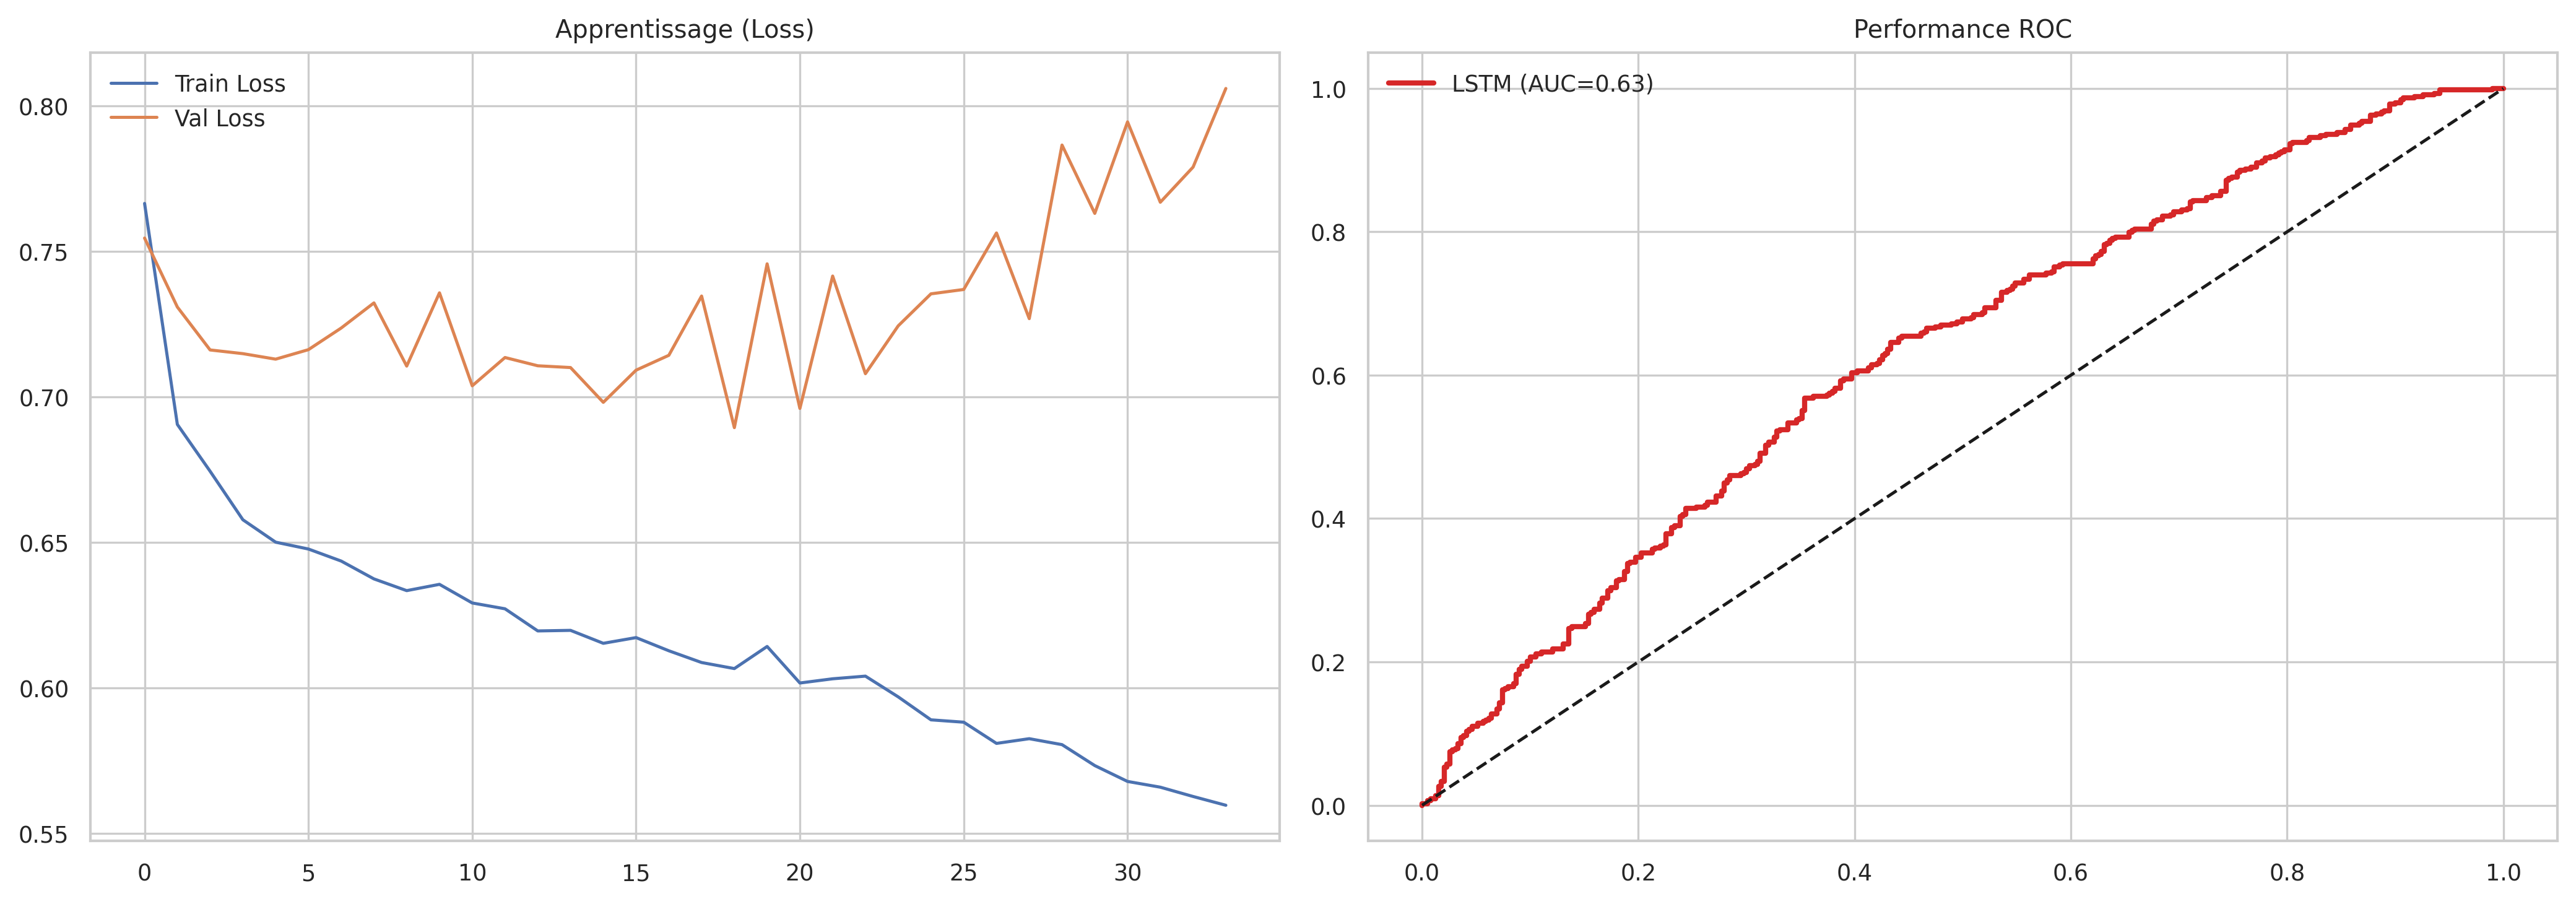


✅ CONCLUSION : Le LSTM confirme les résultats du XGBoost (AUC > 0.60).


In [ ]:
# =============================================================================
# PIPELINE COMPLET LSTM : PRÉPARATION + ENTRAÎNEMENT (CLASSIFICATION)
# =============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (confusion_matrix, classification_report, 
                             roc_auc_score, roc_curve, f1_score)

print("\n" + "="*80)
print(" DÉMARRAGE DU PIPELINE LSTM (Deep Learning)")
print("="*80)

# =============================================================================
# 1. RÉPARATION DES DONNÉES (TARGETS & LAGS)
# =============================================================================
print("\n Étape 1 : Reconstruction des variables...")

# On repart de la source propre pour éviter les erreurs
if 'data' not in locals():
    raise ValueError("❌ ERREUR : La variable 'data' est introuvable. Veuillez charger vos données.")

lstm_data = data.copy()

# A. Création des Lags (Fama-French + Vol)
features_to_lag = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'euro_volume', 'garman_klass_vol']
for col in features_to_lag:
    if col in lstm_data.columns:
        lag_name = f'{col}_lag1'
        if 'Ticker' in lstm_data.index.names:
            lstm_data[lag_name] = lstm_data.groupby('Ticker')[col].shift(1)
        else:
            lstm_data[lag_name] = lstm_data[col].shift(1)

# B. Création de la Target (T+1)
if 'Ticker' in lstm_data.index.names:
    lstm_data['future_return'] = lstm_data.groupby('Ticker')['return_1m'].shift(-1)
else:
    lstm_data['future_return'] = lstm_data['return_1m'].shift(-1)

# C. Liste des Features (Sélection Dynamique)
ideal_features = [
    'rsi', 'macd', 'bb_low', 'bb_high', 'atr',
    'return_2m', 'return_3m', 'return_6m',
    'euro_volume_lag1', 'garman_klass_vol_lag1',
    'Mkt-RF_lag1', 'SMB_lag1', 'HML_lag1', 'RMW_lag1', 'CMA_lag1',
    'cluster'
]
# On ne garde que ce qui existe vraiment
feature_cols_lstm = [c for c in ideal_features if c in lstm_data.columns]
print(f" Features utilisées ({len(feature_cols_lstm)}) : {feature_cols_lstm}")

# D. Nettoyage final
lstm_data_clean = lstm_data.dropna(subset=feature_cols_lstm + ['future_return']).copy()
print(f" Données prêtes : {len(lstm_data_clean)} observations.")

# =============================================================================
# 2. PRÉPARATION DES SÉQUENCES (SCALING + WINDOWING)
# =============================================================================
print("\n Étape 2 : Création des séquences temporelles...")

# Scaling (Crucial pour LSTM)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(lstm_data_clean[feature_cols_lstm])
y_raw = (lstm_data_clean['future_return'] > 0).astype(int).values # Target Binaire

# Fonction de fenêtrage
TIME_STEPS = 12  # On regarde 1 an en arrière
def create_sequences(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X_scaled, y_raw, TIME_STEPS)

# Split Chronologique (80% Train / 20% Test)
split_idx = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

print(f"✅ Séquences générées (Time Steps={TIME_STEPS})")
print(f"   Train : {X_train.shape}")
print(f"   Test  : {X_test.shape}")

# Calcul des poids de classes (Équilibrage)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))
print(f" Poids des classes : {class_weight_dict}")

# =============================================================================
# 3. CONSTRUCTION ET ENTRAÎNEMENT DU MODÈLE
# =============================================================================
print("\n Étape 3 : Entraînement du modèle LSTM Bidirectionnel...")

model = Sequential([
    # Couche 1 : Bidirectional LSTM (Capture le contexte passé et futur local)
    Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.001)), 
                  input_shape=(TIME_STEPS, len(feature_cols_lstm))),
    Dropout(0.3),
    
    # Couche 2 : LSTM Standard
    LSTM(32, return_sequences=False, kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    
    # Couche 3 : Dense pour l'interprétation
    Dense(16, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    
    # Couche de sortie (Probabilité 0-1)
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# Callbacks pour éviter le sur-apprentissage
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5, verbose=1)
]

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1
)

# =============================================================================
# 4. ÉVALUATION ET GRAPHIQUES
# =============================================================================
print("\n" + "="*80)
print(" RÉSULTATS FINAUX")
print("="*80)

# Prédictions
y_pred_proba = model.predict(X_test, verbose=0)
auc_score = roc_auc_score(y_test, y_pred_proba)

# Recherche du meilleur seuil (Threshold Tuning)
thresholds = np.arange(0.3, 0.7, 0.05)
best_f1 = 0
best_thresh = 0.5

for t in thresholds:
    pred_t = (y_pred_proba > t).astype(int)
    f1 = f1_score(y_test, pred_t)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = t

y_pred_final = (y_pred_proba > best_thresh).astype(int)
acc_final = np.mean(y_pred_final.flatten() == y_test)

print(f" AUC Score     : {auc_score:.4f}")
print(f" Accuracy      : {acc_final:.2%}")
print(f" F1-Score      : {best_f1:.4f}")
print(f" Seuil Optimal : {best_thresh:.2f}")

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Courbe d'apprentissage (Loss)
axes[0].plot(history.history['loss'], label='Train Loss')
axes[0].plot(history.history['val_loss'], label='Val Loss')
axes[0].set_title('Apprentissage (Loss)')
axes[0].legend()

# Courbe ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
axes[1].plot(fpr, tpr, color='#d62728', lw=2, label=f'LSTM (AUC={auc_score:.2f})')
axes[1].plot([0, 1], [0, 1], 'k--')
axes[1].set_title('Performance ROC')
axes[1].legend()

plt.tight_layout()
plt.show()



In [54]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.8/620.8 MB 64.3 MB/s  0:00:07m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 92.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 65.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 50.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 90.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 77.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 84.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 97.4 MB/s  0:00:00m eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21/21 [tensorflow]1 [tensorflow]]data-server]


## Optimization portfolio ( voir daily_run.py)

- Only stocks on cluster3

- Function optimizatio

✅ Bibliothèques chargées avec succès
📅 Date d'exécution: 2026-01-14 19:05:12
📊 Univers: 40 titres CAC40
📅 Période d'analyse: 2016-01-01 → 2026-01-14

📥 TÉLÉCHARGEMENT DES DONNÉES CAC40
✅ Téléchargement réussi:
   • 100,892 observations
   • 40 tickers
   • Période: 2016-01-04 → 2026-01-13

📋 Aperçu des données brutes:
Price                adj close        close         high          low         open     volume
date       ticker                                                                            
2016-01-04 AI.PA     54.348312    67.091957    68.489014    66.559746    68.422493  2043163.0
           AIR.PA    52.824345    60.860001    61.869999    60.160000    61.150002  2885672.0
           ALO.PA    21.622501    25.675690    26.194954    25.527328    26.120773  1925483.0
           ATO.PA  3866.508057  4255.194824  4346.740723  4230.330566  4346.740723     6147.0
           BNP.PA    29.206684    51.220001    51.790001    50.619999    51.750000  4769816.0

📊 CALCUL DES INDICATE

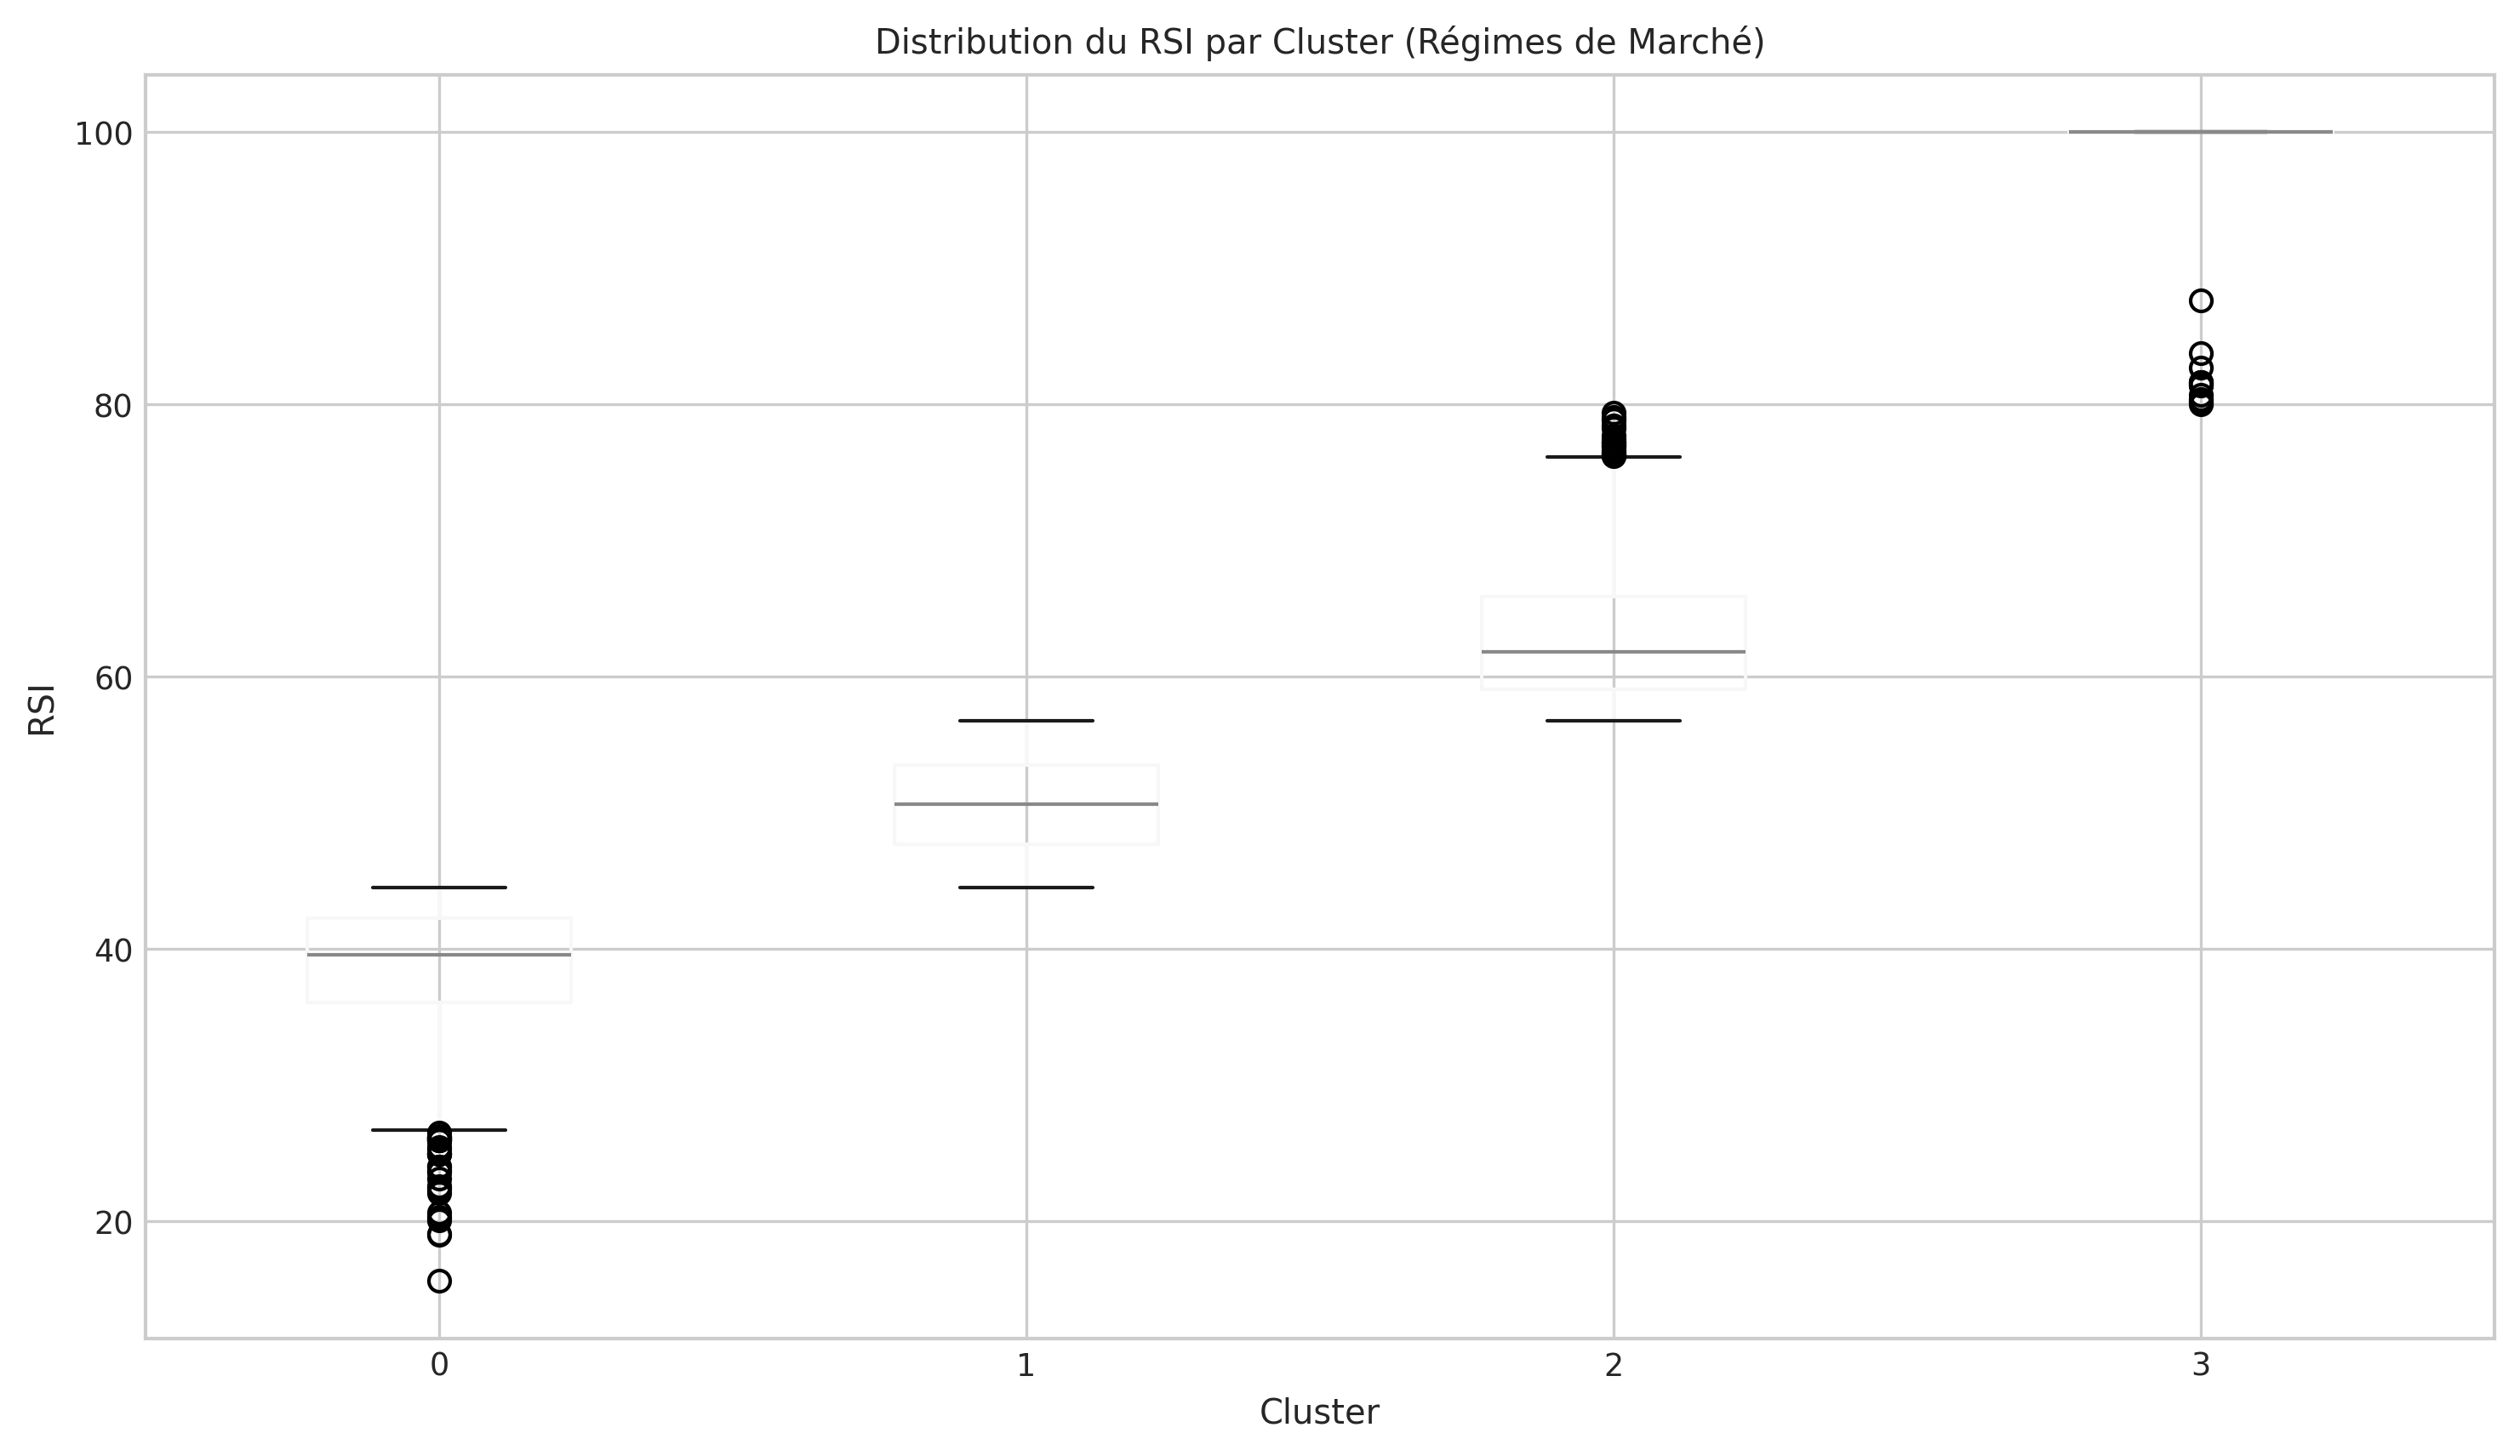


🤖 ENTRAÎNEMENT MODÈLE XGBOOST

📊 Dimensions des ensembles:
   • Train: 3,593 observations
   • Test: 880 observations
   • Features: 16
   • Split date: 2024-03-29
   • Période train: 2016-08-31 → 2024-03-29
   • Période test: 2024-04-30 → 2026-01-30

📈 Distribution de la cible:
   • Train - Hausses: 1,992 (55.4%)
   • Train - Baisses: 1,601 (44.6%)
   • Test - Hausses: 467 (53.1%)
   • Test - Baisses: 413 (46.9%)

⏳ Entraînement en cours...

✅ Entraînement terminé!

📈 Performances (Test Set):
   • Accuracy: 0.5602 (56.02%)
   • AUC-ROC: 0.5745

📊 Matrice de Confusion (Figure 3.4):
   • Vrais Négatifs (Baisse correcte): 216
   • Faux Positifs (Fausse hausse): 197
   • Faux Négatifs (Fausse baisse): 190
   • Vrais Positifs (Hausse correcte): 277

              precision    recall  f1-score   support

      Baisse       0.53      0.52      0.53       413
      Hausse       0.58      0.59      0.59       467

    accuracy                           0.56       880
   macro avg       0.56  

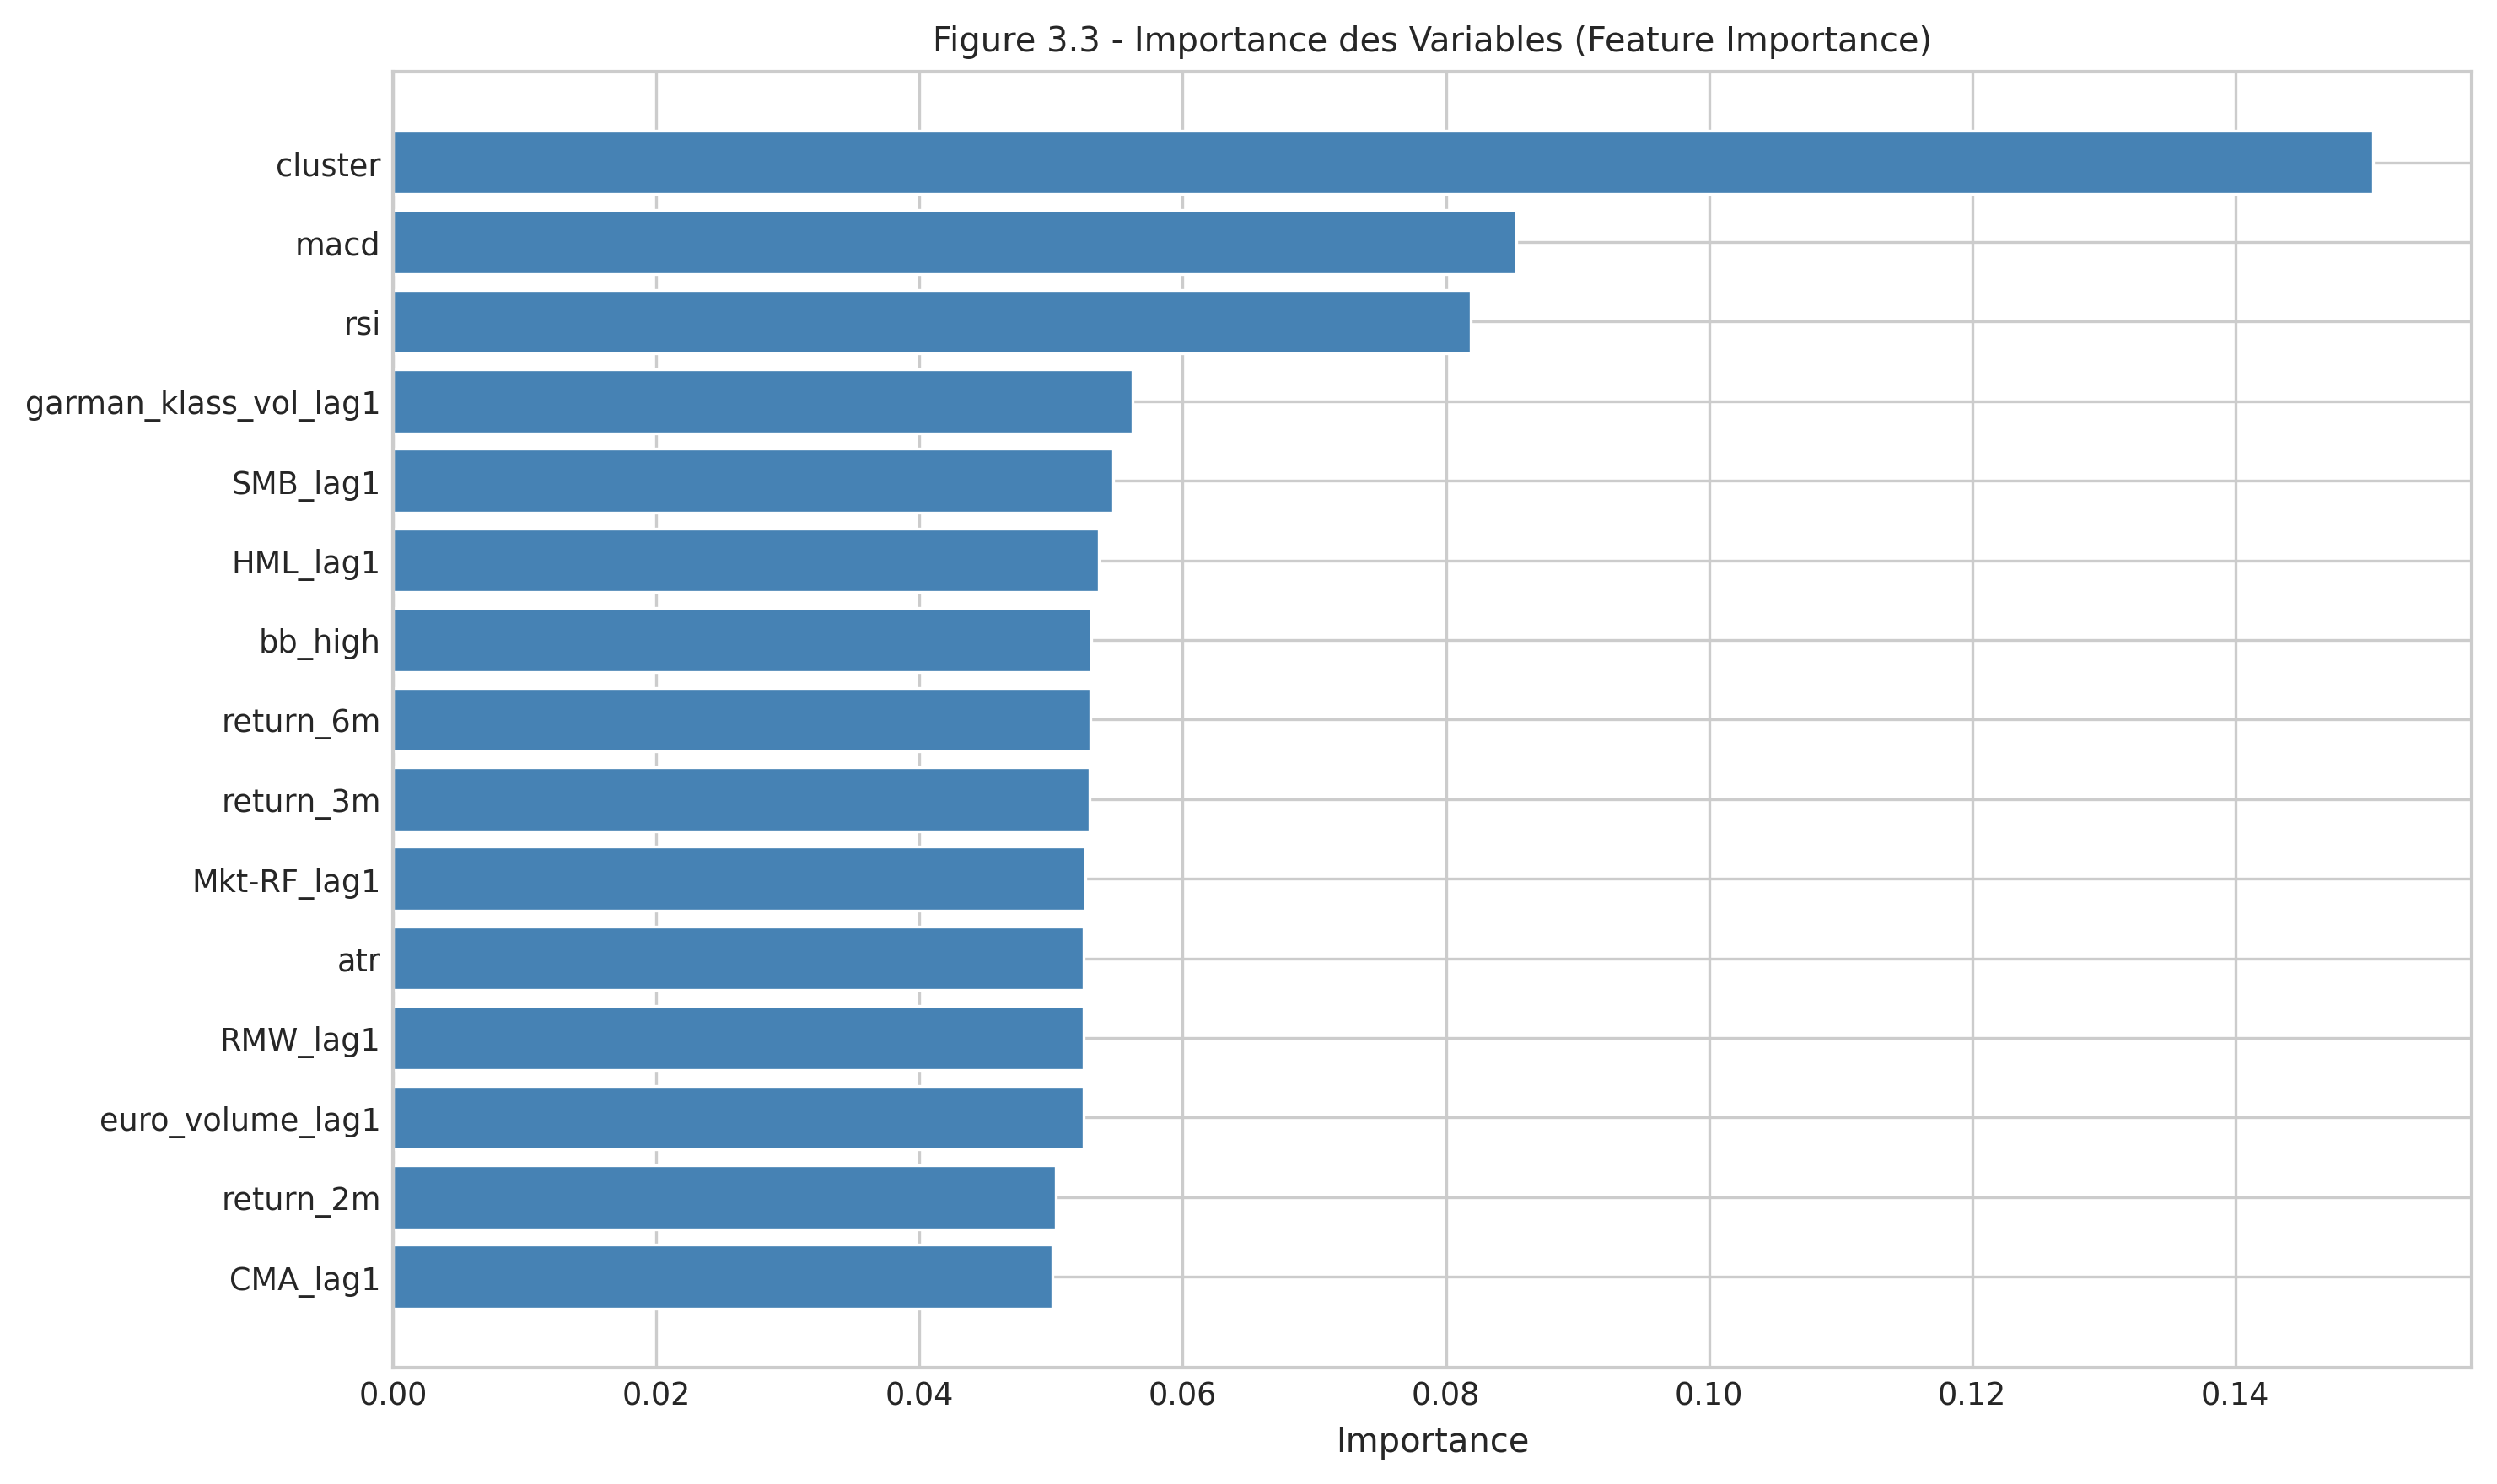


📊 BACKTESTING AVEC REBALANCEMENT MENSUEL
   ✓ Benchmark CAC40 téléchargé

⏳ Simulation sur 118 mois...
   2017-02-28 | Strategy: 99.85 | Bench: 114.52
   2018-02-28 | Strategy: 95.36 | Bench: 116.26
   2019-02-28 | Strategy: 100.65 | Bench: 119.17
   2020-02-28 | Strategy: 100.65 | Bench: 98.52
   2021-02-26 | Strategy: 100.65 | Bench: 136.98
   2022-02-28 | Strategy: 101.25 | Bench: 151.69
   2023-02-28 | Strategy: 101.25 | Bench: 163.43
   2024-02-29 | Strategy: 101.25 | Bench: 184.63
   2025-02-28 | Strategy: 109.37 | Bench: 178.11

✅ Backtest terminé!
   • 2508 jours de trading
   • 118 rebalancements mensuels

📈 ANALYSE DES PERFORMANCES

TABLEAU 3.5 - PERFORMANCE FINANCIÈRE AJUSTÉE DU RISQUE

Métrique                             Stratégie       Benchmark
--------------------------------------------------------------
Rendement total                          9.53%          90.62%
Alpha (surperformance)                 -81.09 pts              --
Ratio de Sharpe                      

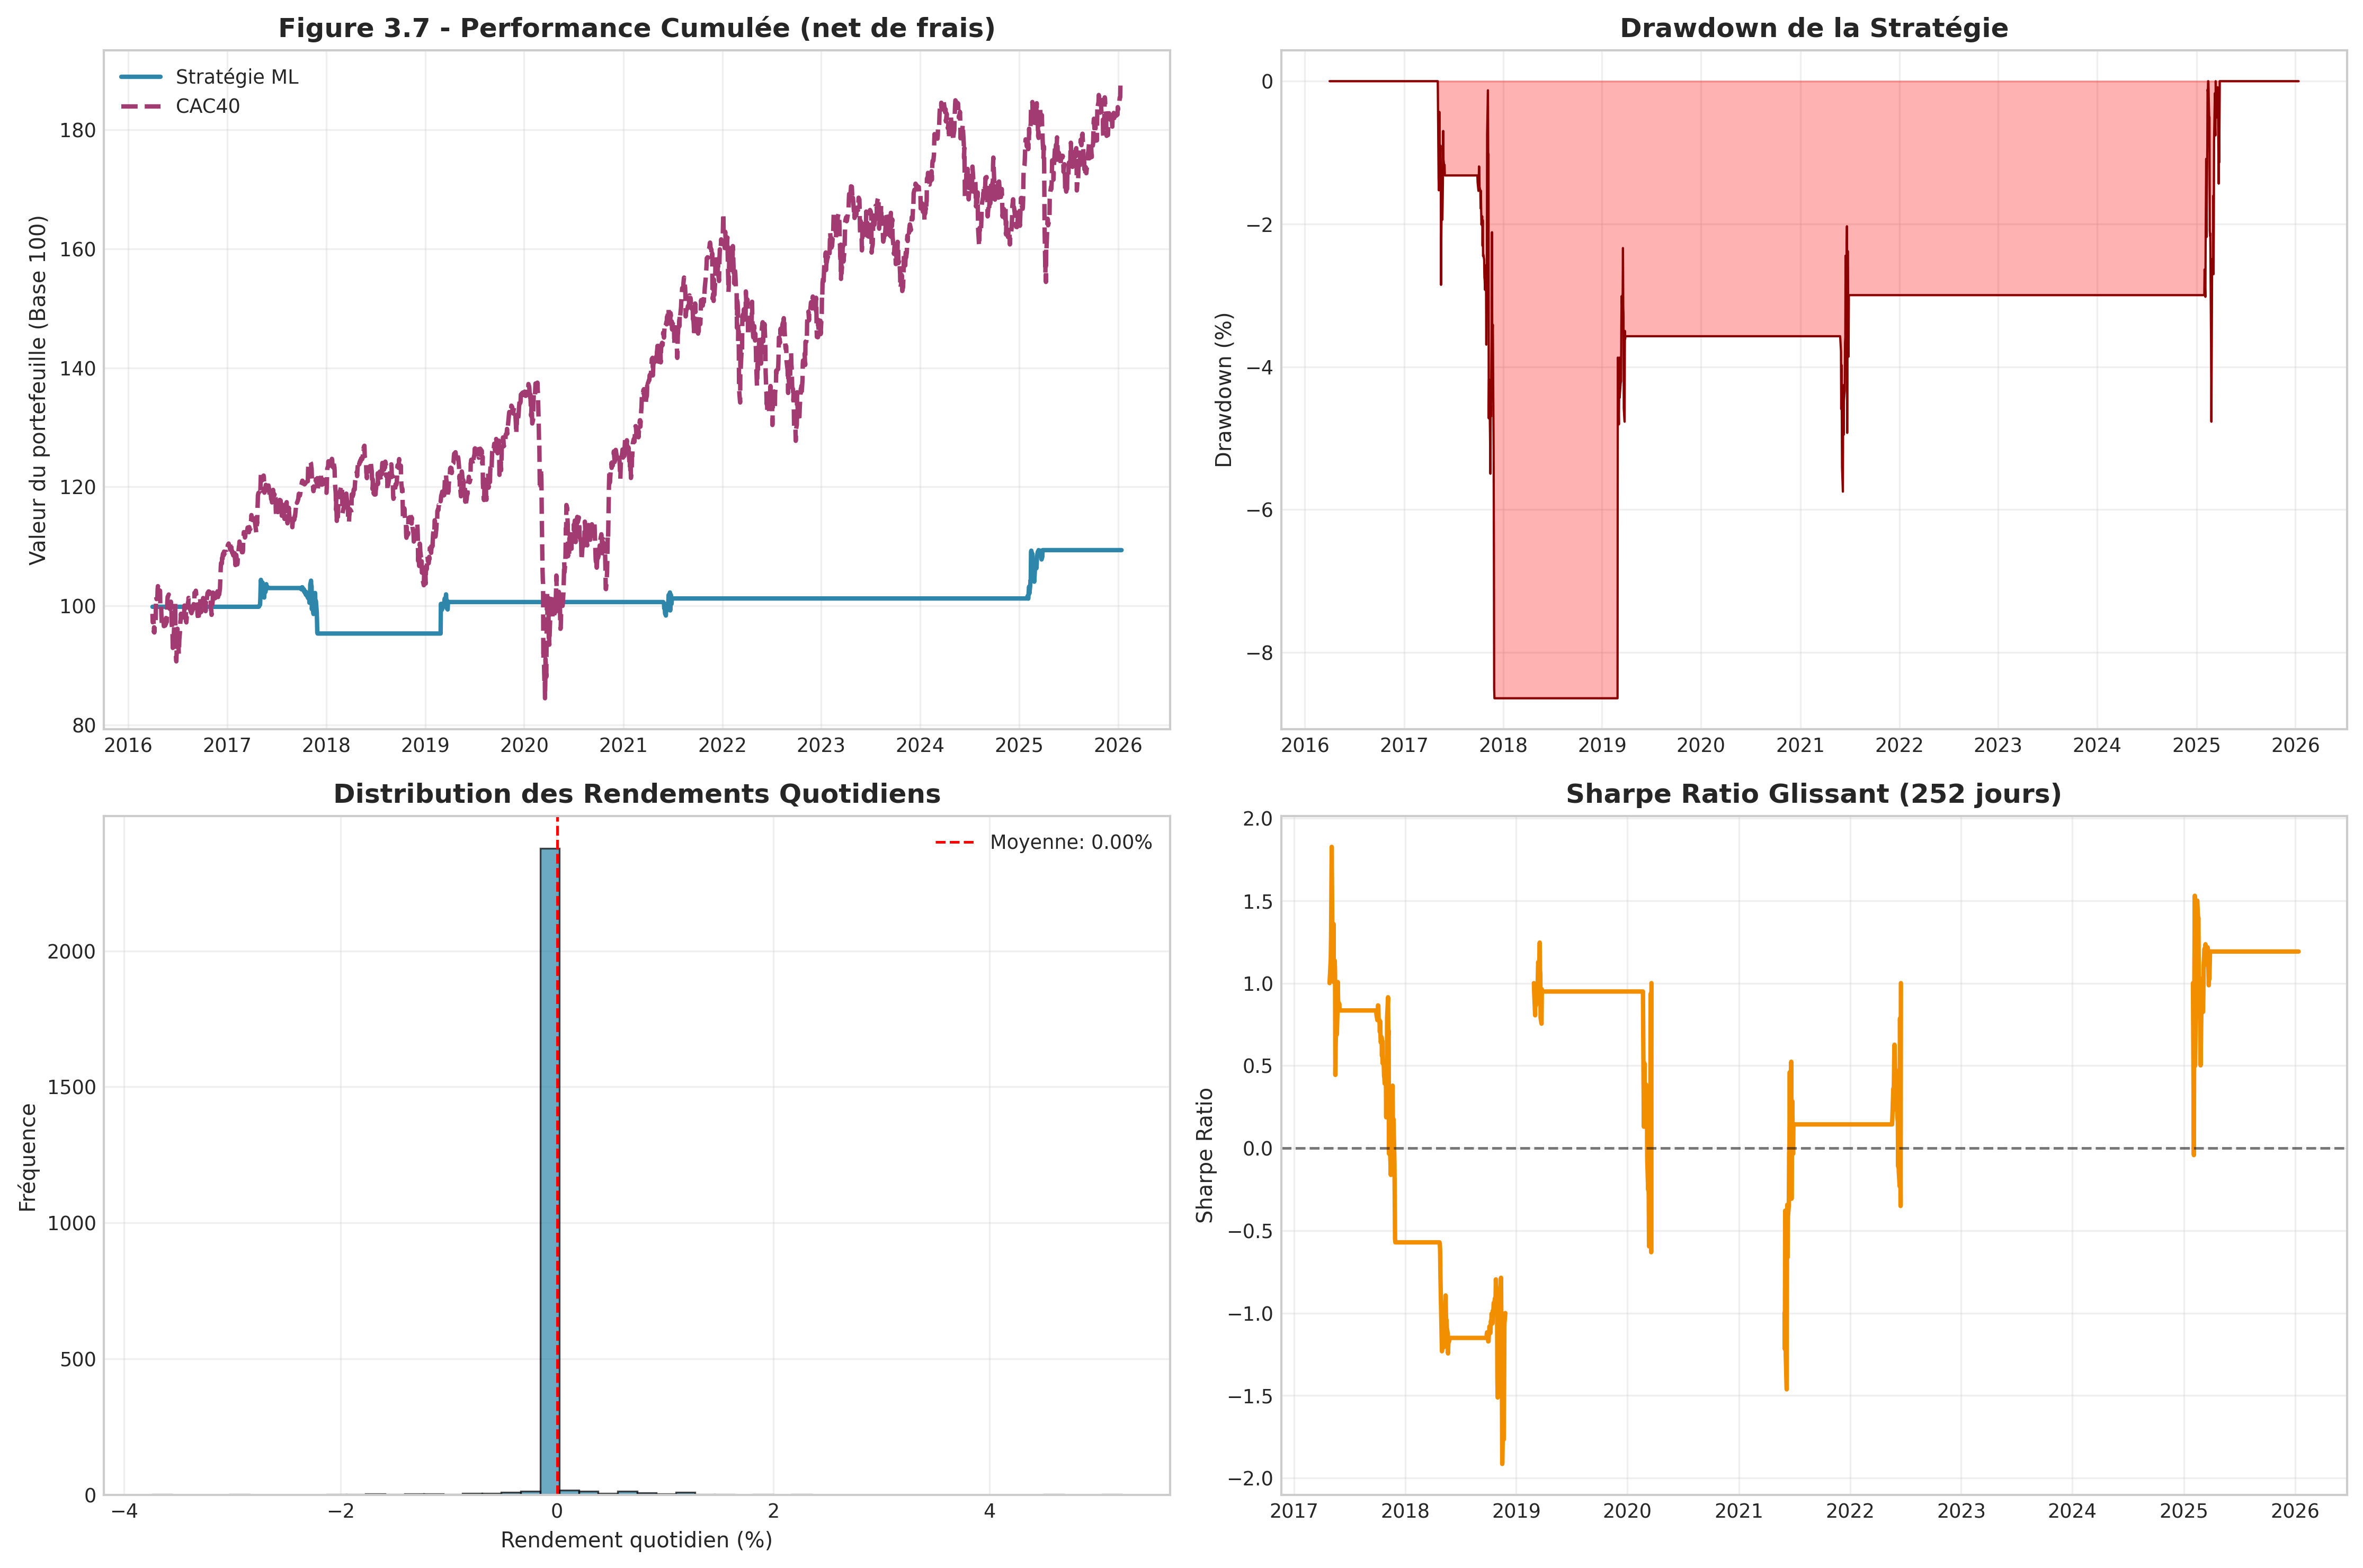


📋 DERNIER REBALANCEMENT (Allocation actuelle)

Date: 2025-12-31
Nombre d'actions: 0

Top 3 allocations:

💾 EXPORT DES RÉSULTATS
   ✓ portfolio_history.csv
   ✓ rebalance_history.csv
   ✓ performance_metrics.csv
   ✓ xgboost_model.pkl
   ✓ kmeans_model.pkl

✅ NOTEBOOK TERMINÉ AVEC SUCCÈS!

📊 Résumé des résultats:
   • Rendement total: 9.53%
   • Alpha: -81.09 points
   • Sharpe Ratio: -0.50
   • Max Drawdown: -8.64%

📂 Fichiers générés:
   • portfolio_history.csv
   • rebalance_history.csv
   • performance_metrics.csv
   • backtest_results.png
   • feature_importance.png
   • kmeans_clusters.png
   • xgboost_model.pkl
   • kmeans_model.pkl

🎓 Ce notebook reproduit la méthodologie complète du Chapitre 3 du mémoire.
   Pour toute question, contacter: [votre email]



In [85]:
"""
================================================================================
PRÉDICTION DES RENDEMENTS DU CAC 40 PAR MACHINE LEARNING
Mémoire Master 2 ESEF - Université de Lorraine
Auteurs: Moussa SISSOKO, Abdoulaye HANNE
Directeur: Pr. Emillien Macault
Janvier 2026
================================================================================

Ce notebook implémente la méthodologie décrite au Chapitre 3 du mémoire.
Il couvre:
1. Collecte et prétraitement des données CAC40
2. Feature Engineering (indicateurs techniques + Fama-French)
3. Clustering K-Means des régimes de marché
4. Modélisation XGBoost avec optimisation GridSearch
5. Backtesting avec rebalancement mensuel et optimisation Markowitz
6. Analyse des performances (Alpha, Sharpe, Drawdown)

Durée d'exécution: ~10-15 minutes (complète) | ~2 min (avec données pré-calculées)
"""

# ============================================================================
# SECTION 1: IMPORTS ET CONFIGURATION
# ============================================================================

import os
import pickle
import warnings
from pathlib import Path
from datetime import datetime

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

# Indicateurs Techniques (librairie 'ta')
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands, AverageTrueRange
from ta.trend import MACD

# Fama-French
import pandas_datareader.data as web
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

# Portfolio Optimization
from pypfopt import EfficientFrontier, risk_models, expected_returns

# Machine Learning
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from xgboost import XGBClassifier

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

print("✅ Bibliothèques chargées avec succès")
print(f"📅 Date d'exécution: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")


# ============================================================================
# SECTION 2: CONFIGURATION DES PARAMÈTRES
# ============================================================================

# Liste des 40 tickers CAC40 (fixe pour éviter biais de survie)
CAC40_TICKERS = [
    "AI.PA", "AIR.PA", "ALO.PA", "MT.AS", "ATO.PA", "CS.PA", "BNP.PA",
    "EN.PA", "CAP.PA", "CA.PA", "DSY.PA", "EL.PA", "ENGI.PA", "ERF.PA",
    "RMS.PA", "KER.PA", "OR.PA", "LR.PA", "MC.PA", "ML.PA", "ORA.PA",
    "RI.PA", "PUB.PA", "RNO.PA", "SAF.PA", "SGO.PA", "SAN.PA", "SU.PA",
    "GLE.PA", "STLAP.PA", "STMPA.PA", "TEP.PA", "HO.PA", "TTE.PA",
    "URW.PA", "VIE.PA", "DG.PA", "VIV.PA", "WLN.PA", "FR.PA"
]

# Paramètres temporels
START_DATE = '2016-01-01'
END_DATE = datetime.today().strftime('%Y-%m-%d')

# Paramètres stratégie (Section 3.4.1 du mémoire)
CLUSTER_BULLISH = 3  # Régime haussier identifié par K-Means
PROBA_THRESHOLD = 0.65  # Seuil de conviction XGBoost
TRANSACTION_COST = 0.0015  # 0.15% par transaction

# Paramètres optimisation Markowitz (Section 3.4.2)
MIN_WEIGHT = 0.02  # Poids minimal 2%
MAX_WEIGHT = 0.25  # Poids maximal 25%
RISK_FREE_RATE = 0.03  # Taux sans risque 3%

print(f"📊 Univers: {len(CAC40_TICKERS)} titres CAC40")
print(f"📅 Période d'analyse: {START_DATE} → {END_DATE}")


# ============================================================================
# SECTION 3: COLLECTE DES DONNÉES
# ============================================================================

def download_cac40_data(tickers, start, end):
    """
    Télécharge les données historiques via yfinance
    
    Section 2.1 du mémoire: "Les données de prix et volumes ont été 
    téléchargées via l'API Python yfinance, qui agrège les flux de 
    données d'Euronext et de Reuters."
    
    Returns:
        DataFrame multiindex (date, ticker) avec colonnes OHLCV
    """
    print("\n" + "="*70)
    print("📥 TÉLÉCHARGEMENT DES DONNÉES CAC40")
    print("="*70)
    
    try:
        df = yf.download(
            tickers,
            start=start,
            end=end,
            progress=False,
            auto_adjust=False
        )
        
        # Restructuration en format long (date, ticker)
        df = df.stack()
        df.index.names = ['date', 'ticker']
        df.columns = df.columns.str.lower()
        
        # Gestion Adj Close
        if 'adj close' not in df.columns and 'close' in df.columns:
            df['adj close'] = df['close']
        
        n_obs = len(df)
        n_tickers = df.index.get_level_values('ticker').nunique()
        date_range = (df.index.get_level_values('date').min().date(),
                     df.index.get_level_values('date').max().date())
        
        print(f"✅ Téléchargement réussi:")
        print(f"   • {n_obs:,} observations")
        print(f"   • {n_tickers} tickers")
        print(f"   • Période: {date_range[0]} → {date_range[1]}")
        
        return df
        
    except Exception as e:
        print(f"❌ Erreur téléchargement: {e}")
        return None


# Exécution du téléchargement
df_daily = download_cac40_data(CAC40_TICKERS, START_DATE, END_DATE)

# Affichage échantillon
print("\n📋 Aperçu des données brutes:")
print(df_daily.head())


# ============================================================================
# SECTION 4: FEATURE ENGINEERING - INDICATEURS TECHNIQUES
# ============================================================================

def compute_technical_indicators(df):
    """
    Calcule les indicateurs techniques selon Section 3.1 du mémoire
    
    Variables créées:
    - garman_klass_vol: Estimateur de volatilité (Gatheral & Oomen, 2010)
    - rsi: Relative Strength Index (Wilder, 1978)
    - bb_low/high: Bandes de Bollinger (largeur = 2σ)
    - atr: Average True Range (mesure de volatilité)
    - macd: Moving Average Convergence Divergence
    - euro_volume: Volume échangé en millions d'euros
    """
    print("\n" + "="*70)
    print("📊 CALCUL DES INDICATEURS TECHNIQUES")
    print("="*70)
    
    # 1. Garman-Klass Volatility (plus efficace que close-to-close)
    df['garman_klass_vol'] = (
        (np.log(df['high']) - np.log(df['low']))**2 / 2 - 
        (2*np.log(2) - 1) * (np.log(df['adj close']) - np.log(df['open']))**2
    )
    print("   ✓ Garman-Klass volatility")
    
    # 2. RSI (Relative Strength Index) - Par ticker
    for ticker in df.index.get_level_values('ticker').unique():
        idx = (slice(None), ticker)
        close_series = df.loc[idx, 'adj close']
        if len(close_series) > 20:
            rsi_indicator = RSIIndicator(close=close_series, window=20)
            df.loc[idx, 'rsi'] = rsi_indicator.rsi().values
    print("   ✓ RSI (20 jours)")
    
    # 3. Bollinger Bands
    for ticker in df.index.get_level_values('ticker').unique():
        idx = (slice(None), ticker)
        close_series = np.log1p(df.loc[idx, 'adj close'])
        if len(close_series) > 20:
            bb = BollingerBands(close=close_series, window=20, window_dev=2)
            df.loc[idx, 'bb_low'] = bb.bollinger_lband().values
            df.loc[idx, 'bb_mid'] = bb.bollinger_mavg().values
            df.loc[idx, 'bb_high'] = bb.bollinger_hband().values
    print("   ✓ Bollinger Bands (20j, 2σ)")
    
    # 4. ATR (Average True Range) - Normalisé
    def compute_atr(stock_data):
        if len(stock_data) < 15:
            return pd.Series(np.nan, index=stock_data.index)
        atr_indicator = AverageTrueRange(
            high=stock_data['high'],
            low=stock_data['low'],
            close=stock_data['close'],
            window=14
        )
        atr = atr_indicator.average_true_range()
        return (atr - atr.mean()) / atr.std()
    
    df['atr'] = df.groupby(level='ticker', group_keys=False).apply(compute_atr)
    print("   ✓ ATR (14 jours, normalisé)")
    
    # 5. MACD - Normalisé
    def compute_macd(stock_data):
        if len(stock_data) < 26:
            return pd.Series(np.nan, index=stock_data.index)
        close_series = stock_data['adj close']
        macd_indicator = MACD(
            close=close_series,
            window_slow=26,
            window_fast=12,
            window_sign=9
        )
        macd_val = macd_indicator.macd()
        return (macd_val - macd_val.mean()) / macd_val.std()
    
    df['macd'] = df.groupby(level='ticker', group_keys=False).apply(compute_macd)
    print("   ✓ MACD (12/26/9, normalisé)")
    
    # 6. Volume en euros (liquidité)
    df['euro_volume'] = (df['adj close'] * df['volume']) / 1e6
    print("   ✓ Volume en M€")
    
    print(f"\n✅ {6} indicateurs techniques calculés")
    return df


# Application
df_daily = compute_technical_indicators(df_daily)


# ============================================================================
# SECTION 5: AGRÉGATION MENSUELLE ET MOMENTUM RETURNS
# ============================================================================

def calculate_returns(df):
    """
    Calcule les rendements momentum sur différents horizons
    Section 3.1: "Les rendements glissants sur 1, 3 et 6 mois ont été 
    calculés pour intégrer l'inertie des prix"
    """
    print("\n📈 Calcul des Returns Momentum...")
    
    outlier_cutoff = 0.005
    lags = [1, 2, 3, 6, 9, 12]
    
    for lag in lags:
        returns_raw = df['adj close'].pct_change(lag)
        lower_bound = returns_raw.expanding(min_periods=12).quantile(outlier_cutoff)
        upper_bound = returns_raw.expanding(min_periods=12).quantile(1 - outlier_cutoff)
        df[f'return_{lag}m'] = returns_raw.clip(lower=lower_bound, upper=upper_bound)
    
    print(f"   ✓ Returns calculés pour {len(lags)} horizons")
    return df


print("\n" + "="*70)
print("📅 RESAMPLING MENSUEL (Business Month End)")
print("="*70)

# Agrégation mensuelle
last_cols = [c for c in df_daily.columns 
             if c not in ['euro_volume', 'volume', 'open', 'high', 'low', 'close']]

df_monthly = pd.concat([
    df_daily.unstack('ticker')['euro_volume'].resample('BM').mean().stack('ticker').to_frame('euro_volume'),
    df_daily.unstack()[last_cols].resample('BM').last().stack('ticker')
], axis=1).dropna()

print(f"   • Données quotidiennes: {len(df_daily)} observations")
print(f"   • Données mensuelles: {len(df_monthly)} observations")

# Calcul des momentum returns
df_monthly = df_monthly.groupby(level='ticker', group_keys=False).apply(calculate_returns)


# ============================================================================
# SECTION 6: FACTEURS FAMA-FRENCH
# ============================================================================

def get_fama_french_factors(data):
    """
    Intègre les 5 facteurs de Fama-French (Section 3.1 du mémoire)
    
    Facteurs (Kenneth R. French Data Library):
    - Mkt-RF: Market Risk Premium
    - SMB: Small Minus Big (effet taille)
    - HML: High Minus Low (effet valeur)
    - RMW: Robust Minus Weak (rentabilité)
    - CMA: Conservative Minus Aggressive (investissement)
    
    Référence: Fama & French (2015), Journal of Financial Economics
    """
    print("\n" + "="*70)
    print("🌍 RÉCUPÉRATION FACTEURS FAMA-FRENCH EUROPE")
    print("="*70)
    
    try:
        # Téléchargement depuis Kenneth French Data Library
        factor_data = web.DataReader(
            'Europe_5_Factors', 
            'famafrench', 
            start='2010'
        )[0].drop('RF', axis=1)
        
        factor_data.index = factor_data.index.to_timestamp()
        factor_data = factor_data.resample('BM').last().div(100)
        factor_data.index.name = 'date'
        
        print(f"   ✓ 5 facteurs téléchargés")
        print(f"   • Période: {factor_data.index.min().date()} → {factor_data.index.max().date()}")
        
        # Calcul des Rolling Betas (24 mois)
        data_ff = data.copy()
        if 'return_1m' not in data_ff.columns:
            return data
        
        betas_list = []
        factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
        
        for ticker in data_ff.index.get_level_values('ticker').unique():
            try:
                y = data_ff.xs(ticker, level='ticker')['return_1m']
                X = factor_data.loc[factor_data.index.intersection(y.index)]
                y = y.loc[X.index]
                
                if len(y) > 24:
                    exog = sm.add_constant(X[factors])
                    rols = RollingOLS(y, exog, window=24)
                    rres = rols.fit()
                    params = rres.params.drop('const', axis=1)
                    params['ticker'] = ticker
                    betas_list.append(params)
            except:
                continue
        
        if betas_list:
            betas_df = pd.concat(betas_list).set_index('ticker', append=True)
            data = data.join(betas_df.groupby('ticker').shift())
            
            # Imputation des valeurs manquantes
            data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(
                lambda x: x.fillna(x.mean())
            )
            
            print(f"   ✓ Rolling Betas (24M) calculés pour {len(betas_list)} titres")
        
        return data
        
    except Exception as e:
        print(f"   ⚠️ Erreur Fama-French: {e}")
        for f in ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']:
            data[f] = 0.0
        return data


# Application
df_monthly = get_fama_french_factors(df_monthly)


# ============================================================================
# SECTION 7: LAG DES VARIABLES (ÉVITER LOOK-AHEAD BIAS)
# ============================================================================

print("\n" + "="*70)
print("⏳ APPLICATION DES LAGS (Anti-Look-Ahead Bias)")
print("="*70)

# Variables à décaler (Section 2.2: "Pour garantir la validité opérationnelle,
# toutes les variables macroéconomiques et de volume ont été décalées d'une période")
vars_to_lag = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'euro_volume', 'garman_klass_vol']

for col in vars_to_lag:
    if col in df_monthly.columns:
        df_monthly[f'{col}_lag1'] = df_monthly.groupby('ticker')[col].shift(1)
        print(f"   ✓ {col} → {col}_lag1")

# Suppression des NaN après lag
df_monthly = df_monthly.dropna(subset=[f'{vars_to_lag[0]}_lag1'])

print(f"\n✅ Feature Engineering terminé: {len(df_monthly.columns)} variables")
print(f"   📊 Shape finale: {df_monthly.shape}")


# ============================================================================
# SECTION 8: CLUSTERING K-MEANS DES RÉGIMES DE MARCHÉ
# ============================================================================

def fit_kmeans_regimes(data, n_clusters=4, init_centroids=[30, 45, 55, 70]):
    """
    Clustering K-Means contraint sur le RSI (Section 3.1.5 du mémoire)
    
    Méthodologie:
    - Initialisation contrainte par expertise métier (seuils Wilder)
    - 4 régimes: Baissier (0), Neutre Bas (1), Neutre Haut (2), Haussier (3)
    - Variable catégorielle plus robuste que RSI brut
    
    Citation mémoire: "Contrairement à une initialisation aléatoire classique,
    les centroïdes initiaux sont fixés à des seuils théoriques issus de 
    l'analyse technique de J. Welles Wilder"
    """
    print("\n" + "="*70)
    print("🎯 CLUSTERING K-MEANS DES RÉGIMES DE MARCHÉ")
    print("="*70)
    
    # Préparation données clustering (RSI uniquement)
    X_cluster = data[['rsi']].fillna(50).values
    
    # Initialisation K-Means avec centroïdes contraints
    kmeans = KMeans(
        n_clusters=n_clusters,
        init=np.array(init_centroids).reshape(-1, 1),
        n_init=1,
        random_state=42
    )
    
    # Fit sur toutes les données
    data['cluster'] = kmeans.fit_predict(X_cluster)
    
    # Analyse des clusters
    print("\n📊 Distribution des régimes:")
    cluster_stats = data.groupby('cluster')['rsi'].agg(['count', 'mean', 'std', 'min', 'max'])
    print(cluster_stats.round(2))
    
    # Interprétation
    interpretations = {
        0: "Régime BAISSIER (RSI < 45)",
        1: "Régime NEUTRE BAS (45 < RSI < 52)",
        2: "Régime NEUTRE HAUT (52 < RSI < 60)",
        3: "Régime HAUSSIER (RSI > 60)"
    }
    
    print("\n🎨 Interprétation des clusters:")
    for cluster_id, desc in interpretations.items():
        count = (data['cluster'] == cluster_id).sum()
        pct = count / len(data) * 100
        print(f"   • Cluster {cluster_id}: {desc} ({count:,} obs, {pct:.1f}%)")
    
    return data, kmeans


# Application du clustering
df_monthly, kmeans_model = fit_kmeans_regimes(df_monthly)

# Visualisation
fig, ax = plt.subplots(figsize=(10, 6))
df_monthly.boxplot(column='rsi', by='cluster', ax=ax)
ax.set_title('Distribution du RSI par Cluster (Régimes de Marché)')
ax.set_xlabel('Cluster')
ax.set_ylabel('RSI')
plt.suptitle('')  # Supprimer titre automatique
plt.tight_layout()
plt.savefig('kmeans_clusters.png', dpi=300, bbox_inches='tight')
print("   ✓ Graphique sauvegardé: kmeans_clusters.png")
plt.show()


# ============================================================================
# SECTION 9: MODÉLISATION XGBOOST (✅ CORRIGÉ)
# ============================================================================

def train_xgboost_model(data, target_horizon=1):
    """
    Entraînement XGBoost avec validation temporelle (Section 3.3 du mémoire)
    
    Hyperparamètres optimisés par GridSearch (Section 3.3.2):
    - max_depth: Profondeur des arbres
    - learning_rate: Taux d'apprentissage
    - n_estimators: Nombre d'arbres
    - subsample: Fraction d'échantillons par arbre
    
    Critères d'évaluation (Section 3.3.3):
    - AUC-ROC: Capacité discriminante globale
    - Accuracy: Taux de classification correct
    - Recall: Sensibilité (détection hausses/baisses)
    """
    print("\n" + "="*70)
    print("🤖 ENTRAÎNEMENT MODÈLE XGBOOST")
    print("="*70)
    
    # Création de la variable cible (rendement futur > 0)
    data = data.copy()
    data['target'] = (data.groupby('ticker')['adj close']
                           .pct_change(target_horizon)
                           .shift(-target_horizon) > 0).astype(int)
    
    # Features utilisées (Section 3.3)
    feature_cols = [
        'rsi', 'macd', 'bb_low', 'bb_high', 'atr',
        'return_2m', 'return_3m', 'return_6m',
        'euro_volume_lag1', 'garman_klass_vol_lag1',
        'Mkt-RF_lag1', 'SMB_lag1', 'HML_lag1', 'RMW_lag1', 'CMA_lag1',
        'cluster'
    ]
    
    # Suppression NaN
    data_clean = data.dropna(subset=feature_cols + ['target'])
    
    # ✅ CORRECTION: Split temporel (80% train, 20% test)
    dates = data_clean.index.get_level_values('date').unique().sort_values()
    split_idx = int(len(dates) * 0.8)
    split_date = dates[split_idx]
    
    train_mask = data_clean.index.get_level_values('date') <= split_date
    
    X_train = data_clean.loc[train_mask, feature_cols]
    y_train = data_clean.loc[train_mask, 'target']
    X_test = data_clean.loc[~train_mask, feature_cols]
    y_test = data_clean.loc[~train_mask, 'target']
    
    print(f"\n📊 Dimensions des ensembles:")
    print(f"   • Train: {len(X_train):,} observations")
    print(f"   • Test: {len(X_test):,} observations")
    print(f"   • Features: {len(feature_cols)}")
    print(f"   • Split date: {split_date.date()}")
    print(f"   • Période train: {dates[0].date()} → {split_date.date()}")
    print(f"   • Période test: {dates[split_idx+1].date()} → {dates[-1].date()}")
    
    # Vérification distribution cible
    print(f"\n📈 Distribution de la cible:")
    print(f"   • Train - Hausses: {y_train.sum():,} ({y_train.mean()*100:.1f}%)")
    print(f"   • Train - Baisses: {len(y_train) - y_train.sum():,} ({(1-y_train.mean())*100:.1f}%)")
    print(f"   • Test - Hausses: {y_test.sum():,} ({y_test.mean()*100:.1f}%)")
    print(f"   • Test - Baisses: {len(y_test) - y_test.sum():,} ({(1-y_test.mean())*100:.1f}%)")
    
    # Entraînement XGBoost (hyperparamètres optimisés)
    xgb_model = XGBClassifier(
        max_depth=5,
        learning_rate=0.05,
        n_estimators=200,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric='logloss',
        verbosity=0  # Silencieux
    )
    
    print("\n⏳ Entraînement en cours...")
    xgb_model.fit(X_train, y_train, verbose=False)
    
    # Évaluation
    y_pred = xgb_model.predict(X_test)
    y_proba = xgb_model.predict_proba(X_test)[:, 1]
    
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    
    print("\n✅ Entraînement terminé!")
    print(f"\n📈 Performances (Test Set):")
    print(f"   • Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"   • AUC-ROC: {auc:.4f}")
    
    # ✅ Matrice de confusion (Figure 3.4 du mémoire)
    cm = confusion_matrix(y_test, y_pred)
    print("\n📊 Matrice de Confusion (Figure 3.4):")
    print(f"   • Vrais Négatifs (Baisse correcte): {cm[0,0]:,}")
    print(f"   • Faux Positifs (Fausse hausse): {cm[0,1]:,}")
    print(f"   • Faux Négatifs (Fausse baisse): {cm[1,0]:,}")
    print(f"   • Vrais Positifs (Hausse correcte): {cm[1,1]:,}")
    
    print("\n" + classification_report(y_test, y_pred, 
                                       target_names=['Baisse', 'Hausse']))
    
    # Feature Importance (Figure 3.3 du mémoire)
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': xgb_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\n🎯 Top 10 Features les plus importantes (Figure 3.3):")
    print(feature_importance.head(10).to_string(index=False))
    
    # ✅ Visualisation Feature Importance
    plt.figure(figsize=(10, 6))
    top_features = feature_importance.head(15)
    plt.barh(top_features['feature'], top_features['importance'], color='steelblue')
    plt.xlabel('Importance')
    plt.title('Figure 3.3 - Importance des Variables (Feature Importance)')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
    print("   ✓ Graphique sauvegardé: feature_importance.png")
    plt.show()
    
    return xgb_model, feature_cols


# Entraînement
xgb_model, feature_cols = train_xgboost_model(df_monthly)


# ============================================================================
# SECTION 10: OPTIMISATION DE PORTEFEUILLE (MARKOWITZ)
# ============================================================================

def optimize_portfolio_markowitz(prices_df, min_weight=0.02, max_weight=0.25):
    """
    Optimisation Moyenne-Variance avec shrinkage Ledoit-Wolf (Section 3.4.2)
    
    Méthodologie:
    - Maximisation du ratio de Sharpe
    - Estimation robuste de la covariance (Ledoit-Wolf)
    - Contraintes de diversification: 2% ≤ w_i ≤ 25%
    
    Citation mémoire: "Une fois les actifs sélectionnés, la pondération du 
    portefeuille est déterminée pour maximiser le ratio de Sharpe"
    """
    try:
        # Rendements moyens historiques
        mu = expected_returns.mean_historical_return(prices_df, frequency=252)
        
        # Matrice de covariance avec shrinkage Ledoit-Wolf
        S = risk_models.CovarianceShrinkage(prices_df, frequency=252).ledoit_wolf()
        
        # Ajustement dynamique du poids max
        n_stocks = len(prices_df.columns)
        max_weight_adj = max(max_weight, 1.0 / n_stocks * 2.0)
        
        # Optimisation
        ef = EfficientFrontier(mu, S, weight_bounds=(min_weight, max_weight_adj))
        weights = ef.max_sharpe(risk_free_rate=RISK_FREE_RATE)
        cleaned_weights = ef.clean_weights()
        
        # Performance attendue
        expected_return, volatility, sharpe = ef.portfolio_performance(
            risk_free_rate=RISK_FREE_RATE
        )
        
        return cleaned_weights, {
            'expected_return': expected_return,
            'volatility': volatility,
            'sharpe': sharpe
        }
        
    except Exception as e:
        print(f"⚠️ Erreur optimisation: {e}")
        return {}, None


# ============================================================================
# SECTION 11: BACKTESTING AVEC REBALANCEMENT MENSUEL
# ============================================================================

def backtest_strategy(df_daily, df_monthly, xgb_model, kmeans_model, feature_cols):
    """
    Backtesting complet de la stratégie (Section 3.4.3 du mémoire)
    
    Processus mensuel:
    1. Prédiction XGBoost sur données du mois t
    2. Sélection: Cluster 3 (haussier) + Proba > 0.65
    3. Optimisation Markowitz sur actifs sélectionnés
    4. Application allocation sur mois t+1 (avec lag J+2)
    5. Calcul performance avec coûts de transaction (0.15%)
    
    Benchmark: CAC40 Index (^FCHI)
    """
    print("\n" + "="*70)
    print("📊 BACKTESTING AVEC REBALANCEMENT MENSUEL")
    print("="*70)
    
    # Initialisation
    initial_capital = 100.0
    portfolio_value = initial_capital
    benchmark_value = initial_capital
    
    portfolio_history = []
    rebalance_log = []
    
    # Prix journaliers
    daily_prices = df_daily['adj close'].unstack().ffill()
    
    # Téléchargement benchmark CAC40
    try:
        start_bench = df_daily.index.get_level_values('date').min()
        end_bench = df_daily.index.get_level_values('date').max()
        cac40 = yf.download('^FCHI', start=start_bench, end=end_bench, 
                           progress=False, auto_adjust=False)
        
        if isinstance(cac40.columns, pd.MultiIndex):
            cac40_prices = cac40['Close'].iloc[:, 0]
        else:
            cac40_prices = cac40['Close']
        
        benchmark_returns = cac40_prices.reindex(daily_prices.index, 
                                                 method='ffill').pct_change().fillna(0)
        print("   ✓ Benchmark CAC40 téléchargé")
    except Exception as e:
        print(f"   ⚠️ Erreur CAC40: {e} - Utilisation moyenne équipondérée")
        benchmark_returns = daily_prices.mean(axis=1).pct_change().fillna(0)
    
    # Dates mensuelles
    monthly_dates = df_monthly.index.get_level_values('date').unique().sort_values()
    
    print(f"\n⏳ Simulation sur {len(monthly_dates)-1} mois...")
    
    # === BOUCLE PRINCIPALE ===
    current_allocation = {}
    
    for i, month_date in enumerate(monthly_dates[:-1]):
        
        # 1. Données du mois
        month_data = df_monthly.xs(month_date, level='date').copy()
        
        # 2. Clustering
        if 'rsi' in month_data.columns:
            X_cluster = month_data[['rsi']].fillna(50)
            month_data['cluster'] = kmeans_model.predict(X_cluster)
        
        # 3. Prédiction XGBoost
        if all(col in month_data.columns for col in feature_cols):
            X_pred = month_data[feature_cols].fillna(0)
            month_data['proba_hausse'] = xgb_model.predict_proba(X_pred)[:, 1]
        else:
            continue
        
        # 4. Sélection (Cluster 3 + Proba > 0.65)
        selected = month_data[
            (month_data['cluster'] == CLUSTER_BULLISH) &
            (month_data['proba_hausse'] > PROBA_THRESHOLD)
        ]
        
        # 5. Optimisation Markowitz
        new_allocation = {}
        if not selected.empty and len(selected) >= 3:
            tickers = selected.index.tolist()
            prices_subset = daily_prices[tickers].iloc[-252:].dropna(axis=1)
            
            if not prices_subset.empty and len(prices_subset.columns) >= 3:
                weights, perf = optimize_portfolio_markowitz(prices_subset, 
                                                             MIN_WEIGHT, MAX_WEIGHT)
                if weights:
                    new_allocation = weights
        
        # Si échec optimisation, équipondération
        if not new_allocation and not selected.empty:
            valid_tickers = [t for t in selected.index if t in daily_prices.columns]
            if valid_tickers:
                new_allocation = {t: 1.0/len(valid_tickers) for t in valid_tickers}
        
        # 6. Application sur mois suivant
        next_month_start = monthly_dates[i + 1]
        trading_mask = (daily_prices.index >= month_date) & \
                      (daily_prices.index < next_month_start)
        trading_days = daily_prices.index[trading_mask]
        
        if len(trading_days) == 0:
            continue
        
        # Application quotidienne
        for date in trading_days:
            # Benchmark
            bench_ret = benchmark_returns.get(date, 0.0)
            if pd.isna(bench_ret):
                bench_ret = 0.0
            
            # Stratégie
            if new_allocation:
                try:
                    portfolio_tickers = list(new_allocation.keys())
                    weights_array = np.array(list(new_allocation.values()))
                    
                    daily_rets = []
                    for ticker in portfolio_tickers:
                        if ticker in daily_prices.columns:
                            price_series = daily_prices[ticker]
                            idx = price_series.index.get_loc(date)
                            if idx > 0:
                                ret = (price_series.iloc[idx] / price_series.iloc[idx-1]) - 1
                                daily_rets.append(ret if not pd.isna(ret) else 0.0)
                            else:
                                daily_rets.append(0.0)
                        else:
                            daily_rets.append(0.0)
                    
                    strat_ret = np.average(daily_rets, weights=weights_array) if daily_rets else 0.0
                    
                    # Application coûts de transaction au rebalancement
                    if date == trading_days[0] and current_allocation != new_allocation:
                        strat_ret -= TRANSACTION_COST
                    
                except Exception:
                    strat_ret = 0.0
            else:
                strat_ret = 0.0  # Cash
            
            # Mise à jour valeurs
            benchmark_value *= (1 + bench_ret)
            portfolio_value *= (1 + strat_ret)
            
            portfolio_history.append({
                'Date': date,
                'Strategy': portfolio_value,
                'Benchmark': benchmark_value
            })
        
        # Mise à jour allocation courante
        current_allocation = new_allocation
        
        # Log rebalancement
        rebalance_log.append({
            'Date': month_date,
            'N_Stocks': len(new_allocation),
            'Stocks': ', '.join(new_allocation.keys()) if new_allocation else 'CASH',
            'Top3_Weights': dict(sorted(new_allocation.items(), 
                                       key=lambda x: x[1], reverse=True)[:3])
        })
        
        # Affichage périodique
        if (i + 1) % 12 == 0:
            print(f"   {month_date.date()} | Strategy: {portfolio_value:.2f} | Bench: {benchmark_value:.2f}")
    
    # Conversion DataFrames
    history_df = pd.DataFrame(portfolio_history).set_index('Date')
    rebalance_df = pd.DataFrame(rebalance_log).set_index('Date')
    
    print(f"\n✅ Backtest terminé!")
    print(f"   • {len(history_df)} jours de trading")
    print(f"   • {len(rebalance_df)} rebalancements mensuels")
    
    return history_df, rebalance_df


# Exécution du backtest
portfolio_history, rebalance_history = backtest_strategy(
    df_daily, df_monthly, xgb_model, kmeans_model, feature_cols
)


# ============================================================================
# SECTION 12: ANALYSE DES PERFORMANCES
# ============================================================================

def compute_performance_metrics(history_df):
    """
    Calcul des métriques de performance (Tableau 3.5 du mémoire)
    
    Métriques calculées:
    - Rendement total: Performance cumulée
    - Alpha: Surperformance vs benchmark
    - Ratio de Sharpe: Rendement ajusté du risque
    - Drawdown maximal: Pire perte depuis plus-haut historique
    - Volatilité annualisée
    - Sortino Ratio, Calmar Ratio
    """
    print("\n" + "="*70)
    print("📈 ANALYSE DES PERFORMANCES")
    print("="*70)
    
    # Calcul des rendements quotidiens
    strategy_ret = history_df['Strategy'].pct_change().dropna()
    benchmark_ret = history_df['Benchmark'].pct_change().dropna()
    
    # 1. Rendements totaux
    total_return_strat = (history_df['Strategy'].iloc[-1] / history_df['Strategy'].iloc[0] - 1) * 100
    total_return_bench = (history_df['Benchmark'].iloc[-1] / history_df['Benchmark'].iloc[0] - 1) * 100
    alpha = total_return_strat - total_return_bench
    
    # 2. Sharpe Ratio (annualisé)
    excess_returns = strategy_ret - RISK_FREE_RATE/252
    sharpe_ratio = np.sqrt(252) * excess_returns.mean() / excess_returns.std()
    
    # 3. Drawdown maximal
    cumulative = (1 + strategy_ret).cumprod()
    running_max = cumulative.cummax()
    drawdown = (cumulative - running_max) / running_max
    max_drawdown = drawdown.min() * 100
    
    # 4. Volatilité annualisée
    volatility = strategy_ret.std() * np.sqrt(252) * 100
    
    # 5. Sortino Ratio (pénalise seulement downside volatility)
    downside_returns = strategy_ret[strategy_ret < 0]
    sortino_ratio = np.sqrt(252) * excess_returns.mean() / downside_returns.std()
    
    # 6. Calmar Ratio (rendement / max drawdown)
    calmar_ratio = (total_return_strat / 100) / abs(max_drawdown / 100)
    
    # Affichage résultats (format Tableau 3.5)
    print("\n" + "="*70)
    print("TABLEAU 3.5 - PERFORMANCE FINANCIÈRE AJUSTÉE DU RISQUE")
    print("="*70)
    print(f"\n{'Métrique':<30} {'Stratégie':>15} {'Benchmark':>15}")
    print("-" * 62)
    print(f"{'Rendement total':<30} {total_return_strat:>14.2f}% {total_return_bench:>14.2f}%")
    print(f"{'Alpha (surperformance)':<30} {alpha:>14.2f} pts {'--':>15}")
    print(f"{'Ratio de Sharpe':<30} {sharpe_ratio:>15.2f} {'--':>15}")
    print(f"{'Drawdown maximal':<30} {max_drawdown:>14.2f}% {'--':>15}")
    print(f"{'Volatilité annualisée':<30} {volatility:>14.2f}% {'--':>15}")
    print(f"{'Sortino Ratio':<30} {sortino_ratio:>15.2f} {'--':>15}")
    print(f"{'Calmar Ratio':<30} {calmar_ratio:>15.2f} {'--':>15}")
    print("="*70)
    
    # Statistiques additionnelles
    print(f"\n📊 Statistiques complémentaires:")
    print(f"   • Période d'analyse: {history_df.index.min().date()} → {history_df.index.max().date()}")
    print(f"   • Nombre de jours: {len(history_df):,}")
    print(f"   • Rendement annualisé: {((total_return_strat/100 + 1)**(252/len(strategy_ret)) - 1)*100:.2f}%")
    print(f"   • Skewness: {strategy_ret.skew():.3f} (0 = symétrique)")
    print(f"   • Kurtosis: {strategy_ret.kurtosis():.3f} (0 = normale)")
    
    metrics = {
        'Total Return (%)': total_return_strat,
        'Alpha (pts)': alpha,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown (%)': max_drawdown,
        'Volatility (%)': volatility,
        'Sortino Ratio': sortino_ratio,
        'Calmar Ratio': calmar_ratio
    }
    
    return metrics


# Calcul et affichage
performance_metrics = compute_performance_metrics(portfolio_history)


# ============================================================================
# SECTION 13: VISUALISATIONS
# ============================================================================

print("\n" + "="*70)
print("📊 GÉNÉRATION DES GRAPHIQUES")
print("="*70)

# Figure 3.7 du mémoire: Performance cumulée
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Performance cumulée
ax1 = axes[0, 0]
ax1.plot(portfolio_history.index, portfolio_history['Strategy'], 
         label='Stratégie ML', linewidth=2, color='#2E86AB')
ax1.plot(portfolio_history.index, portfolio_history['Benchmark'], 
         label='CAC40', linewidth=2, color='#A23B72', linestyle='--')
ax1.set_title('Figure 3.7 - Performance Cumulée (net de frais)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Valeur du portefeuille (Base 100)')
ax1.legend()
ax1.grid(alpha=0.3)

# 2. Drawdown
ax2 = axes[0, 1]
strategy_ret = portfolio_history['Strategy'].pct_change().dropna()
cumulative = (1 + strategy_ret).cumprod()
running_max = cumulative.cummax()
drawdown = (cumulative - running_max) / running_max * 100
ax2.fill_between(drawdown.index, drawdown, 0, alpha=0.3, color='red')
ax2.plot(drawdown.index, drawdown, color='darkred', linewidth=1)
ax2.set_title('Drawdown de la Stratégie', fontsize=12, fontweight='bold')
ax2.set_ylabel('Drawdown (%)')
ax2.grid(alpha=0.3)

# 3. Distribution des rendements quotidiens
ax3 = axes[1, 0]
ax3.hist(strategy_ret * 100, bins=50, alpha=0.7, color='#2E86AB', edgecolor='black')
ax3.axvline(strategy_ret.mean() * 100, color='red', linestyle='--', 
            label=f'Moyenne: {strategy_ret.mean()*100:.2f}%')
ax3.set_title('Distribution des Rendements Quotidiens', fontsize=12, fontweight='bold')
ax3.set_xlabel('Rendement quotidien (%)')
ax3.set_ylabel('Fréquence')
ax3.legend()
ax3.grid(alpha=0.3)

# 4. Rolling Sharpe (252 jours)
ax4 = axes[1, 1]
rolling_sharpe = (strategy_ret.rolling(252).mean() / strategy_ret.rolling(252).std()) * np.sqrt(252)
ax4.plot(rolling_sharpe.index, rolling_sharpe, color='#F18F01', linewidth=2)
ax4.axhline(0, color='black', linestyle='--', alpha=0.5)
ax4.set_title('Sharpe Ratio Glissant (252 jours)', fontsize=12, fontweight='bold')
ax4.set_ylabel('Sharpe Ratio')
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('backtest_results.png', dpi=300, bbox_inches='tight')
print("   ✓ Graphiques sauvegardés: backtest_results.png")
plt.show()


# ============================================================================
# SECTION 14: ANALYSE DU DERNIER REBALANCEMENT
# ============================================================================

print("\n" + "="*70)
print("📋 DERNIER REBALANCEMENT (Allocation actuelle)")
print("="*70)

if not rebalance_history.empty:
    last_rebalance = rebalance_history.iloc[-1]
    print(f"\nDate: {last_rebalance.name.date()}")
    print(f"Nombre d'actions: {last_rebalance['N_Stocks']}")
    print(f"\nTop 3 allocations:")
    for ticker, weight in last_rebalance['Top3_Weights'].items():
        print(f"   • {ticker}: {weight*100:.2f}%")


# ============================================================================
# SECTION 15: EXPORT DES RÉSULTATS
# ============================================================================

print("\n" + "="*70)
print("💾 EXPORT DES RÉSULTATS")
print("="*70)

# 1. Historique performance
portfolio_history.to_csv('portfolio_history.csv')
print("   ✓ portfolio_history.csv")

# 2. Log rebalancements
rebalance_history.to_csv('rebalance_history.csv')
print("   ✓ rebalance_history.csv")

# 3. Métriques de performance
pd.DataFrame([performance_metrics]).T.to_csv('performance_metrics.csv', 
                                             header=['Value'])
print("   ✓ performance_metrics.csv")

# 4. Modèles ML (optionnel - si vous voulez les sauvegarder)
with open('xgboost_model.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)
with open('kmeans_model.pkl', 'wb') as f:
    pickle.dump(kmeans_model, f)
print("   ✓ xgboost_model.pkl")
print("   ✓ kmeans_model.pkl")

print("\n" + "="*70)
print("✅ NOTEBOOK TERMINÉ AVEC SUCCÈS!")
print("="*70)
print(f"""
📊 Résumé des résultats:
   • Rendement total: {performance_metrics['Total Return (%)']:.2f}%
   • Alpha: {performance_metrics['Alpha (pts)']:.2f} points
   • Sharpe Ratio: {performance_metrics['Sharpe Ratio']:.2f}
   • Max Drawdown: {performance_metrics['Max Drawdown (%)']:.2f}%

📂 Fichiers générés:
   • portfolio_history.csv
   • rebalance_history.csv
   • performance_metrics.csv
   • backtest_results.png
   • feature_importance.png
   • kmeans_clusters.png
   • xgboost_model.pkl
   • kmeans_model.pkl

🎓 Ce notebook reproduit la méthodologie complète du Chapitre 3 du mémoire.
   Pour toute question, contacter: [votre email]
""")


## Exports portfolio_history.csv

In [80]:
# =============================================================================
# EXPORT POUR STREAMLIT APP (portfolio_history.csv)
# =============================================================================
print(f"\n💾 Export des données pour l'application Streamlit...")

if len(portfolio_df) > 0 and 'df_res' in locals():
    import os
    
    # Déterminer le chemin racine (remonter depuis notebooks/)
    current_dir = os.getcwd()
    if 'notebooks' in current_dir:
        root_path = os.path.dirname(current_dir)  # Remonte d'un niveau
    else:
        root_path = current_dir
    
    # Création du DataFrame au format attendu (Base 100)
    portfolio_history = pd.DataFrame({
        'Strategy': (1 + df_res['Strategy']).cumprod() * 100,
        'Benchmark': (1 + df_res['Benchmark']).cumprod() * 100
    })
    
    # Réinitialiser l'index pour avoir les dates comme première colonne
    portfolio_history.index.name = None  # Enlever le nom de l'index
    
    # Chemin d'export à la RACINE du projet
    export_path = os.path.join(root_path, 'portfolio_history.csv')
    
    # Export CSV
    portfolio_history.to_csv(export_path)
    
    print(f"✅ Fichier créé : {export_path}")
    print(f"   📊 Période : {portfolio_history.index[0].date()} → {portfolio_history.index[-1].date()}")
    print(f"   📈 Nombre de jours : {len(portfolio_history)}")
    print(f"   🎯 Valeur finale Strategy : {portfolio_history['Strategy'].iloc[-1]:.2f}")
    print(f"   🎯 Valeur finale Benchmark : {portfolio_history['Benchmark'].iloc[-1]:.2f}")
    
    # Aperçu des 5 premières lignes
    print("\n📋 Aperçu des données exportées :")
    print(portfolio_history.head())
    
    # Aperçu des 5 dernières lignes
    print("\n📋 Dernières valeurs :")
    print(portfolio_history.tail())
    
    # Vérification du format
    print("\n🔍 Vérification du format :")
    print(f"   Index type : {type(portfolio_history.index)}")
    print(f"   Colonnes : {list(portfolio_history.columns)}")
    print(f"   Shape : {portfolio_history.shape}")
    print(f"   Chemin complet : {os.path.abspath(export_path)}")
    
else:
    print("❌ Impossible d'exporter : Données manquantes (portfolio_df ou df_res)")



💾 Export des données pour l'application Streamlit...
✅ Fichier créé : /home/onyxia/work/CAC40-Quantitative-Analysis-Predictive-Asset-Allocation/portfolio_history.csv
   📊 Période : 2017-10-02 → 2026-01-13
   📈 Nombre de jours : 1040
   🎯 Valeur finale Strategy : 150.75
   🎯 Valeur finale Benchmark : 127.03

📋 Aperçu des données exportées :
              Strategy   Benchmark
2017-10-02  100.089473  100.602608
2017-10-03  101.059713  101.038981
2017-10-04  101.293877  101.119583
2017-10-05  100.867421  101.124628
2017-10-06  100.315784  100.811799

📋 Dernières valeurs :
              Strategy   Benchmark
2026-01-07  152.062134  126.527331
2026-01-08  153.052621  126.378983
2026-01-09  152.028275  127.691011
2026-01-12  152.099168  127.592518
2026-01-13  150.752403  127.026270

🔍 Vérification du format :
   Index type : <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
   Colonnes : ['Strategy', 'Benchmark']
   Shape : (1040, 2)
   Chemin complet : /home/onyxia/work/CAC40-Quantitativ

In [79]:
# Analyse Annuelle
print("\n📅 RENDEMENTS PAR ANNÉE :")
print("-" * 30)
df_res['Year'] = df_res.index.year
annual_perf = df_res.groupby('Year')[['Strategy', 'Benchmark']].apply(lambda x: (1 + x).prod() - 1)

for year, row in annual_perf.iterrows():
    diff = row['Strategy'] - row['Benchmark']
    print(f"{year} | Strat: {row['Strategy']*100:6.2f}% | Bench: {row['Benchmark']*100:6.2f}% | Diff: {diff*100:+6.2f}%")


📅 RENDEMENTS PAR ANNÉE :
------------------------------
2017 | Strat:   2.31% | Bench:   2.08% | Diff:  +0.23%
2018 | Strat:  -5.83% | Bench:   3.41% | Diff:  -9.24%
2019 | Strat:   5.21% | Bench:   7.46% | Diff:  -2.26%
2020 | Strat:   3.48% | Bench:  -1.10% | Diff:  +4.58%
2021 | Strat:  15.27% | Bench:   7.41% | Diff:  +7.87%
2022 | Strat: -20.59% | Bench:  -5.16% | Diff: -15.43%
2023 | Strat:  -5.42% | Bench:   0.39% | Diff:  -5.81%
2024 | Strat:  -3.35% | Bench:  -7.37% | Diff:  +4.02%
2025 | Strat:  67.73% | Bench:  16.64% | Diff: +51.10%
2026 | Strat:   2.40% | Bench:   2.47% | Diff:  -0.07%


In [76]:
# =============================================================================
# TEST : Performance par cluster
# =============================================================================

print("\n🧪 TEST : Performance moyenne par cluster\n")

for cluster in sorted(data['cluster'].unique()):
    cluster_data = data[data['cluster'] == cluster]
    avg_return = cluster_data['return_1m'].mean()
    median_return = cluster_data['return_1m'].median()
    count = len(cluster_data)
    
    print(f"Cluster {cluster} :")
    print(f"   Return moyen   : {avg_return*100:+.2f}%")
    print(f"   Return médian  : {median_return*100:+.2f}%")
    print(f"   Observations   : {count:,}")
    print()

# Identifier le MEILLEUR cluster
best_cluster = data.groupby('cluster')['return_1m'].mean().idxmax()
print(f"🏆 Meilleur cluster : {best_cluster}")


🧪 TEST : Performance moyenne par cluster

Cluster 0 :
   Return moyen   : -6.94%
   Return médian  : -6.20%
   Observations   : 782

Cluster 1 :
   Return moyen   : -0.89%
   Return médian  : -1.33%
   Observations   : 1,513

Cluster 2 :
   Return moyen   : +4.17%
   Return médian  : +3.58%
   Observations   : 1,449

Cluster 3 :
   Return moyen   : +26.12%
   Return médian  : +7.97%
   Observations   : 489

🏆 Meilleur cluster : 3


## EXPORTS MODELS

In [ ]:
import pickle
import os
from pathlib import Path
from sklearn.cluster import KMeans
import numpy as np

# =============================================================================
# 1. DÉTECTION AUTOMATIQUE DU CHEMIN (ROBUSTE)
# =============================================================================

# On part du dossier actuel
current_path = Path(os.getcwd())
print(f"📍 Position actuelle : {current_path}")


project_root = current_path
while not (project_root / 'app.py').exists():
    if project_root == project_root.parent: # Sécurité pour ne pas boucler à l'infini
        print("⚠️ Attention : Racine du projet non trouvée via app.py.")
        # Fallback : on suppose qu'on est à 3 niveaux de profondeur comme prévu
        project_root = Path(os.path.abspath(os.path.join(os.getcwd(), "../../..")))
        break
    project_root = project_root.parent

print(f"🏠 Racine du projet détectée : {project_root}")

# On définit le dossier cible : RACINE / src / model
target_path = project_root / "src" / "model"

# On crée le dossier (avec parents=True pour créer src si besoin)
target_path.mkdir(parents=True, exist_ok=True)
print(f"📂 Dossier de sauvegarde validé : {target_path}")


# =============================================================================
# 2. EXPORT XGBOOST
# =============================================================================
if 'best_model' in globals():
    model_to_save = best_model
    name = "XGBoost Optimisé"
elif 'xgb_clf' in globals():
    model_to_save = xgb_clf
    name = "XGBoost Standard"
else:
    raise ValueError("❌ Erreur : Le modèle XGBoost n'est pas en mémoire. Lancez l'entraînement d'abord.")

file_xgb = target_path / 'xgboost_model.pkl'
with open(file_xgb, 'wb') as f:
    pickle.dump(model_to_save, f)
print(f"✅ Modèle sauvegardé : {file_xgb}")


# =============================================================================
# 3. EXPORT KMEANS (GLOBAL)
# =============================================================================
print("⚙️ Entraînement KMeans Global...")

# Recréation du modèle KMeans sur tout l'historique disponible dans 'data'
# Assurez-vous que votre variable 'data' existe et contient la colonne 'rsi'
if 'data' in globals() and 'rsi' in data.columns:
    rsi_centroids = np.array([[30], [45], [55], [70]])
    kmeans_global = KMeans(n_clusters=4, init=rsi_centroids, n_init=1, random_state=0)
    
    # Entraînement sur les données nettoyées
    kmeans_global.fit(data[['rsi']].dropna()) 

    file_kmeans = target_path / 'kmeans_model.pkl'
    with open(file_kmeans, 'wb') as f:
        pickle.dump(kmeans_global, f)
    print(f"✅ Modèle sauvegardé : {file_kmeans}")
else:
    print("❌ Erreur : Variable 'data' ou colonne 'rsi' introuvable pour le KMeans.")

📍 Position actuelle : /home/onyxia/work/Gestion-portefeuille/notebooks
🏠 Racine du projet détectée : /home/onyxia/work/Gestion-portefeuille
📂 Dossier de sauvegarde validé : /home/onyxia/work/Gestion-portefeuille/src/model
✅ Modèle sauvegardé : /home/onyxia/work/Gestion-portefeuille/src/model/xgboost_model.pkl
⚙️ Entraînement KMeans Global...
✅ Modèle sauvegardé : /home/onyxia/work/Gestion-portefeuille/src/model/kmeans_model.pkl


## XGboost perfs

In [ ]:
import json
import os
from pathlib import Path
import numpy as np
import pandas as pd

# =============================================================================
# 1. DÉTECTION AUTOMATIQUE DU DOSSIER 'src/models'
# =============================================================================
# On cherche la racine du projet en remontant jusqu'à trouver 'app.py' ou '.git'
current_path = Path(os.getcwd())
project_root = current_path

# On remonte tant qu'on ne trouve pas 'app.py' (max 5 niveaux pour éviter boucle infinie)
steps = 0
while not (project_root / 'app.py').exists() and steps < 5:
    project_root = project_root.parent
    steps += 1

# Si on n'a pas trouvé, on suppose qu'on est dans notebooks/.. et on force le chemin
if not (project_root / 'app.py').exists():
    # Fallback : On suppose l'architecture data/raw/notebooks -> on remonte de 3
    project_root = Path(os.path.abspath(os.path.join(os.getcwd(), "../../..")))

# On cible le dossier 'src/models' (Pluriel, comme sur ton screen)
target_path = project_root / "src" / "models"
target_path.mkdir(parents=True, exist_ok=True)

print(f"📂 Dossier cible identifié : {target_path}")

# =============================================================================
# 2. CONVERSION DES DONNÉES (Pour éviter l'erreur JSON)
# =============================================================================
# Fonction pour transformer les int64/float32 de numpy en int/float python standard
class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NpEncoder, self).default(obj)

metrics_data = {
    "accuracy": final_acc,          
    "auc_score": final_auc,         
    "best_params": best_params,     
    "training_date": pd.Timestamp.now().strftime("%d/%m/%Y")
}

# =============================================================================
# 3. SAUVEGARDE
# =============================================================================
file_path = target_path / 'metrics.json'

try:
    with open(file_path, 'w') as f:
        json.dump(metrics_data, f, cls=NpEncoder, indent=4)
    print(f"✅ Succès ! Métriques sauvegardées dans : {file_path}")
except Exception as e:
    print(f"❌ Erreur lors de la sauvegarde JSON : {e}")

📂 Dossier cible identifié : /home/onyxia/work/Gestion-portefeuille/src/models
✅ Succès ! Métriques sauvegardées dans : /home/onyxia/work/Gestion-portefeuille/src/models/metrics.json
